# Multi modal model

In [ ]:
%pip install --upgrade pip
%pip install tensorflow
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers
%pip install git+https://github.com/paulgavrikov/visualkeras

In [105]:
import yfinance as yf
import re
import nltk
import tensorflow as tf
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
import torch.utils.data as td
import pytorch_lightning as pl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
from sklearn.model_selection import train_test_split
%matplotlib inline
nltk.download("stopwords")
from sklearn.preprocessing import MinMaxScaler
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
# from keras.optimizer import Adam
# from keras.optimizers.Adam
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
# from keras.layers import TCN, Dense
nltk.download()
from keras.layers import LSTM,Conv1D, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate
from keras.layers import LSTM,Conv1D, Dense, Embedding,GlobalMaxPooling1D, Input,Bidirectional, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


# Fetch financial record from 1st January 2015 - 31st May 2021

In [106]:
start_date ='2014-01-01'
end_date = '2021-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [107]:
price.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100

In [108]:
price = price.reset_index()
price.index = pd.to_datetime(price['Date'], format='%Y-%m-%d')
# price = price.drop(['Date'], axis=1)

In [109]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

# Calculate the percentage change in the Close price
price['Close_pct_change'] = price['Close'].pct_change()

# Create a binary column indicating if the Close price increased (1) or decreased (0)
price['Close_increase'] = (price['Close_pct_change'] > 0).astype(int)

# Fill any NaN values in the new columns with 0 (for the first row)
price['Close_pct_change'].fillna(0, inplace=True)
price['Close_increase'].fillna(0, inplace=True)

# Drop the 'Close_pct_change' column if you no longer need it
price.drop('Close_pct_change', axis=1, inplace=True)


In [110]:
price.head()

Date        Open        High         Low       Close  \
Date                                                                    
2014-09-17 2014-09-17  465.864014  468.174011  452.421997  457.334015   
2014-09-18 2014-09-18  456.859985  456.859985  413.104004  424.440002   
2014-09-19 2014-09-19  424.102997  427.834991  384.532013  394.795990   
2014-09-20 2014-09-20  394.673004  423.295990  389.882996  408.903992   
2014-09-21 2014-09-21  408.084991  412.425995  393.181000  398.821014   

             Adj Close    Volume  PriceChange  Label    change  log_change  \
Date                                                                         
2014-09-17  457.334015  21056800          NaN      0       NaN         NaN   
2014-09-18  424.440002  34483200    -7.192558      0 -0.071926   -0.074643   
2014-09-19  394.795990  37919700    -6.984265      0 -0.069843   -0.072402   
2014-09-20  408.903992  36863600     3.573492      1  0.035735    0.035111   
2014-09-21  398.821014  26580100    -2.465854      0 -0.024659   -0.024968   

            change_label  Close_increase  
Date                                      
2014-09-17         False               0  
2014-09-18         False               0  
2014-09-19         False               0  
2014-09-20          True               1  
2014-09-21         False               0

In [111]:
price.shape

(2662, 13)

### Compute moving average

In [112]:
# We will compute 7, 14, 21 simple moving average moving average 
# Due to the high volatility nature of crypto currency we chose a 1 day lag

lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)
price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']

In [113]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [114]:
price.shape

(2662, 23)

In [115]:
price.tail(5)

Date          Open          High           Low         Close  \
Date                                                                            
2021-12-26 2021-12-26  50428.691406  51196.378906  49623.105469  50809.515625   
2021-12-27 2021-12-27  50802.609375  51956.328125  50499.468750  50640.417969   
2021-12-28 2021-12-28  50679.859375  50679.859375  47414.210938  47588.855469   
2021-12-29 2021-12-29  47623.871094  48119.742188  46201.496094  46444.710938   
2021-12-30 2021-12-30  46490.605469  47879.964844  46060.312500  47178.125000   

               Adj Close       Volume  PriceChange  Label    change  ...  \
Date                                                                 ...   
2021-12-26  50809.515625  20964372926     0.752840      1  0.007528  ...   
2021-12-27  50640.417969  24324345758    -0.332807      0 -0.003328  ...   
2021-12-28  47588.855469  33430376883    -6.025943      0 -0.060259  ...   
2021-12-29  46444.710938  30049226299    -2.404228      0 -0.024042  ...   
2021-12-30  47178.125000  26686491018     1.579112      1  0.015791  ...   

            Close Lagged Price          sma7         sma14         sma21  \
Date                                                                       
2021-12-26        50429.859375  49613.073103  48354.407924  48720.261347   
2021-12-27        50809.515625  50150.236049  48633.189174  48723.013393   
2021-12-28        50640.417969  49957.699219  48702.919364  48574.859561   
2021-12-29        47588.855469  49645.727679  48527.775670  48381.522135   
2021-12-30        46444.710938  49130.525670  48492.968471  48357.998512   

                   ema12         ema26    MACD line  Signal line  \
Date                                                               
2021-12-26  49445.238442  50481.798187 -1036.559746 -1828.605036   
2021-12-27  49629.112215  50493.547801  -864.435586 -1635.771146   
2021-12-28  49315.226562  50278.385406  -963.158844 -1501.248686   
2021-12-29  48873.608773  49994.409519 -1120.800746 -1425.159098   
2021-12-30  48612.765116  49785.795851 -1173.030735 -1374.733425   

            MACD histogram        rsi  
Date                                   
2021-12-26      792.045291  52.409775  
2021-12-27      771.335561  66.874820  
2021-12-28      538.089842  53.368353  
2021-12-29      304.358352  40.817228  
2021-12-30      201.702690  48.104370  

[5 rows x 23 columns]

In [116]:
price = price.dropna()

In [117]:
price.describe()

Open          High           Low         Close     Adj Close  \
count   2642.000000   2642.000000   2642.000000   2642.000000   2642.000000   
mean   10809.356646  11105.882556  10485.413409  10825.280610  10825.280610   
std    15727.298150  16161.481949  15232.254630  15737.360565  15737.360565   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      607.058258    609.840744    604.667252    607.018524    607.018524   
50%     6229.204834   6368.270020   6082.739990   6233.429932   6233.429932   
75%    10232.345703  10436.789062   9958.710205  10239.429443  10239.429443   
max    67549.734375  68789.625000  66382.062500  67566.828125  67566.828125   

             Volume  PriceChange        Label       change   log_change  ...  \
count  2.642000e+03  2642.000000  2642.000000  2642.000000  2642.000000  ...   
mean   1.457101e+10     0.264425     0.544663     0.002644     0.001878  ...   
std    2.010647e+10     3.890938     0.498095     0.038909     0.039240  ...   
min    5.914570e+06   -37.169539     0.000000    -0.371695    -0.464730  ...   
25%    8.015038e+07    -1.274733     0.000000    -0.012747    -0.012829  ...   
50%    4.996205e+09     0.204241     1.000000     0.002042     0.002040  ...   
75%    2.440467e+10     1.837115     1.000000     0.018371     0.018204  ...   
max    3.509679e+11    25.247169     1.000000     0.252472     0.225119  ...   

       Close Lagged Price          sma7         sma14         sma21  \
count         2642.000000   2642.000000   2642.000000   2642.000000   
mean         10807.548571  10771.073457  10706.084813  10642.841119   
std          15722.770769  15670.491608  15588.890306  15509.653816   
min            178.102997    204.545569    222.873070    226.947285   
25%            606.788498    606.542722    605.642628    606.596096   
50%           6227.395020   6317.852400   6340.091396   6358.645240   
75%          10233.825195  10279.380650  10181.565116  10199.195754   
max          67566.828125  65510.879464  63983.060826  63016.876488   

              ema12         ema26    MACD line  Signal line  MACD histogram  \
count   2642.000000   2642.000000  2642.000000  2642.000000     2642.000000   
mean   10724.841664  10591.593633   133.248031   135.297095       -2.049064   
std    15592.102669  15386.819969   928.102319   880.988572      255.836865   
min      224.309373    230.699121 -5053.274080 -4438.999056    -1694.518206   
25%      606.298141    603.194001   -31.795277   -32.885728      -21.387952   
50%     6386.941510   6431.114834     6.289325     6.013963        0.657430   
75%    10242.626910  10263.817750   199.781003   202.882107       32.218136   
max    64182.504548  62406.255181  5273.808690  4517.102703     1305.313389   

               rsi  
count  2642.000000  
mean     54.558437  
std      18.502425  
min       4.699489  
25%      40.875973  
50%      54.401936  
75%      67.833640  
max      99.765628  

[8 rows x 21 columns]

In [118]:
price_corr = price.drop(['Date'], axis=1)

In [119]:
price_corr.corr()

Open      High       Low     Close  Adj Close  \
Open                1.000000  0.999527  0.999073  0.998816   0.998816   
High                0.999527  1.000000  0.999029  0.999488   0.999488   
Low                 0.999073  0.999029  1.000000  0.999388   0.999388   
Close               0.998816  0.999488  0.999388  1.000000   1.000000   
Adj Close           0.998816  0.999488  0.999388  1.000000   1.000000   
Volume              0.734847  0.738278  0.727427  0.733806   0.733806   
PriceChange        -0.017716 -0.002213  0.000540  0.012583   0.012583   
Label              -0.037540 -0.027443 -0.025461 -0.017411  -0.017411   
change             -0.017716 -0.002213  0.000540  0.012583   0.012583   
log_change         -0.019275 -0.004301 -0.000536  0.010859   0.010859   
change_label        0.060571  0.074616  0.068490  0.081425   0.081425   
Close_increase     -0.037540 -0.027443 -0.025461 -0.017411  -0.017411   
Close Lagged Price  0.999993  0.999522  0.999078  0.998825   0.998825   
sma7                0.998707  0.998552  0.997757  0.997874   0.997874   
sma14               0.996042  0.995887  0.994836  0.994954   0.994954   
sma21               0.993077  0.992903  0.991831  0.991897   0.991897   
ema12               0.997825  0.997705  0.996854  0.996969   0.996969   
ema26               0.993508  0.993335  0.992322  0.992363   0.992363   
MACD line           0.292278  0.293120  0.295624  0.296877   0.296877   
Signal line         0.322119  0.322299  0.322982  0.324129   0.324129   
MACD histogram     -0.048935 -0.046500 -0.039766 -0.039173  -0.039173   
rsi                -0.002267  0.001193  0.003312  0.005740   0.005740   

                      Volume  PriceChange     Label    change  log_change  \
Open                0.734847    -0.017716 -0.037540 -0.017716   -0.019275   
High                0.738278    -0.002213 -0.027443 -0.002213   -0.004301   
Low                 0.727427     0.000540 -0.025461  0.000540   -0.000536   
Close               0.733806     0.012583 -0.017411  0.012583    0.010859   
Adj Close           0.733806     0.012583 -0.017411  0.012583    0.010859   
Volume              1.000000     0.003285 -0.028512  0.003285   -0.003461   
PriceChange         0.003285     1.000000  0.655320  1.000000    0.997838   
Label              -0.028512     0.655320  1.000000  0.655320    0.651260   
change              0.003285     1.000000  0.655320  1.000000    0.997838   
log_change         -0.003461     0.997838  0.651260  0.997838    1.000000   
change_label        0.088081     0.661491  0.507900  0.661491    0.644357   
Close_increase     -0.028512     0.655320  1.000000  0.655320    0.651260   
Close Lagged Price  0.734807    -0.017735 -0.037621 -0.017735   -0.019294   
sma7                0.735839    -0.013353 -0.033529 -0.013353   -0.015055   
sma14               0.732262    -0.016487 -0.035456 -0.016487   -0.018260   
sma21               0.727191    -0.017712 -0.035853 -0.017712   -0.019504   
ema12               0.733194    -0.013608 -0.033712 -0.013608   -0.015342   
ema26               0.725979    -0.017191 -0.035451 -0.017191   -0.018965   
MACD line           0.281784     0.056397  0.021361  0.056397    0.056672   
Signal line         0.314571     0.023067  0.000024  0.023067    0.022915   
MACD histogram     -0.061014     0.125159  0.077408  0.125159    0.126679   
rsi                 0.035648     0.271130  0.223271  0.271130    0.273075   

                    ...  Close Lagged Price      sma7     sma14     sma21  \
Open                ...            0.999993  0.998707  0.996042  0.993077   
High                ...            0.999522  0.998552  0.995887  0.992903   
Low                 ...            0.999078  0.997757  0.994836  0.991831   
Close               ...            0.998825  0.997874  0.994954  0.991897   
Adj Close           ...            0.998825  0.997874  0.994954  0.991897   
Volume              ...            0.734807  0.735839  0.732262  0.727191   
PriceChange         ...          

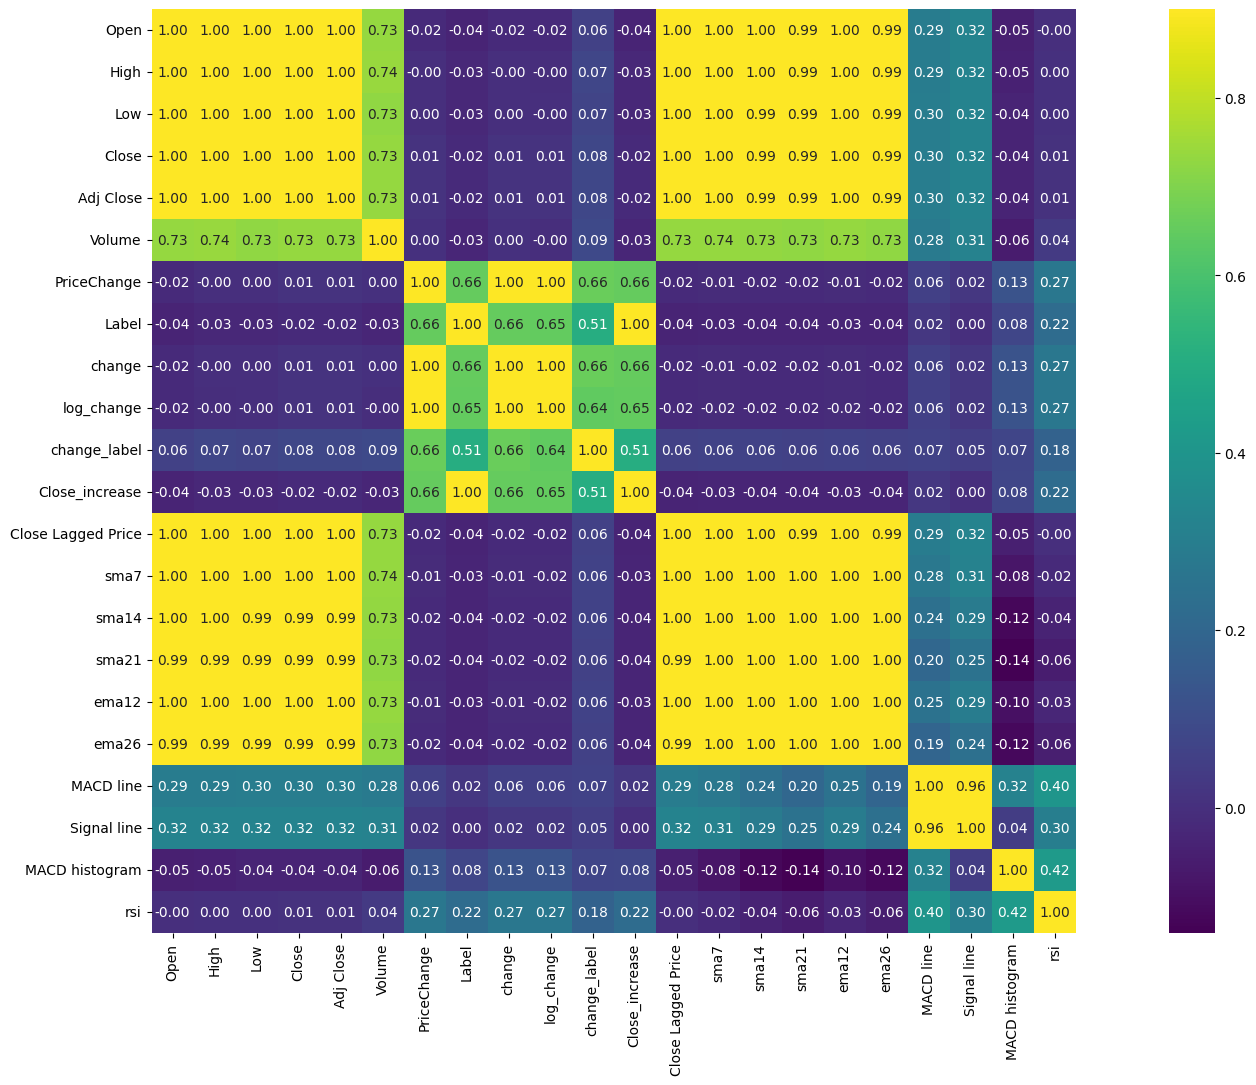

In [120]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

<Axes: xlabel='Label', ylabel='count'>

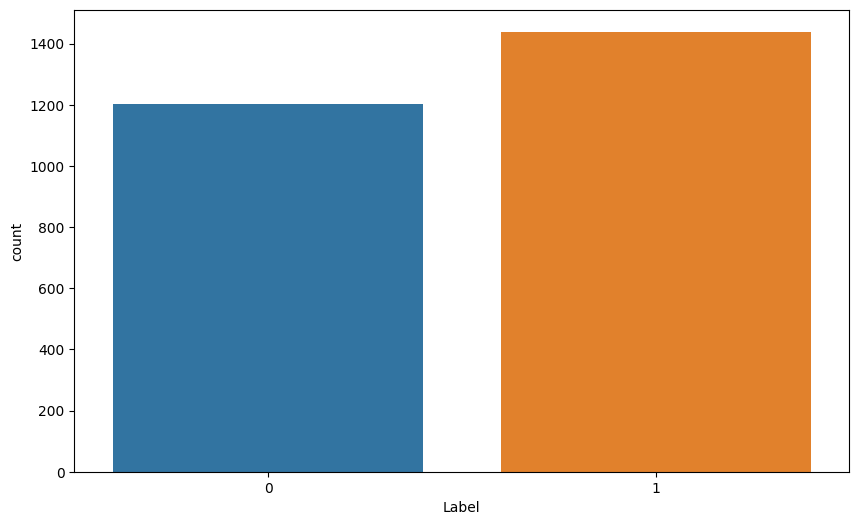

In [121]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [122]:
price['Label'].value_counts()

1    1439
0    1203
Name: Label, dtype: int64

<Figure size 1200x600 with 0 Axes>

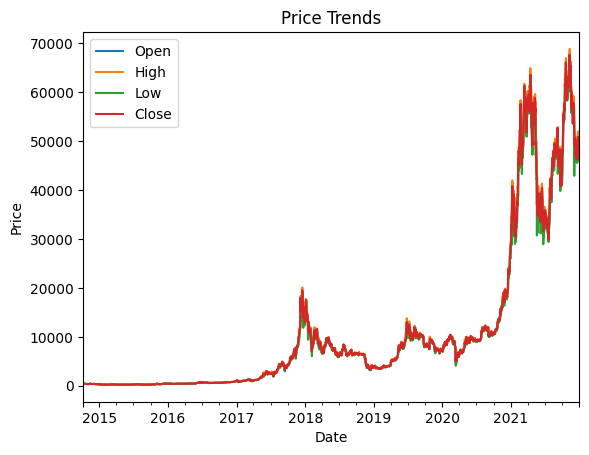

In [123]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

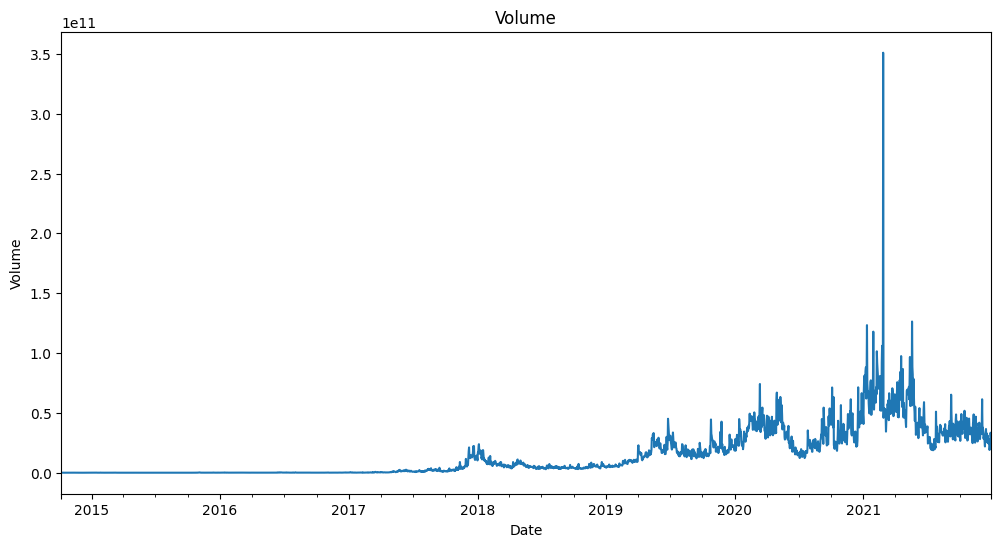

In [124]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1200x600 with 0 Axes>

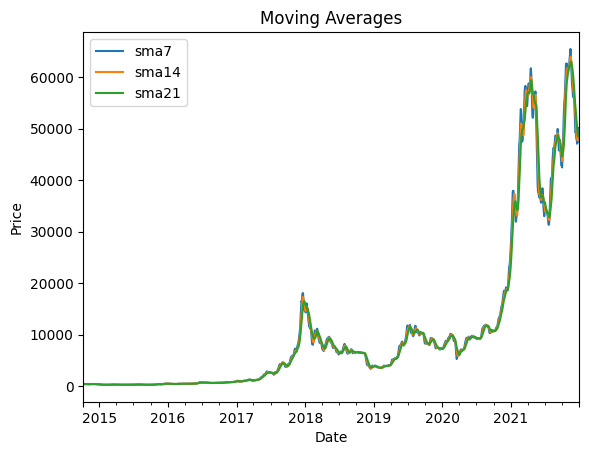

In [125]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

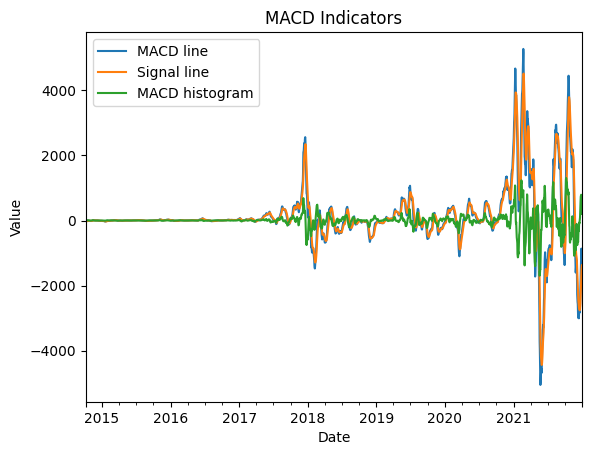

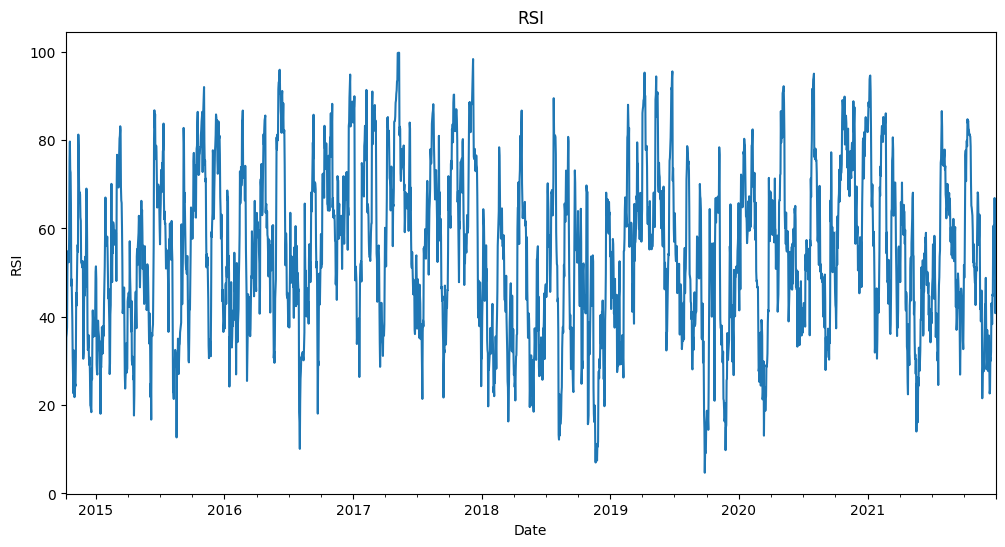

In [126]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

### Process tweets

In [127]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')

In [128]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [129]:
tweets = tweets.drop(['label_up5','label_up2','label_down5','label_down2','Unnamed: 0'],axis=1)

In [130]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [131]:
tweets['text_split'] = tweets['text_split'].str[:200]

In [132]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']
    if compound_score >= 0.05:
        return 1  # Positive sentiment
    elif compound_score <= -0.05:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment

# Apply sentiment analysis and add a binary sentiment column
tweets['sentiment'] = tweets['text_split'].apply(get_sentiment)


In [133]:
# Count the occurrences of zeros and ones in the 'Binary_Sentiment' column
sentiment_counts = tweets['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


 1    221485
-1     86922
 0     33655
Name: sentiment, dtype: int64


In [134]:
# Convert the 'Date' column to datetime
tweets['Date'] = pd.to_datetime(tweets['Date'])

# Group by 'Date' and calculate the most frequent sentiment for each day
tweets = tweets.groupby('Date')['sentiment'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Display the consolidated DataFrame
print(tweets)


           Date  sentiment
0    2015-01-01          1
1    2015-01-02          1
2    2015-01-03          1
3    2015-01-04          1
4    2015-01-05          1
...         ...        ...
2242 2021-05-27          1
2243 2021-05-28          1
2244 2021-05-29          1
2245 2021-05-30          1
2246 2021-05-31          1

[2247 rows x 2 columns]


In [135]:
# Count the occurrences of zeros and ones in the 'Binary_Sentiment' column
sentiment_counts = tweets['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


 1    2224
-1      21
 0       2
Name: sentiment, dtype: int64


In [136]:
price['Date'] = pd.to_datetime(price['Date'])

In [137]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [138]:
tweets

Date  sentiment
0    2015-01-01          1
1    2015-01-02          1
2    2015-01-03          1
3    2015-01-04          1
4    2015-01-05          1
...         ...        ...
2242 2021-05-27          1
2243 2021-05-28          1
2244 2021-05-29          1
2245 2021-05-30          1
2246 2021-05-31          1

[2247 rows x 2 columns]

In [139]:
price = price.drop(['Date'],axis=1)

In [140]:
multi_modal = tweets.merge(price, how='outer', on=['Date'])

In [141]:
multi_modal = multi_modal.dropna()

In [142]:
multi_modal.index = pd.to_datetime(multi_modal['Date'], format='%Y-%m-%d')

In [143]:
multi_modal = multi_modal.dropna()

In [144]:
multi_modal = multi_modal.drop(['Date'], axis=1)

In [145]:
multi_modal = multi_modal.drop(['sentiment'], axis=1)

In [146]:
multi_modal['change_label'] = multi_modal['change_label'].apply(lambda x: 1 if x else 0)

In [147]:
multi_modal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2247 entries, 2015-01-01 to 2021-05-31
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2247 non-null   float64
 1   High                2247 non-null   float64
 2   Low                 2247 non-null   float64
 3   Close               2247 non-null   float64
 4   Adj Close           2247 non-null   float64
 5   Volume              2247 non-null   int64  
 6   PriceChange         2247 non-null   float64
 7   Label               2247 non-null   int32  
 8   change              2247 non-null   float64
 9   log_change          2247 non-null   float64
 10  change_label        2247 non-null   int64  
 11  Close_increase      2247 non-null   int32  
 12  Close Lagged Price  2247 non-null   float64
 13  sma7                2247 non-null   float64
 14  sma14               2247 non-null   float64
 15  sma21               2247 non-null   f

In [148]:
col = list(multi_modal)[0:len(multi_modal)]

In [149]:
df_for_training = multi_modal[col].astype(float)
scaler  = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [150]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)


In [151]:
# X,y = df_to_X_y(df_for_training_scaled)

In [152]:
import numpy as np

def df_to_X_y_with_past_and_future_multivirate(df,df_scaled, n_future, n_past):
    X = []
    y = []
    for i in range(n_past, len(df_scaled) - n_future + 1):
        # X.append(df.iloc[i - n_past:i, :].values)
        # y.append(df.iloc[i + n_future - 1:i + n_future, 0].values)

        X.append(df_scaled[i - n_past:i, 0:df.shape[1]])
        y.append(df_scaled[i + n_future - 1:i + n_future, 0])
    X, y = np.array(X), np.array(y)
    return X, y


In [153]:
n = len(multi_modal)

In [154]:
X,y = df_to_X_y_with_past_and_future_multivirate(df_for_training,df_for_training_scaled,1,14)
X_train, y_train = X[0:int(n*0.7)],y[0:int(n*0.7)]
X_val, y_val = X[int(n*0.7):int(n*0.9)],y[int(n*0.7):int(n*0.9)]
X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]


### Utility methods

In [155]:
def plot_training_history(history, name):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{name}_loss_plot.png')  # Save the loss plot
    plt.show()

    plt.plot(history.history['mean_absolute_error'], label='train_mae')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.savefig(f'{name}_mae_plot.png')  # Save the MAE plot
    plt.show()

In [156]:
EPOCHS = 50

In [157]:
def compile_and_fit(model, x, y, epochs=EPOCHS, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(x, y, epochs= epochs,batch_size=32, validation_split=0.33,shuffle=False, callbacks=[early_stopping])
    return history

### Baseline model

### Vanilla LSTM layer

In [158]:
base_model_1 = Sequential()
base_model_1.add(LSTM(32,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
base_model_1.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_1, to_file='base_model_1.png').show() # write and show

### Standard LSTM layer with 32 units

In [159]:
base_model_2 = Sequential()
base_model_2.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))  # Add an LSTM layer
base_model_2.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_2, to_file='base_model_2.png').show() # write and show

### Bidirectional LSTM layer with 64 units

In [160]:
base_model_3 = Sequential()
base_model_3.add(Bidirectional(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))  # Add a Bidirectional LSTM layer
base_model_3.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_3, to_file='base_model_3.png').show() # write and show

In [161]:
base_model_4 = Sequential()
base_model_4.add(Conv1D(64, kernel_size=3, activation='relu'))
base_model_4.add(MaxPooling1D(pool_size=2))
base_model_4.add(LSTM(64))
base_model_4.add(Dense(32, activation='relu'))
base_model_4.add(Dropout(0.2))
base_model_4.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_4, to_file='text_model.png').show() 

### ConvLSTM model

In [162]:
# Create a ConvLSTM model
base_model_5 = Sequential()
base_model_5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1],X_train.shape[2],3)))
base_model_5.add(BatchNormalization())
base_model_5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
base_model_5.add(BatchNormalization())
base_model_5.add(Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))


### Gated Recurrent Unit (GRU)

In [163]:
base_model_6 = Sequential()
base_model_6.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_6.add(Dense(y_train.shape[1], activation='softmax'))

### Bidirectional LSTM (BiLSTM)

In [164]:
base_model_7 = Sequential()
base_model_7.add(Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_7.add(Dense(y_train.shape[1], activation='softmax'))

### Stacked LSTM

In [165]:
base_model_8 = Sequential()
base_model_8.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_8.add(LSTM(64, return_sequences=True))
base_model_8.add(LSTM(64))
base_model_8.add(Dense(y_train.shape[1], activation='softmax'))

### LSTM with Attention Mechanism

In [166]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = LSTM(64, return_sequences=True)(inputs)
attention = Attention()([lstm, lstm])  # Add attention mechanism
output = Dense(y_train.shape[1], activation='softmax')(attention)
base_model_9 = Model(inputs, output)

### Temporal Convolutional Networks (TCN):

In [167]:
%pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary

Note: you may need to restart the kernel to use updated packages.


In [168]:
base_model_10 = Sequential()
base_model_10.add(TCN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_10.add(Dense(y_train.shape[1], activation='softmax'))

In [169]:
base_model_11 = Sequential()
base_model_11.add(LSTM(units=64,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
base_model_11.add(LSTM(units=32,activation='relu', return_sequences=False))
base_model_11.add(Dropout(0.2))
base_model_11.add(Dense(y_train.shape[1]))
# cp = ModelCheckpoint('model1/', save_best_only=True)
# base_model_11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [170]:
base_model_12 = Sequential()
base_model_12.add(LSTM(64,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
base_model_12.add(LSTM(32,activation='relu',return_sequences=False))
base_model_12.add(Dense(y_train.shape[1]))

In [171]:
models = [
    ('Vanilla LSTM layer', base_model_1),
    # ('Standard LSTM layer with 32 units', base_model_2),
    # ('Bidirectional LSTM layer with 64 units', base_model_3),
    ('Base model 4', base_model_4),
    # ('ConvLSTM model', base_model_5),
    ('Gated Recurrent Unit (GRU)', base_model_6),
    ('Bidirectional LSTM (BiLSTM)', base_model_7),
    ('Stacked LSTM', base_model_8),
    # ('LSTM with Attention Mechanism', base_model_9),
    # ('Temporal Convolutional Networks (TCN)', base_model_10),
    ('LSTM with Attention', base_model_11),
    ('Base model 12', base_model_12)
]

### Build and train the model

In [172]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Training Vanilla LSTM layer...
Epoch 1/5
33/33 [==============================] - 1s 12ms/step - loss: 0.4374 - mean_absolute_error: 0.6166 - val_loss: 0.1075 - val_mean_absolute_error: 0.2637
Epoch 2/5
33/33 [==============================] - 0s 4ms/step - loss: 0.2032 - mean_absolute_error: 0.4134 - val_loss: 0.0793 - val_mean_absolute_error: 0.2183
Epoch 3/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0808 - mean_absolute_error: 0.2532 - val_loss: 0.0640 - val_mean_absolute_error: 0.1912
Epoch 4/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0295 - mean_absolute_error: 0.1461 - val_loss: 0.0563 - val_mean_absolute_error: 0.1773
Epoch 5/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0140 - mean_absolute_error: 0.0925 - val_loss: 0.0516 - val_mean_absolute_error: 0.1700


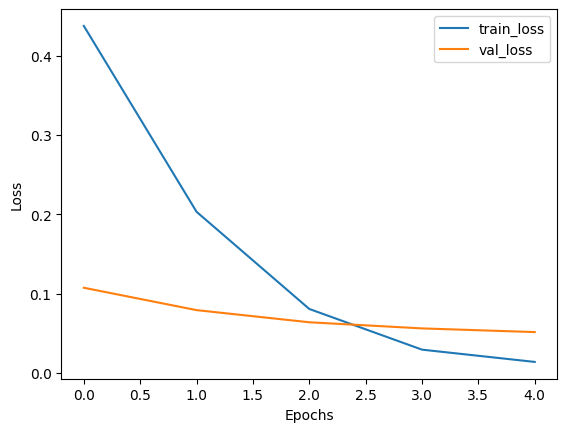

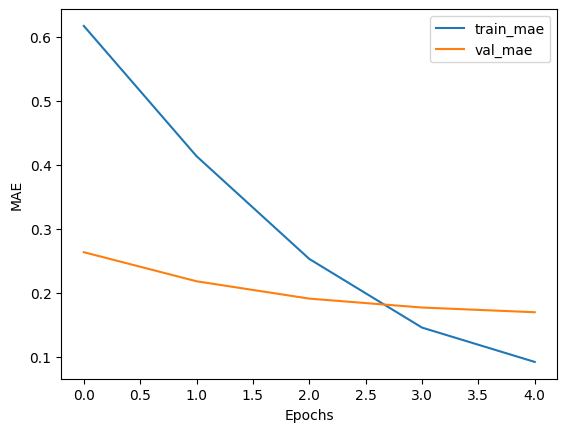

7/7 [==============================] - 0s 1ms/step
Vanilla LSTM layer MAE: 2.2648010869266813
Vanilla LSTM layer MSE: 6.621162240943197
Training Base model 4...
Epoch 1/5
33/33 [==============================] - 2s 12ms/step - loss: 0.2438 - mean_absolute_error: 0.4043 - val_loss: 0.0616 - val_mean_absolute_error: 0.1574
Epoch 2/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0284 - mean_absolute_error: 0.1366 - val_loss: 0.0577 - val_mean_absolute_error: 0.1489
Epoch 3/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0245 - mean_absolute_error: 0.1226 - val_loss: 0.0518 - val_mean_absolute_error: 0.1357
Epoch 4/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0226 - mean_absolute_error: 0.1171 - val_loss: 0.0485 - val_mean_absolute_error: 0.1286
Epoch 5/5
33/33 [==============================] - 0s 4ms/step - loss: 0.0185 - mean_absolute_error: 0.1076 - val_loss: 0.0470 - val_mean_absolute_error: 0.1278


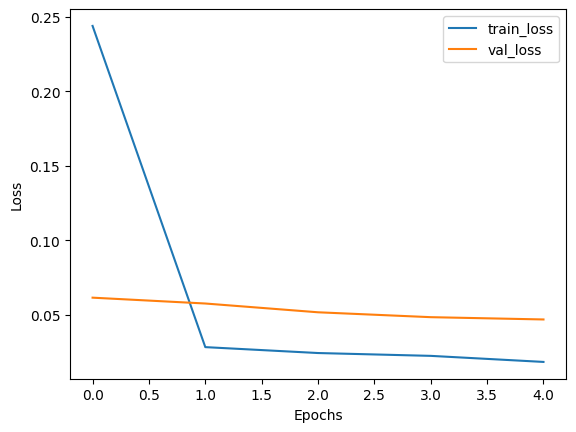

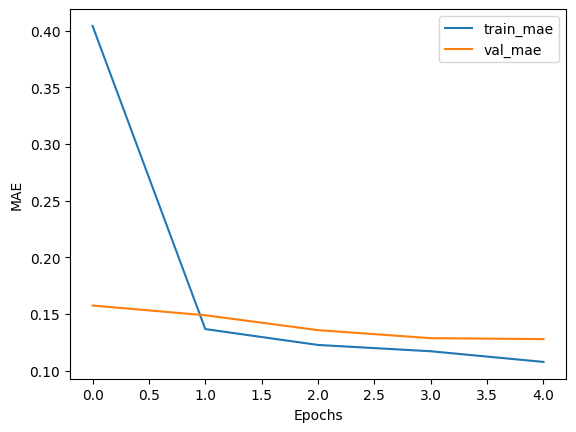

7/7 [==============================] - 0s 1ms/step
Base model 4 MAE: 2.4931719353408384
Base model 4 MSE: 7.694270063574645
Training Gated Recurrent Unit (GRU)...
Epoch 1/5
33/33 [==============================] - 1s 12ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893


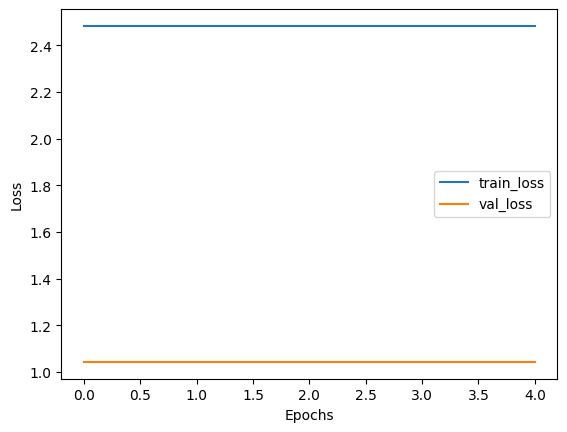

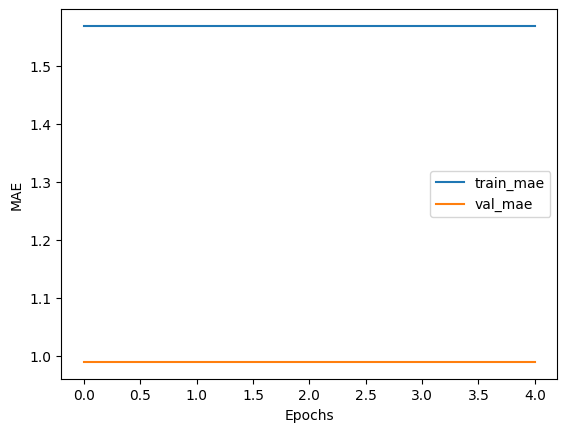

7/7 [==============================] - 0s 2ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/5
33/33 [==============================] - 2s 17ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/5
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893


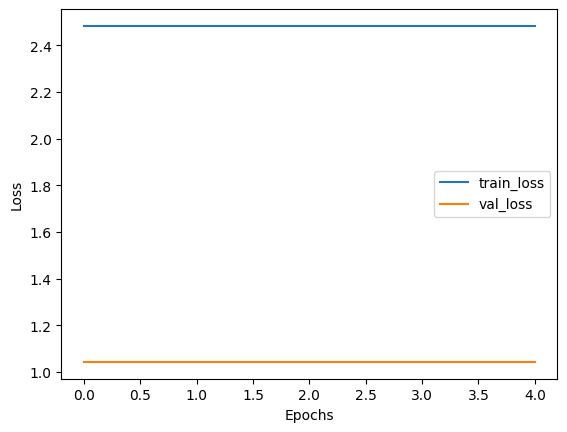

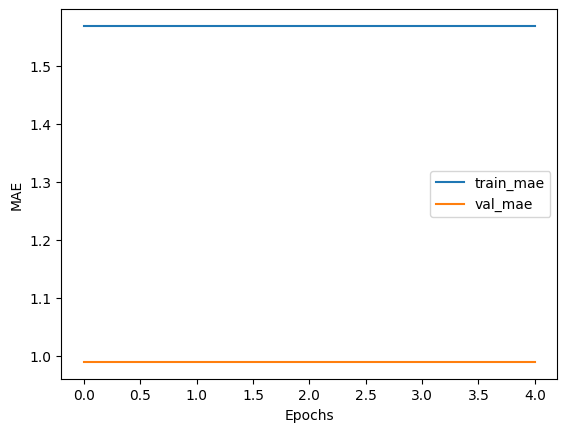

7/7 [==============================] - 0s 2ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/5
33/33 [==============================] - 4s 30ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/5
33/33 [==============================] - 0s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/5
33/33 [==============================] - 0s 10ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/5
33/33 [==============================] - 0s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/5
33/33 [==============================] - 0s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893


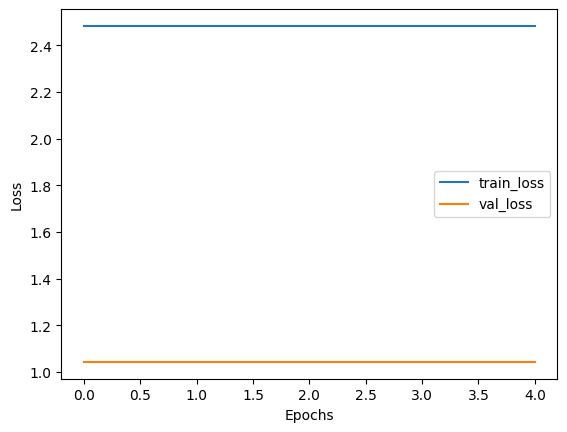

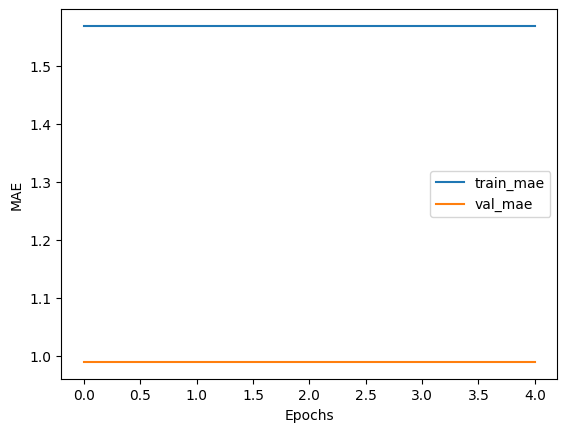

7/7 [==============================] - 1s 3ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/5
33/33 [==============================] - 2s 12ms/step - loss: 0.3940 - mean_absolute_error: 0.5968 - val_loss: 0.0546 - val_mean_absolute_error: 0.1756
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 0.1944 - mean_absolute_error: 0.4043 - val_loss: 0.0701 - val_mean_absolute_error: 0.1799
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0615 - mean_absolute_error: 0.2116 - val_loss: 0.0876 - val_mean_absolute_error: 0.2134
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0288 - mean_absolute_error: 0.1359 - val_loss: 0.0693 - val_mean_absolute_error: 0.1915
Epoch 5/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0244 - mean_absolute_error: 0.1221 - val_loss: 0.0607 - val_mean_absolute_error: 0.1823


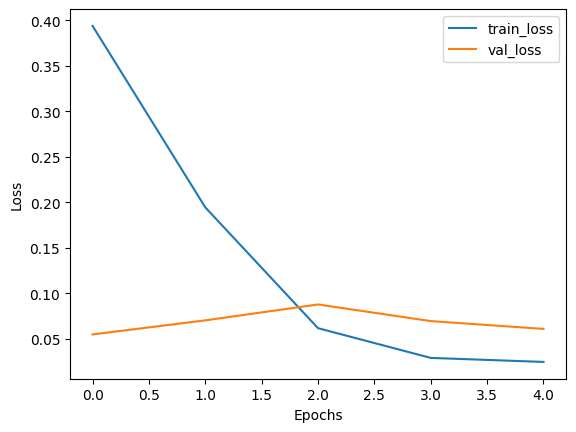

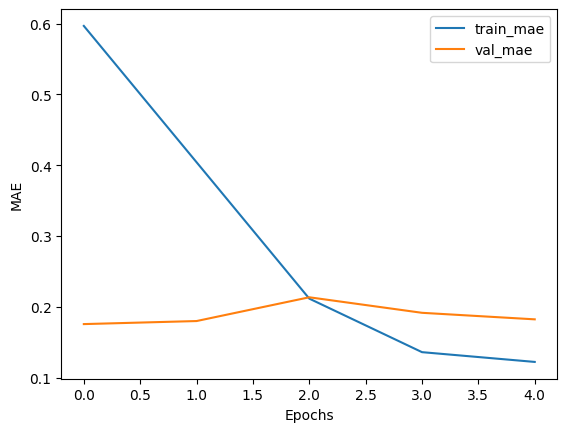

7/7 [==============================] - 0s 3ms/step
LSTM with Attention MAE: 2.2566846936781353
LSTM with Attention MSE: 6.433180517702948
Training Base model 12...
Epoch 1/5
33/33 [==============================] - 2s 13ms/step - loss: 0.2520 - mean_absolute_error: 0.4819 - val_loss: 0.0894 - val_mean_absolute_error: 0.1987
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 0.1107 - mean_absolute_error: 0.3090 - val_loss: 0.1136 - val_mean_absolute_error: 0.2091
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0231 - mean_absolute_error: 0.1364 - val_loss: 0.1231 - val_mean_absolute_error: 0.2288
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0692 - val_loss: 0.0983 - val_mean_absolute_error: 0.2002
Epoch 5/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0578 - val_loss: 0.0832 - val_mean_absolute_error: 0.1807


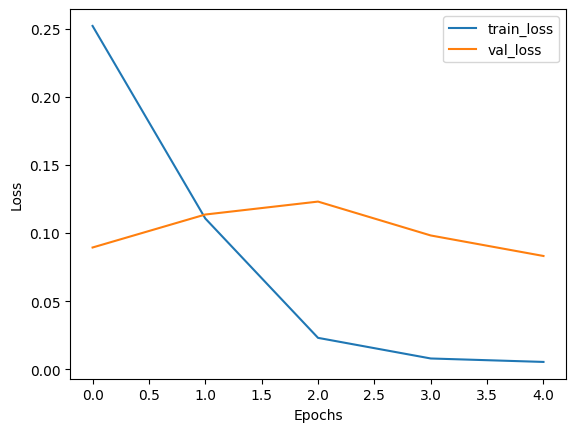

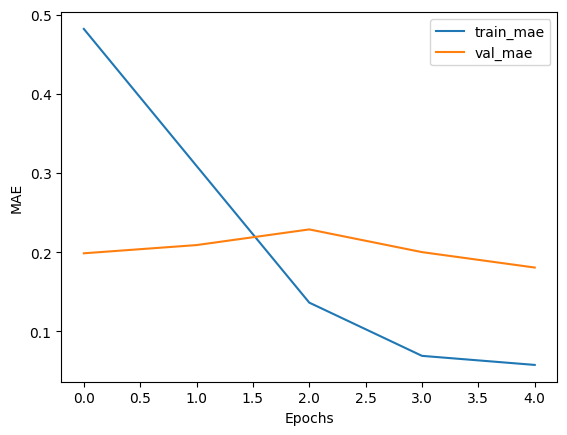

7/7 [==============================] - 0s 2ms/step
Base model 12 MAE: 3.1728827362570247
Base model 12 MSE: 12.822598143185772
Training Vanilla LSTM layer...
Epoch 1/10
33/33 [==============================] - 1s 12ms/step - loss: 0.0087 - mean_absolute_error: 0.0649 - val_loss: 0.0474 - val_mean_absolute_error: 0.1589
Epoch 2/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0645 - val_loss: 0.0399 - val_mean_absolute_error: 0.1464
Epoch 3/10
33/33 [==============================] - 0s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0461 - val_loss: 0.0355 - val_mean_absolute_error: 0.1377
Epoch 4/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0407 - val_loss: 0.0322 - val_mean_absolute_error: 0.1314
Epoch 5/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0031 - mean_absolute_error: 0.0380 - val_loss: 0.0297 - val_mean_absolute_error: 0.1267
Epoch 6/10
33/33 [=============

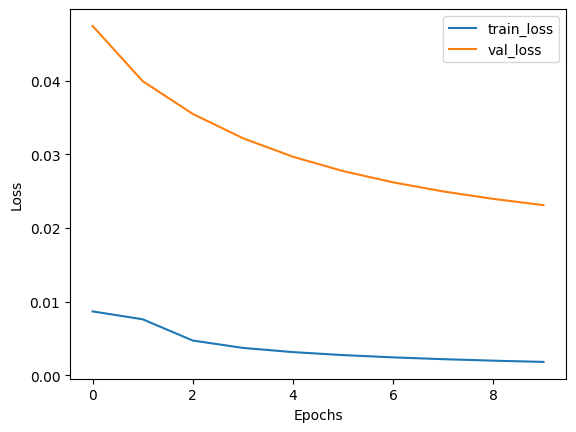

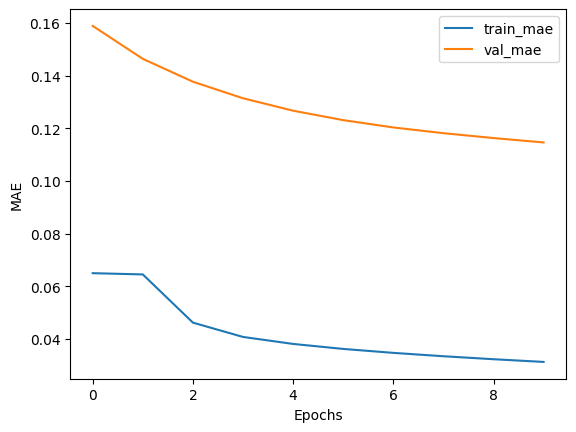

7/7 [==============================] - 0s 1ms/step
Vanilla LSTM layer MAE: 2.189103778697002
Vanilla LSTM layer MSE: 6.379763064748777
Training Base model 4...
Epoch 1/10
33/33 [==============================] - 2s 12ms/step - loss: 0.0160 - mean_absolute_error: 0.0992 - val_loss: 0.0510 - val_mean_absolute_error: 0.1318
Epoch 2/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0876 - val_loss: 0.0441 - val_mean_absolute_error: 0.1228
Epoch 3/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0101 - mean_absolute_error: 0.0792 - val_loss: 0.0375 - val_mean_absolute_error: 0.1122
Epoch 4/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0807 - val_loss: 0.0353 - val_mean_absolute_error: 0.1090
Epoch 5/10
33/33 [==============================] - 0s 4ms/step - loss: 0.0100 - mean_absolute_error: 0.0790 - val_loss: 0.0318 - val_mean_absolute_error: 0.1036
Epoch 6/10
33/33 [===========

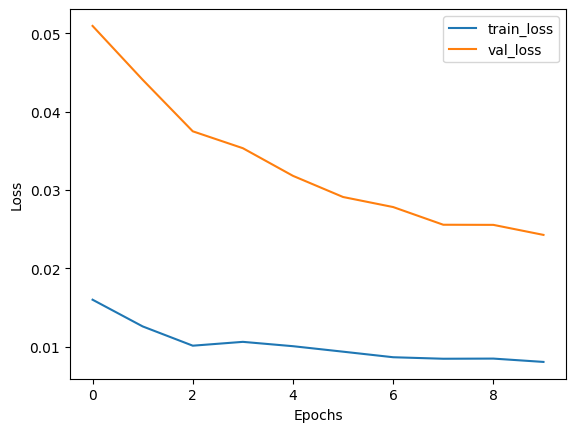

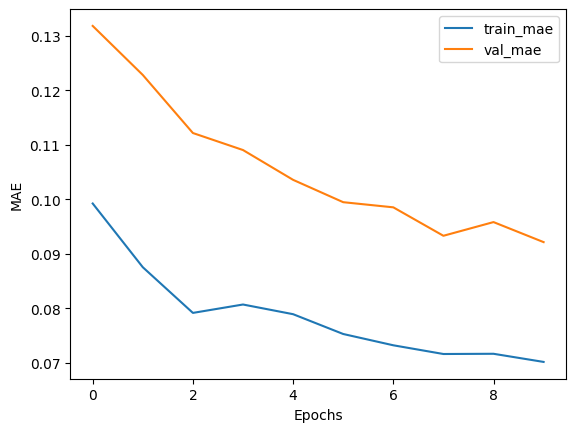

7/7 [==============================] - 0s 1ms/step
Base model 4 MAE: 2.2297737763302115
Base model 4 MSE: 6.394500114114798
Training Gated Recurrent Unit (GRU)...
Epoch 1/10
33/33 [==============================] - 1s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/10
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/10
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/10
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/10
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/10
33/33 [========

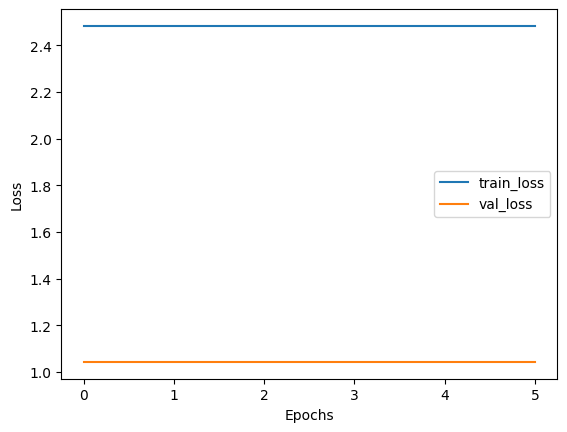

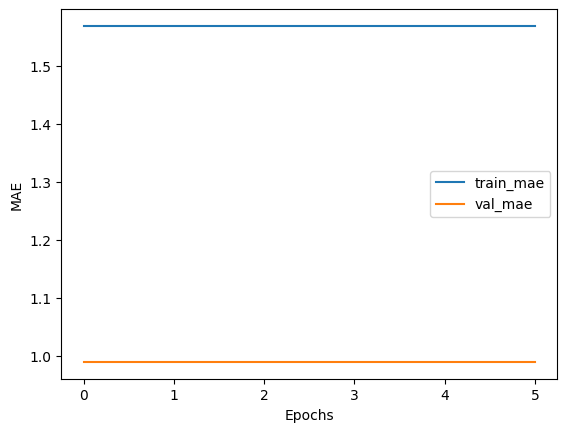

7/7 [==============================] - 0s 1ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/10
33/33 [==============================] - 2s 19ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/10
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/10
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/10
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/10
33/33 [==============================] - 0s 5ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.98

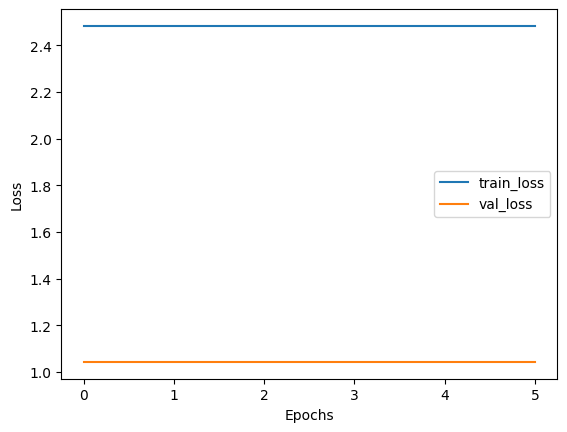

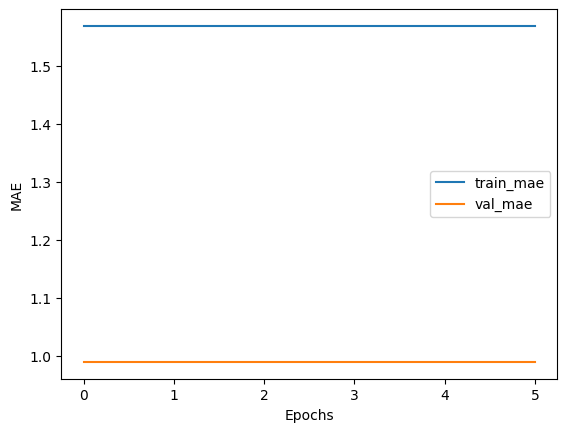

7/7 [==============================] - 0s 2ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/10
33/33 [==============================] - 4s 31ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/10
33/33 [==============================] - 0s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/10
33/33 [==============================] - 0s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/10
33/33 [==============================] - 0s 10ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/10
33/33 [==============================] - 0s 11ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 

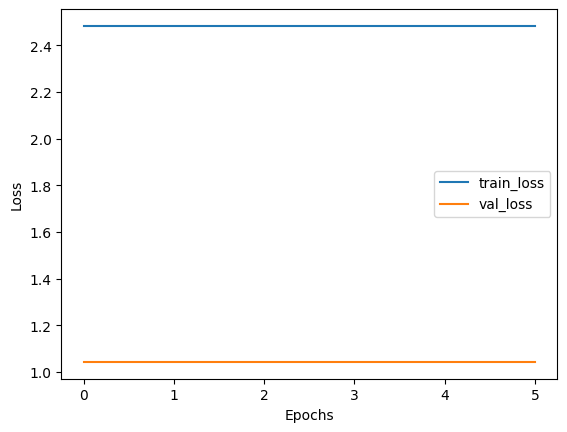

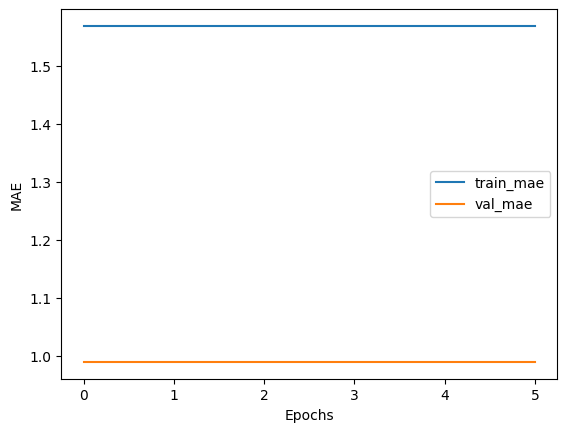

7/7 [==============================] - 1s 3ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/10
33/33 [==============================] - 2s 12ms/step - loss: 0.0192 - mean_absolute_error: 0.1085 - val_loss: 0.0518 - val_mean_absolute_error: 0.1672
Epoch 2/10
33/33 [==============================] - 0s 6ms/step - loss: 0.0172 - mean_absolute_error: 0.1047 - val_loss: 0.0457 - val_mean_absolute_error: 0.1591
Epoch 3/10
33/33 [==============================] - 0s 7ms/step - loss: 0.0137 - mean_absolute_error: 0.0909 - val_loss: 0.0410 - val_mean_absolute_error: 0.1506
Epoch 4/10
33/33 [==============================] - 0s 7ms/step - loss: 0.0143 - mean_absolute_error: 0.0930 - val_loss: 0.0380 - val_mean_absolute_error: 0.1449
Epoch 5/10
33/33 [==============================] - 0s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0893 - val_loss: 0.0370 - val_mean_absolute_error: 0.1448
Epoch 6/10
33/33 [===============

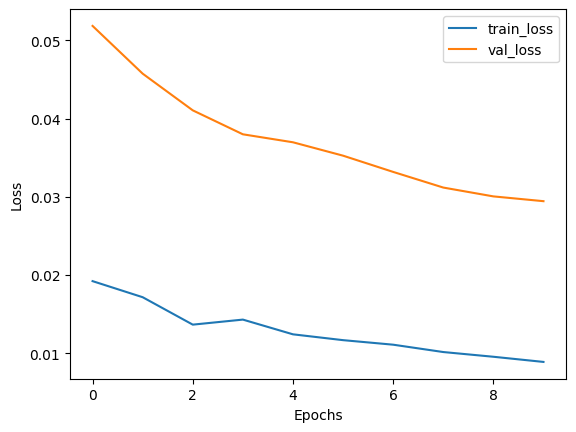

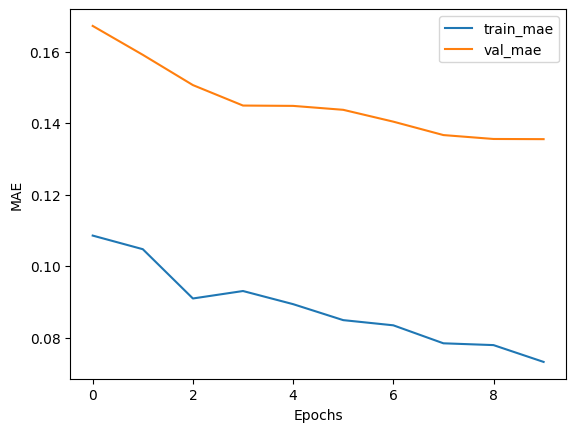

7/7 [==============================] - 0s 2ms/step
LSTM with Attention MAE: 1.7170223154779953
LSTM with Attention MSE: 3.828028572656083
Training Base model 12...
Epoch 1/10
33/33 [==============================] - 2s 12ms/step - loss: 0.0035 - mean_absolute_error: 0.0412 - val_loss: 0.0704 - val_mean_absolute_error: 0.1611
Epoch 2/10
33/33 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0334 - val_loss: 0.0604 - val_mean_absolute_error: 0.1468
Epoch 3/10
33/33 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0235 - val_loss: 0.0547 - val_mean_absolute_error: 0.1386
Epoch 4/10
33/33 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0204 - val_loss: 0.0512 - val_mean_absolute_error: 0.1333
Epoch 5/10
33/33 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_absolute_error: 0.0198 - val_loss: 0.0483 - val_mean_absolute_error: 0.1289
Epoch 6/10
33/33 [=======

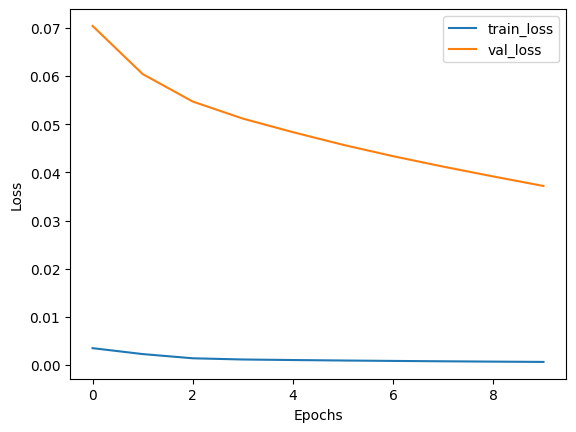

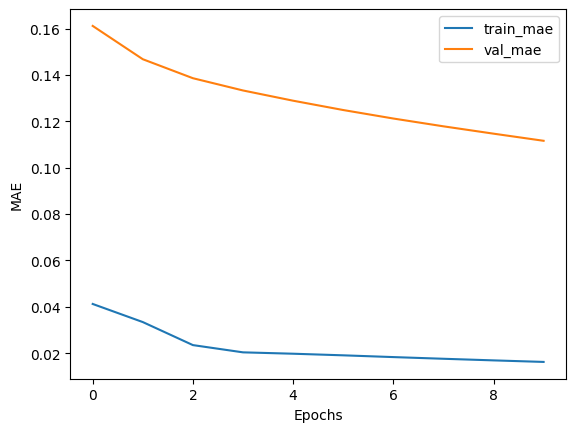

7/7 [==============================] - 0s 2ms/step
Base model 12 MAE: 2.5236003726605154
Base model 12 MSE: 8.22751559479363
Training Vanilla LSTM layer...
Epoch 1/30
33/33 [==============================] - 1s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0265 - val_loss: 0.0242 - val_mean_absolute_error: 0.1170
Epoch 2/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0342 - val_loss: 0.0224 - val_mean_absolute_error: 0.1137
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0328 - val_loss: 0.0213 - val_mean_absolute_error: 0.1110
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0301 - val_loss: 0.0204 - val_mean_absolute_error: 0.1087
Epoch 5/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0282 - val_loss: 0.0197 - val_mean_absolute_error: 0.1069
Epoch 6/30
33/33 [===============

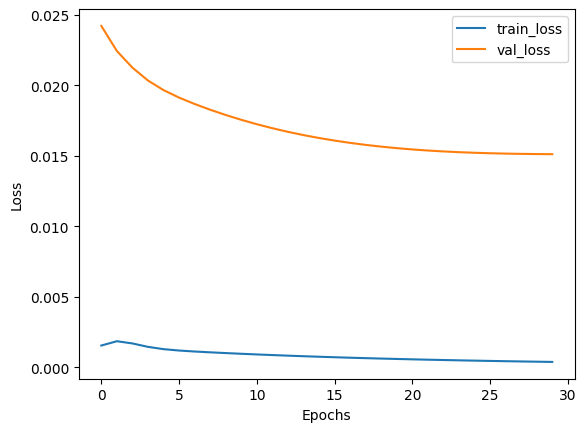

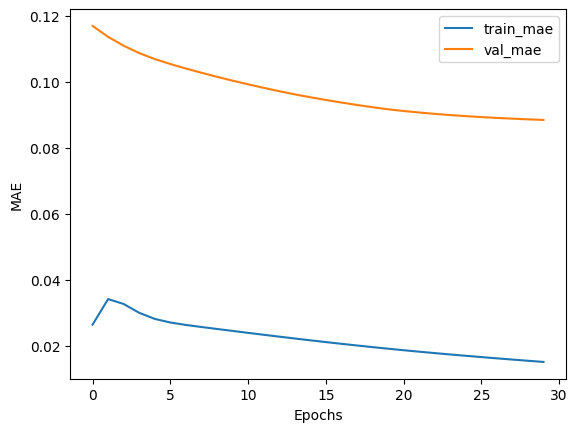

7/7 [==============================] - 0s 1ms/step
Vanilla LSTM layer MAE: 2.2062356986651865
Vanilla LSTM layer MSE: 6.508017195170927
Training Base model 4...
Epoch 1/30
33/33 [==============================] - 2s 12ms/step - loss: 0.0082 - mean_absolute_error: 0.0701 - val_loss: 0.0244 - val_mean_absolute_error: 0.0924
Epoch 2/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0730 - val_loss: 0.0236 - val_mean_absolute_error: 0.0926
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_error: 0.0699 - val_loss: 0.0198 - val_mean_absolute_error: 0.0823
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0662 - val_loss: 0.0215 - val_mean_absolute_error: 0.0868
Epoch 5/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0680 - val_loss: 0.0203 - val_mean_absolute_error: 0.0869
Epoch 6/30
33/33 [==========

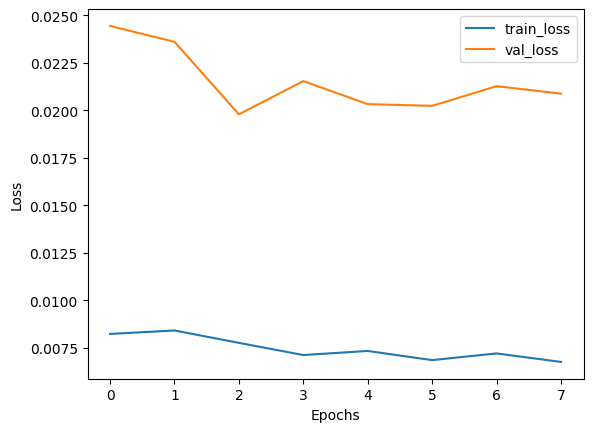

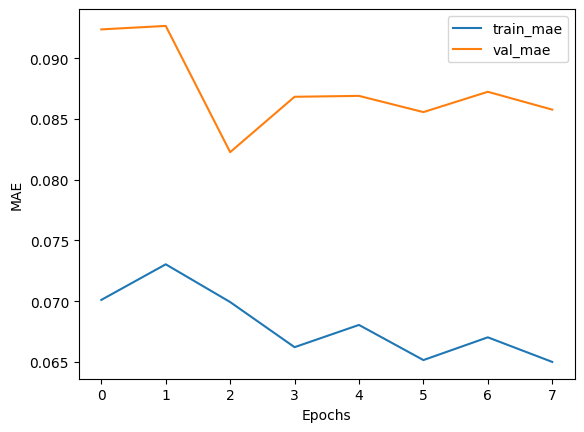

7/7 [==============================] - 0s 1ms/step
Base model 4 MAE: 2.16855129348679
Base model 4 MSE: 6.122205293313908
Training Gated Recurrent Unit (GRU)...
Epoch 1/30
33/33 [==============================] - 1s 12ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/30
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/30
33/33 [==============================] - 0s 4ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/30
33/33 [==========

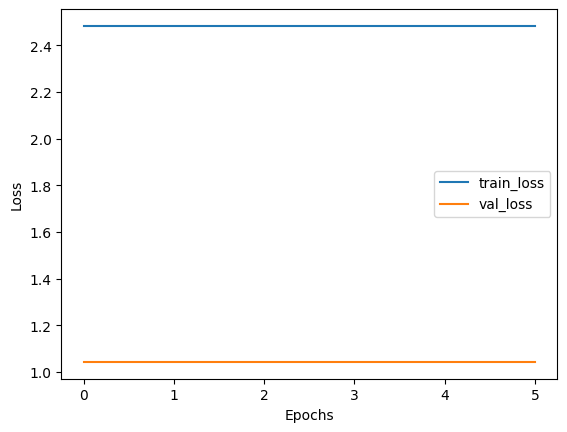

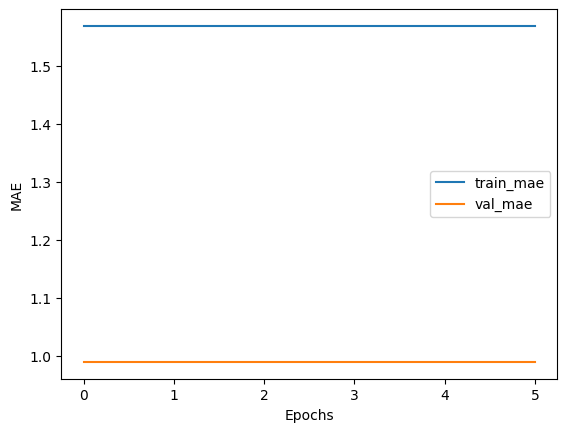

7/7 [==============================] - 0s 19ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/30
33/33 [==============================] - 7s 169ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/30
33/33 [==============================] - 5s 155ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/30
33/33 [==============================] - 5s 158ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/30
33/33 [==============================] - 5s 166ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/30
33/33 [==============================] - 5s 155ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_e

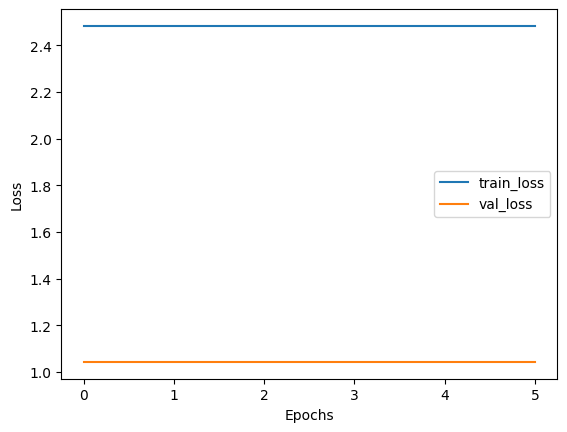

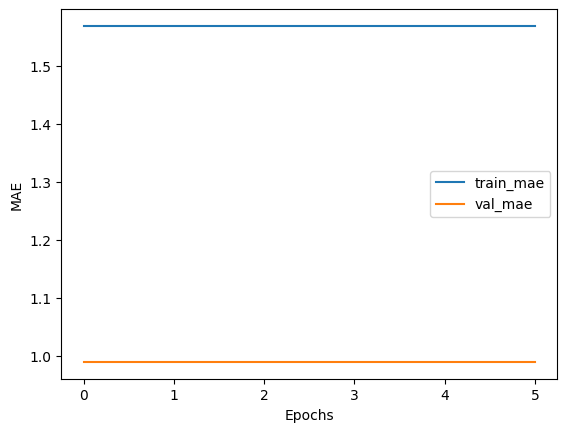

7/7 [==============================] - 1s 50ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/30
33/33 [==============================] - 13s 318ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/30
33/33 [==============================] - 10s 296ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/30
33/33 [==============================] - 10s 292ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/30
33/33 [==============================] - 10s 291ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/30
33/33 [==============================] - 9s 285ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9

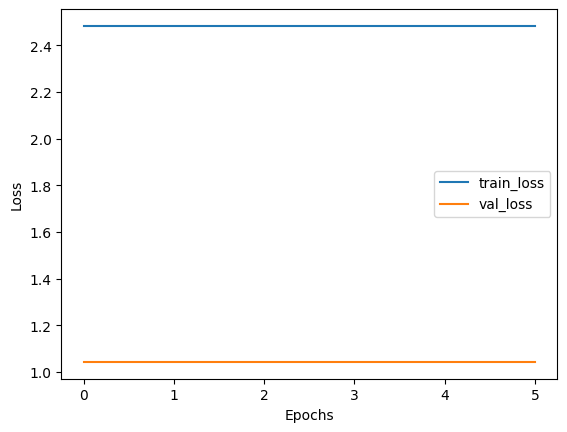

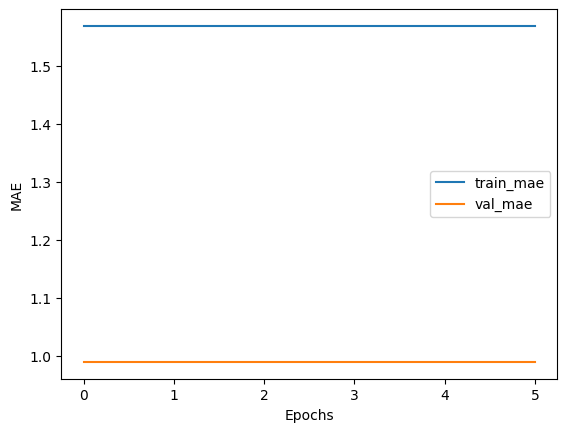

7/7 [==============================] - 1s 87ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/30
33/33 [==============================] - 6s 154ms/step - loss: 0.0088 - mean_absolute_error: 0.0743 - val_loss: 0.0298 - val_mean_absolute_error: 0.1362
Epoch 2/30
33/33 [==============================] - 5s 144ms/step - loss: 0.0090 - mean_absolute_error: 0.0756 - val_loss: 0.0291 - val_mean_absolute_error: 0.1364
Epoch 3/30
33/33 [==============================] - 5s 142ms/step - loss: 0.0081 - mean_absolute_error: 0.0711 - val_loss: 0.0275 - val_mean_absolute_error: 0.1327
Epoch 4/30
33/33 [==============================] - 5s 140ms/step - loss: 0.0085 - mean_absolute_error: 0.0712 - val_loss: 0.0261 - val_mean_absolute_error: 0.1293
Epoch 5/30
33/33 [==============================] - 5s 144ms/step - loss: 0.0077 - mean_absolute_error: 0.0692 - val_loss: 0.0255 - val_mean_absolute_error: 0.1286
Epoch 6/30
33/33 [=====

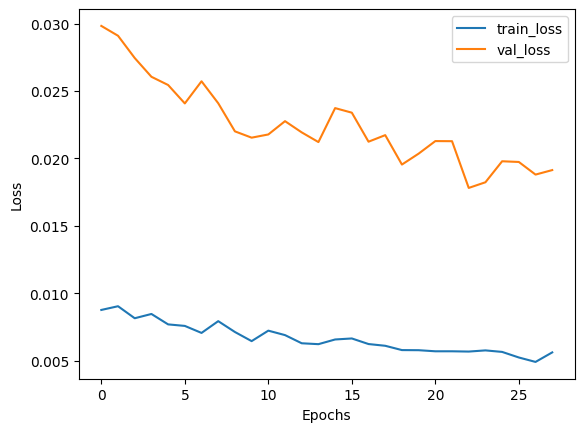

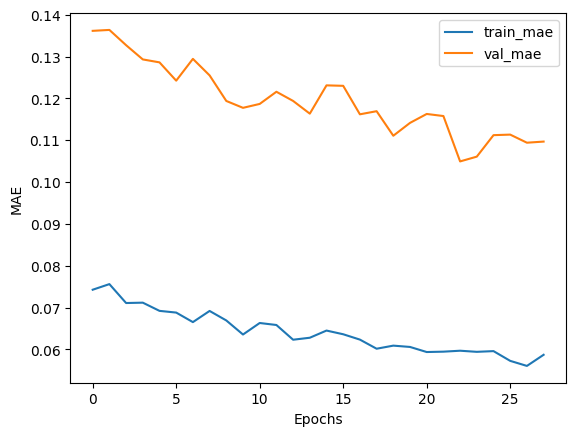

7/7 [==============================] - 0s 43ms/step
LSTM with Attention MAE: 1.009935149490464
LSTM with Attention MSE: 1.67090406991821
Training Base model 12...
Epoch 1/30
33/33 [==============================] - 6s 149ms/step - loss: 6.5144e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0384 - val_mean_absolute_error: 0.1136
Epoch 2/30
33/33 [==============================] - 5s 146ms/step - loss: 7.6547e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0348 - val_mean_absolute_error: 0.1078
Epoch 3/30
33/33 [==============================] - 5s 139ms/step - loss: 4.9460e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0328 - val_mean_absolute_error: 0.1047
Epoch 4/30
33/33 [==============================] - 5s 142ms/step - loss: 4.4857e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0304 - val_mean_absolute_error: 0.1009
Epoch 5/30
33/33 [==============================] - 5s 141ms/step - loss: 3.9341e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0282 - val_mean_absolute_error: 0.09

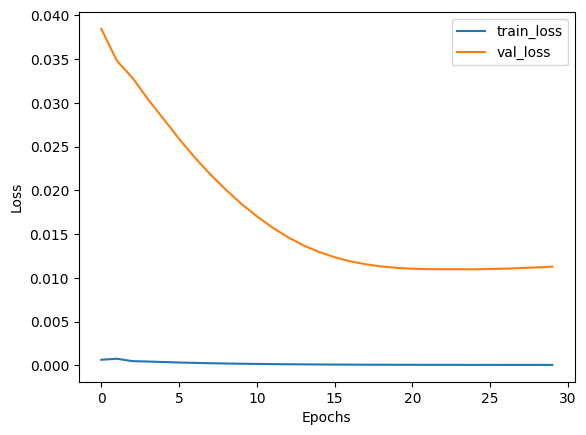

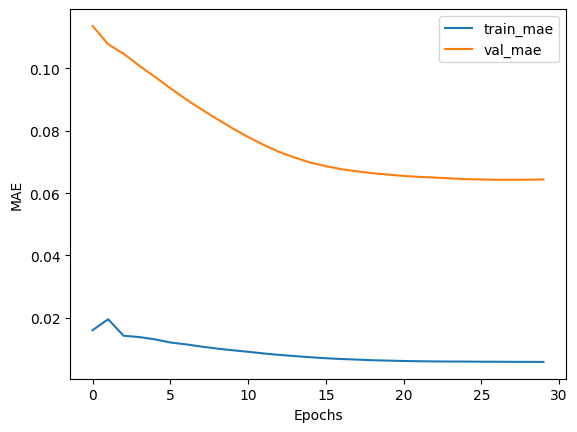

7/7 [==============================] - 0s 41ms/step
Base model 12 MAE: 11.912938186866011
Base model 12 MSE: 285.413999403915
Training Vanilla LSTM layer...
Epoch 1/50
33/33 [==============================] - 3s 55ms/step - loss: 2.6762e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0154 - val_mean_absolute_error: 0.0895
Epoch 2/50
33/33 [==============================] - 2s 47ms/step - loss: 3.4899e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0148 - val_mean_absolute_error: 0.0867
Epoch 3/50
33/33 [==============================] - 2s 49ms/step - loss: 2.6196e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0145 - val_mean_absolute_error: 0.0856
Epoch 4/50
33/33 [==============================] - 2s 49ms/step - loss: 2.2673e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0147 - val_mean_absolute_error: 0.0858
Epoch 5/50
33/33 [==============================] - 2s 50ms/step - loss: 2.1730e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0147 - val_mean_absolute_error: 0.0857
Epoch 6/

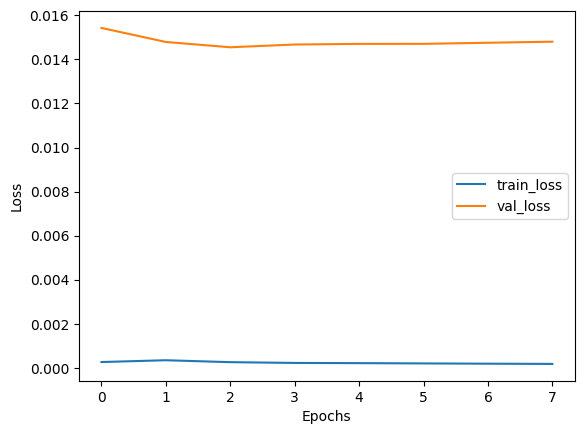

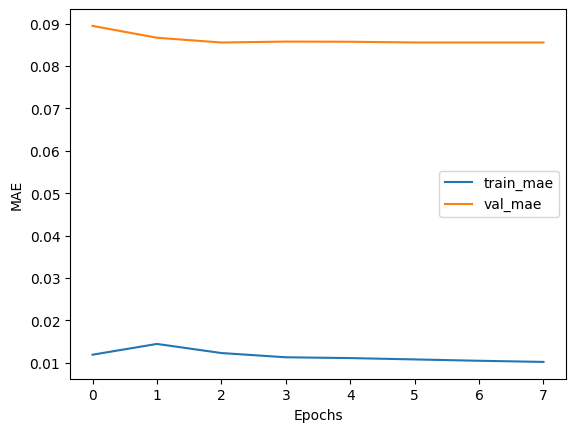

7/7 [==============================] - 0s 17ms/step
Vanilla LSTM layer MAE: 2.2164295590105474
Vanilla LSTM layer MSE: 6.554001802624442
Training Base model 4...
Epoch 1/50
33/33 [==============================] - 4s 90ms/step - loss: 0.0069 - mean_absolute_error: 0.0659 - val_loss: 0.0212 - val_mean_absolute_error: 0.0878
Epoch 2/50
33/33 [==============================] - 3s 80ms/step - loss: 0.0073 - mean_absolute_error: 0.0676 - val_loss: 0.0198 - val_mean_absolute_error: 0.0868
Epoch 3/50
33/33 [==============================] - 3s 78ms/step - loss: 0.0065 - mean_absolute_error: 0.0634 - val_loss: 0.0191 - val_mean_absolute_error: 0.0842
Epoch 4/50
33/33 [==============================] - 3s 78ms/step - loss: 0.0069 - mean_absolute_error: 0.0660 - val_loss: 0.0188 - val_mean_absolute_error: 0.0843
Epoch 5/50
33/33 [==============================] - 3s 78ms/step - loss: 0.0068 - mean_absolute_error: 0.0647 - val_loss: 0.0197 - val_mean_absolute_error: 0.0865
Epoch 6/50
33/33 [=====

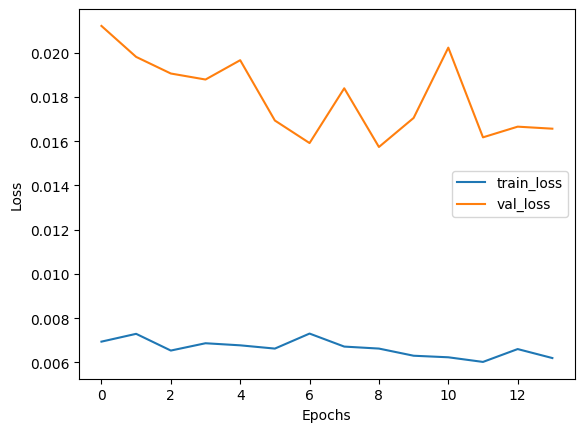

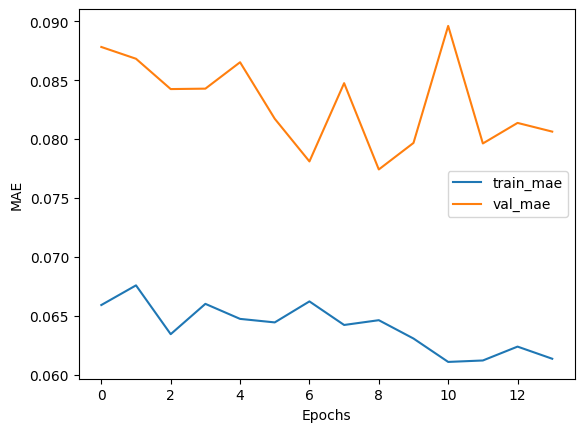

7/7 [==============================] - 0s 21ms/step
Base model 4 MAE: 2.023356394213645
Base model 4 MSE: 5.424609486524218
Training Gated Recurrent Unit (GRU)...
Epoch 1/50
33/33 [==============================] - 3s 70ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/50
33/33 [==============================] - 2s 59ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/50
33/33 [==============================] - 2s 59ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/50
33/33 [==============================] - 2s 73ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/50
33/33 [==============================] - 2s 64ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/50
33/33 [====

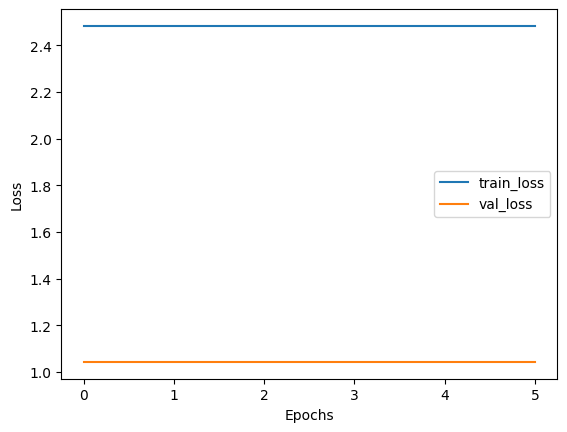

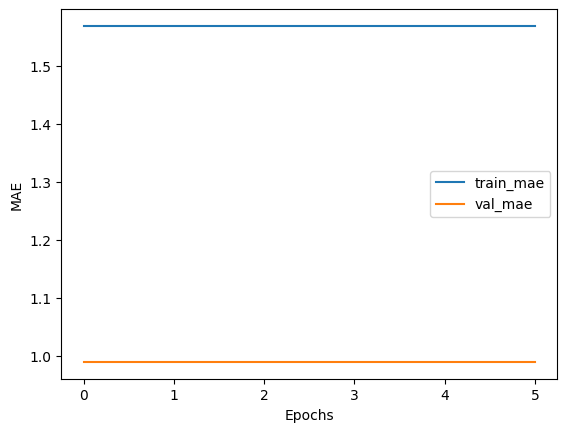

7/7 [==============================] - 0s 18ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/50
33/33 [==============================] - 7s 152ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/50
33/33 [==============================] - 5s 140ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/50
33/33 [==============================] - 5s 144ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/50
33/33 [==============================] - 4s 131ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/50
33/33 [==============================] - 4s 132ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_e

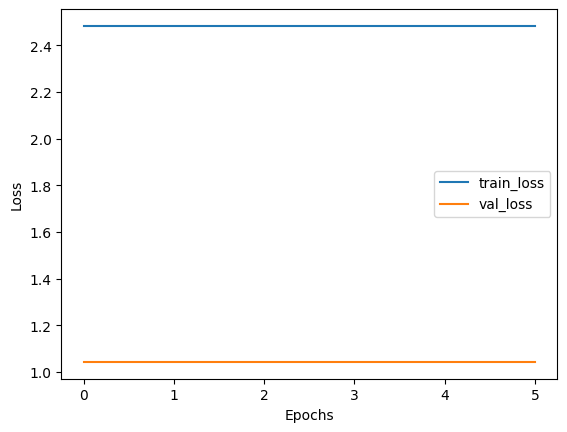

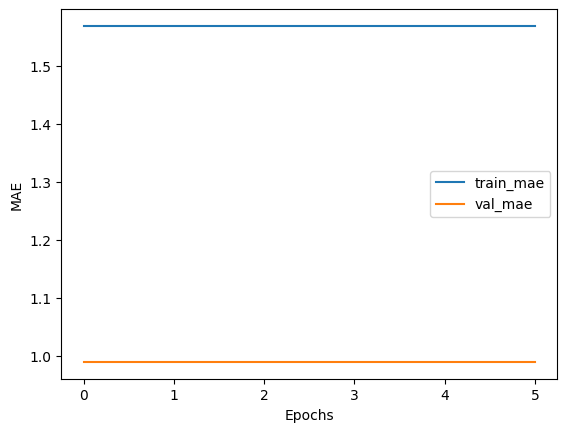

7/7 [==============================] - 1s 41ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/50
33/33 [==============================] - 11s 261ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/50
33/33 [==============================] - 8s 243ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/50
33/33 [==============================] - 8s 255ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/50
33/33 [==============================] - 9s 259ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/50
33/33 [==============================] - 8s 253ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893

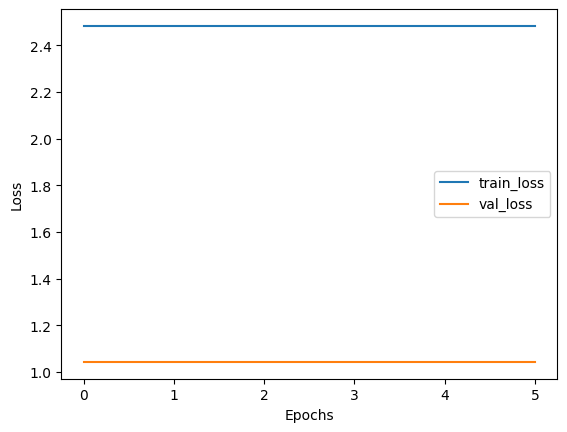

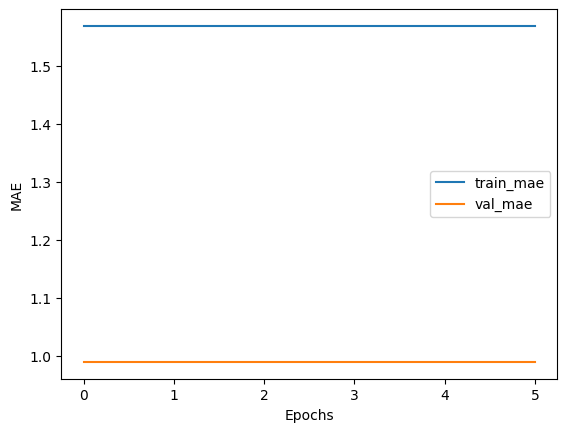

7/7 [==============================] - 1s 76ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/50
33/33 [==============================] - 6s 138ms/step - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0207 - val_mean_absolute_error: 0.1156
Epoch 2/50
33/33 [==============================] - 4s 124ms/step - loss: 0.0053 - mean_absolute_error: 0.0576 - val_loss: 0.0172 - val_mean_absolute_error: 0.1036
Epoch 3/50
33/33 [==============================] - 4s 126ms/step - loss: 0.0056 - mean_absolute_error: 0.0589 - val_loss: 0.0170 - val_mean_absolute_error: 0.1028
Epoch 4/50
33/33 [==============================] - 4s 130ms/step - loss: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0172 - val_mean_absolute_error: 0.1049
Epoch 5/50
33/33 [==============================] - 4s 128ms/step - loss: 0.0054 - mean_absolute_error: 0.0582 - val_loss: 0.0170 - val_mean_absolute_error: 0.1039
Epoch 6/50
33/33 [=====

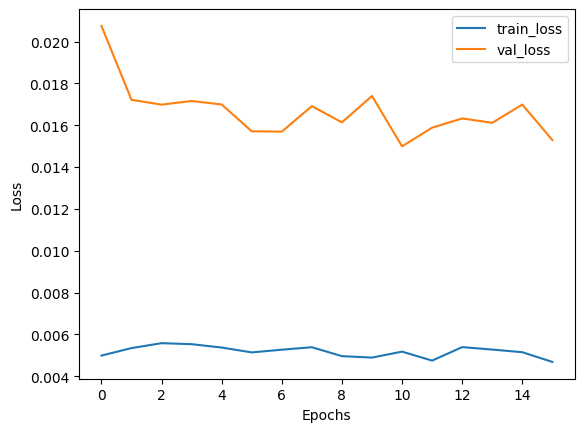

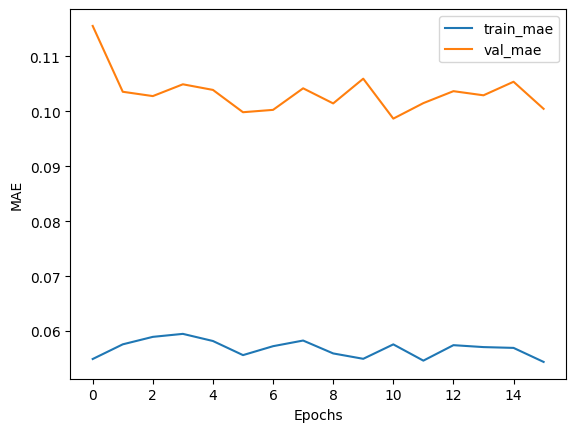

7/7 [==============================] - 0s 41ms/step
LSTM with Attention MAE: 2.0390244808717806
LSTM with Attention MSE: 9.682288151591267
Training Base model 12...
Epoch 1/50
33/33 [==============================] - 6s 129ms/step - loss: 5.5935e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0111 - val_mean_absolute_error: 0.0637
Epoch 2/50
33/33 [==============================] - 4s 120ms/step - loss: 5.5474e-05 - mean_absolute_error: 0.0056 - val_loss: 0.0113 - val_mean_absolute_error: 0.0654
Epoch 3/50
33/33 [==============================] - 4s 120ms/step - loss: 5.6735e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0118 - val_mean_absolute_error: 0.0654
Epoch 4/50
33/33 [==============================] - 4s 124ms/step - loss: 5.4608e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0114 - val_mean_absolute_error: 0.0652
Epoch 5/50
33/33 [==============================] - 4s 122ms/step - loss: 6.5221e-05 - mean_absolute_error: 0.0063 - val_loss: 0.0123 - val_mean_absolute_error: 0.

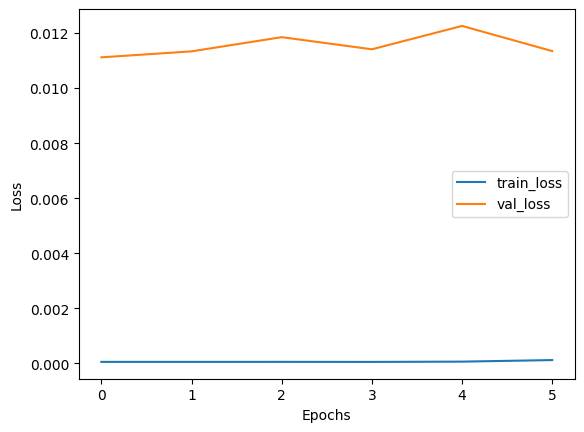

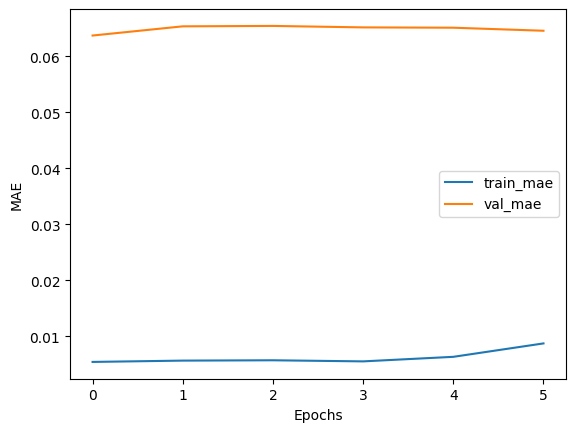

7/7 [==============================] - 0s 36ms/step
Base model 12 MAE: 11.720218535453386
Base model 12 MSE: 275.418140342741
Training Vanilla LSTM layer...
Epoch 1/80
33/33 [==============================] - 3s 54ms/step - loss: 1.7256e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0153 - val_mean_absolute_error: 0.0874
Epoch 2/80
33/33 [==============================] - 2s 46ms/step - loss: 1.9368e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0150 - val_mean_absolute_error: 0.0858
Epoch 3/80
33/33 [==============================] - 1s 43ms/step - loss: 1.7689e-04 - mean_absolute_error: 0.0102 - val_loss: 0.0149 - val_mean_absolute_error: 0.0856
Epoch 4/80
33/33 [==============================] - 1s 43ms/step - loss: 1.5733e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0148 - val_mean_absolute_error: 0.0853
Epoch 5/80
33/33 [==============================] - 1s 43ms/step - loss: 1.4456e-04 - mean_absolute_error: 0.0092 - val_loss: 0.0149 - val_mean_absolute_error: 0.0855
Epoch 6/

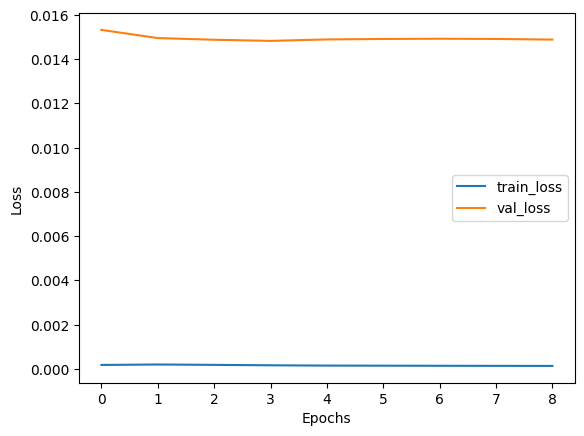

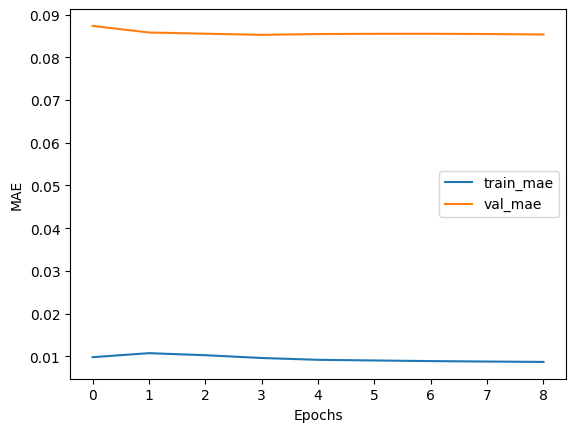

7/7 [==============================] - 0s 14ms/step
Vanilla LSTM layer MAE: 2.218959809377285
Vanilla LSTM layer MSE: 6.557358939878833
Training Base model 4...
Epoch 1/80
33/33 [==============================] - 4s 80ms/step - loss: 0.0061 - mean_absolute_error: 0.0620 - val_loss: 0.0164 - val_mean_absolute_error: 0.0817
Epoch 2/80
33/33 [==============================] - 2s 69ms/step - loss: 0.0062 - mean_absolute_error: 0.0619 - val_loss: 0.0157 - val_mean_absolute_error: 0.0825
Epoch 3/80
33/33 [==============================] - 2s 73ms/step - loss: 0.0060 - mean_absolute_error: 0.0604 - val_loss: 0.0144 - val_mean_absolute_error: 0.0763
Epoch 4/80
33/33 [==============================] - 2s 70ms/step - loss: 0.0058 - mean_absolute_error: 0.0600 - val_loss: 0.0179 - val_mean_absolute_error: 0.0861
Epoch 5/80
33/33 [==============================] - 2s 70ms/step - loss: 0.0058 - mean_absolute_error: 0.0596 - val_loss: 0.0135 - val_mean_absolute_error: 0.0745
Epoch 6/80
33/33 [======

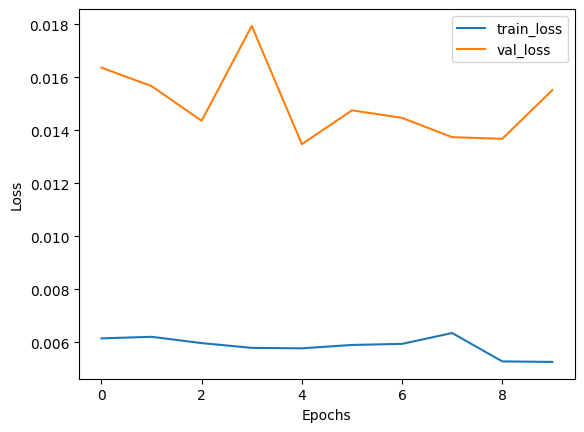

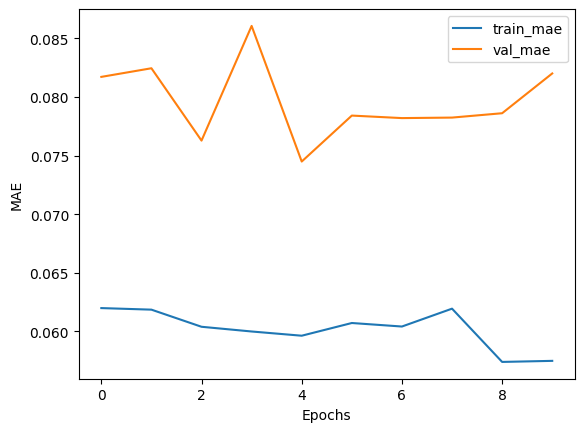

7/7 [==============================] - 0s 18ms/step
Base model 4 MAE: 1.9961763698394923
Base model 4 MSE: 5.317361898667404
Training Gated Recurrent Unit (GRU)...
Epoch 1/80
33/33 [==============================] - 3s 63ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/80
33/33 [==============================] - 2s 52ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/80
33/33 [==============================] - 2s 52ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/80
33/33 [==============================] - 2s 53ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/80
33/33 [==============================] - 2s 52ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/80
33/33 [===

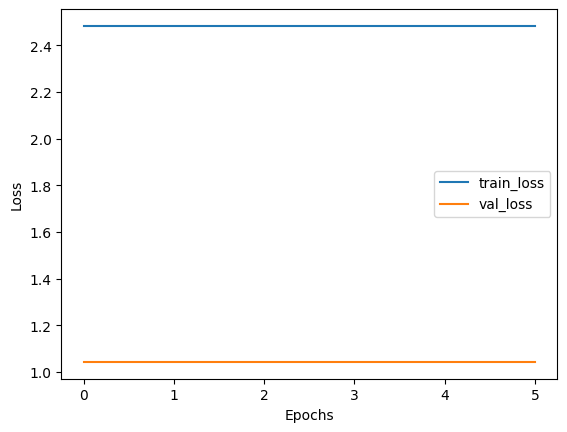

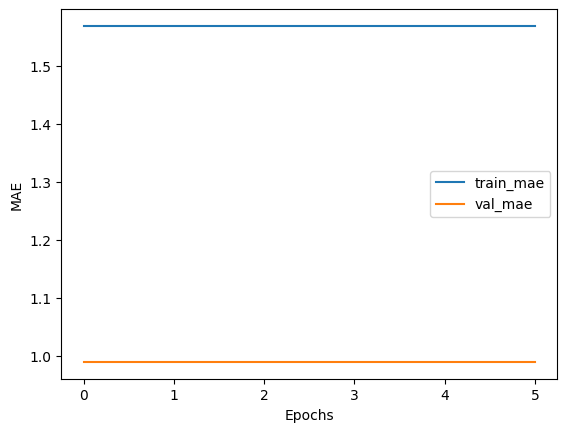

7/7 [==============================] - 0s 16ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/80
33/33 [==============================] - 6s 129ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/80
33/33 [==============================] - 4s 120ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/80
33/33 [==============================] - 4s 117ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/80
33/33 [==============================] - 4s 119ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/80
33/33 [==============================] - 4s 123ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_e

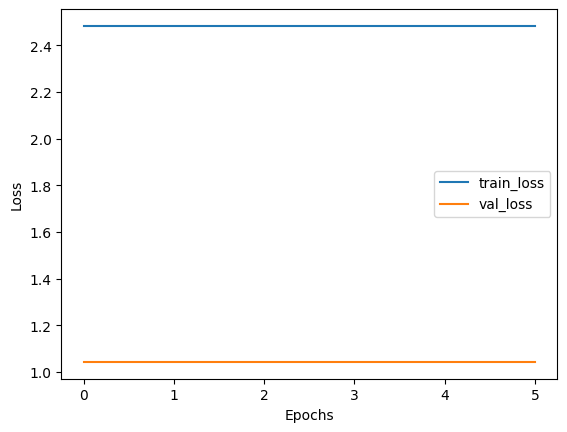

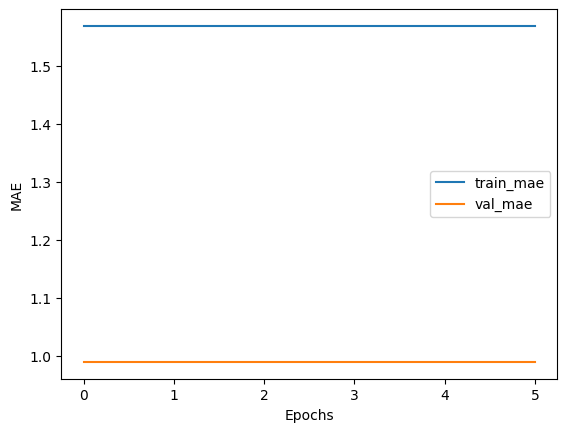

7/7 [==============================] - 1s 39ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/80
33/33 [==============================] - 11s 241ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/80
33/33 [==============================] - 7s 220ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/80
33/33 [==============================] - 7s 222ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/80
33/33 [==============================] - 7s 222ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/80
33/33 [==============================] - 7s 222ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893

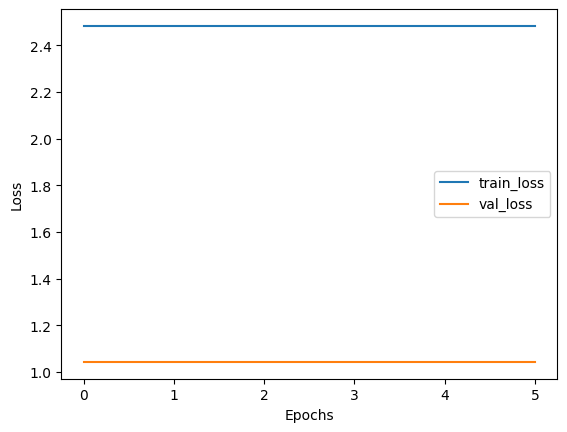

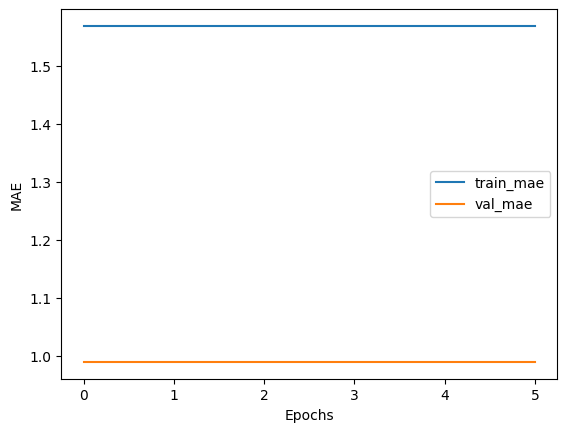

7/7 [==============================] - 1s 66ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/80
33/33 [==============================] - 5s 116ms/step - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0156 - val_mean_absolute_error: 0.1025
Epoch 2/80
33/33 [==============================] - 4s 110ms/step - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0154 - val_mean_absolute_error: 0.1001
Epoch 3/80
33/33 [==============================] - 4s 113ms/step - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0147 - val_mean_absolute_error: 0.0979
Epoch 4/80
33/33 [==============================] - 4s 112ms/step - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0145 - val_mean_absolute_error: 0.0963
Epoch 5/80
33/33 [==============================] - 4s 112ms/step - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0171 - val_mean_absolute_error: 0.1063
Epoch 6/80
33/33 [=====

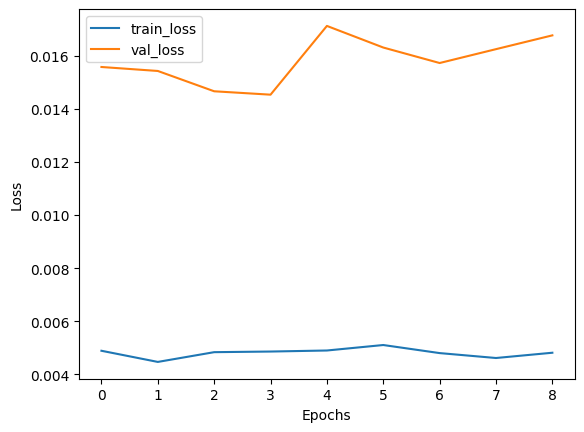

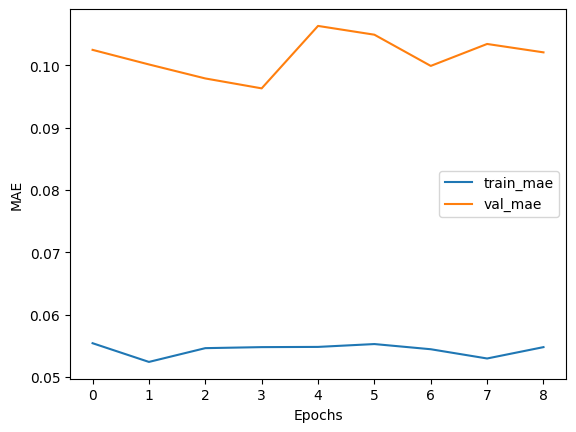

7/7 [==============================] - 0s 34ms/step
LSTM with Attention MAE: 3.3753510721663593
LSTM with Attention MSE: 25.101071941449643
Training Base model 12...
Epoch 1/80
33/33 [==============================] - 5s 117ms/step - loss: 5.8854e-05 - mean_absolute_error: 0.0056 - val_loss: 0.0116 - val_mean_absolute_error: 0.0654
Epoch 2/80
33/33 [==============================] - 4s 109ms/step - loss: 6.7677e-05 - mean_absolute_error: 0.0066 - val_loss: 0.0126 - val_mean_absolute_error: 0.0653
Epoch 3/80
33/33 [==============================] - 4s 107ms/step - loss: 1.9718e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0119 - val_mean_absolute_error: 0.0659
Epoch 4/80
33/33 [==============================] - 4s 108ms/step - loss: 8.4001e-05 - mean_absolute_error: 0.0077 - val_loss: 0.0131 - val_mean_absolute_error: 0.0666
Epoch 5/80
33/33 [==============================] - 4s 109ms/step - loss: 6.3353e-05 - mean_absolute_error: 0.0064 - val_loss: 0.0129 - val_mean_absolute_error: 0

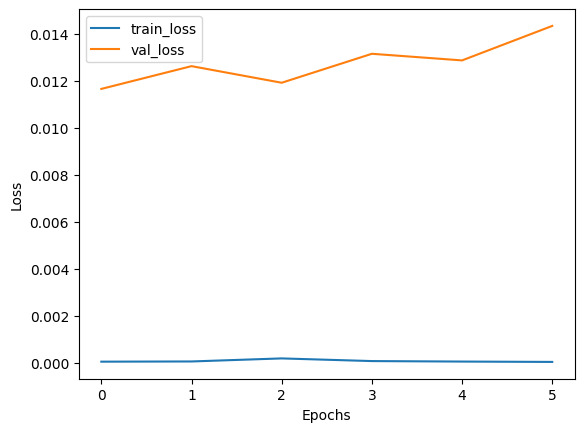

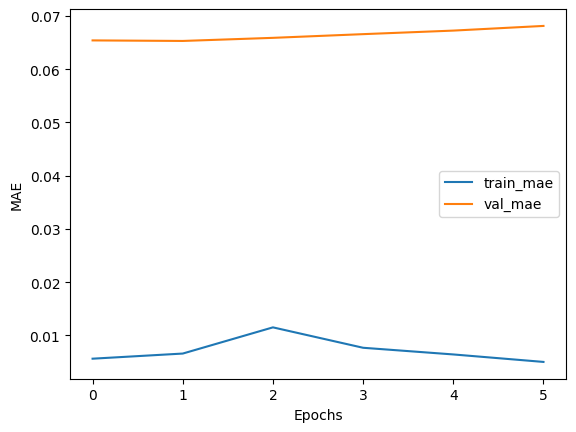

7/7 [==============================] - 0s 30ms/step
Base model 12 MAE: 15.646434912673891
Base model 12 MSE: 470.1110971620307
Training Vanilla LSTM layer...
Epoch 1/100
33/33 [==============================] - 3s 47ms/step - loss: 1.2054e-04 - mean_absolute_error: 0.0083 - val_loss: 0.0151 - val_mean_absolute_error: 0.0861
Epoch 2/100
33/33 [==============================] - 1s 39ms/step - loss: 1.2993e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0148 - val_mean_absolute_error: 0.0851
Epoch 3/100
33/33 [==============================] - 1s 39ms/step - loss: 1.2826e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0148 - val_mean_absolute_error: 0.0853
Epoch 4/100
33/33 [==============================] - 1s 39ms/step - loss: 1.3136e-04 - mean_absolute_error: 0.0089 - val_loss: 0.0146 - val_mean_absolute_error: 0.0845
Epoch 5/100
33/33 [==============================] - 1s 38ms/step - loss: 1.1957e-04 - mean_absolute_error: 0.0084 - val_loss: 0.0145 - val_mean_absolute_error: 0.0842
Ep

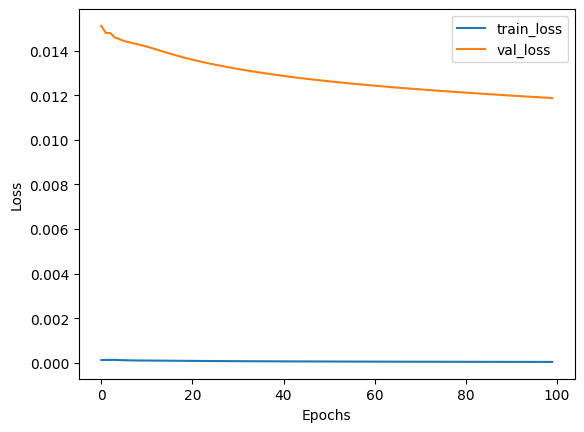

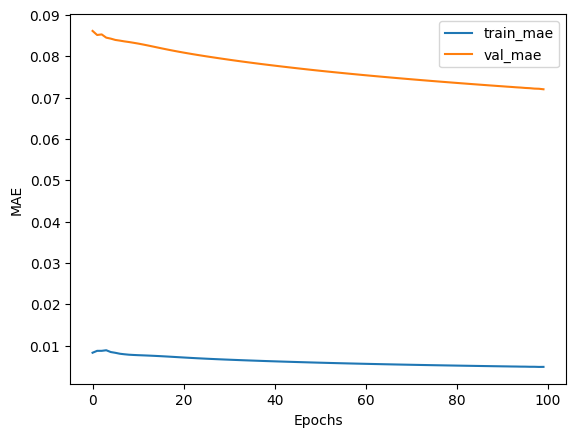

7/7 [==============================] - 0s 14ms/step
Vanilla LSTM layer MAE: 2.200899274457351
Vanilla LSTM layer MSE: 6.51094165339669
Training Base model 4...
Epoch 1/100
33/33 [==============================] - 4s 73ms/step - loss: 0.0058 - mean_absolute_error: 0.0608 - val_loss: 0.0152 - val_mean_absolute_error: 0.0809
Epoch 2/100
33/33 [==============================] - 2s 65ms/step - loss: 0.0066 - mean_absolute_error: 0.0628 - val_loss: 0.0145 - val_mean_absolute_error: 0.0807
Epoch 3/100
33/33 [==============================] - 2s 66ms/step - loss: 0.0058 - mean_absolute_error: 0.0600 - val_loss: 0.0163 - val_mean_absolute_error: 0.0841
Epoch 4/100
33/33 [==============================] - 2s 65ms/step - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0136 - val_mean_absolute_error: 0.0773
Epoch 5/100
33/33 [==============================] - 2s 65ms/step - loss: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0134 - val_mean_absolute_error: 0.0768
Epoch 6/100
33/33 [=

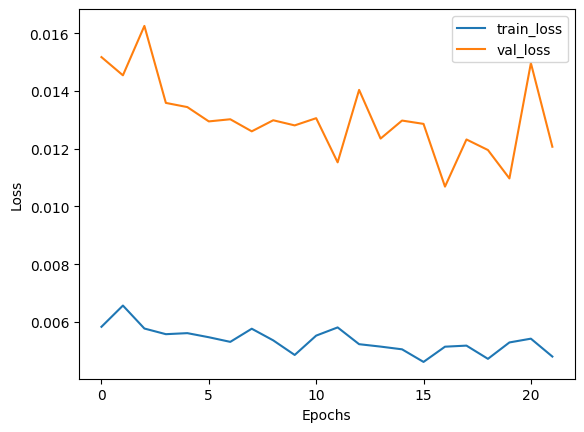

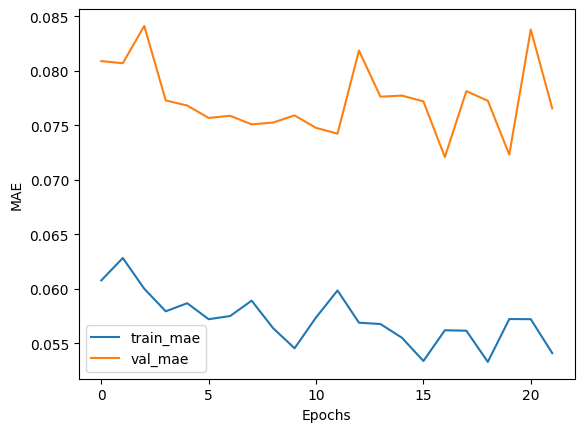

7/7 [==============================] - 0s 20ms/step
Base model 4 MAE: 1.964357122671105
Base model 4 MSE: 5.185905048736093
Training Gated Recurrent Unit (GRU)...
Epoch 1/100
33/33 [==============================] - 11s 62ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/100
33/33 [==============================] - 2s 55ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/100
33/33 [==============================] - 2s 53ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/100
33/33 [==============================] - 2s 53ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/100
33/33 [==============================] - 2s 54ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/100
33/3

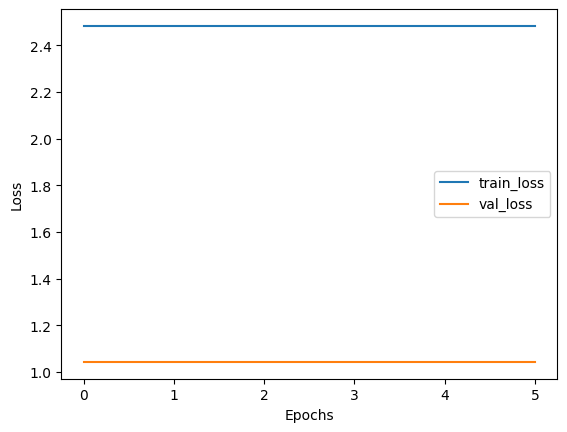

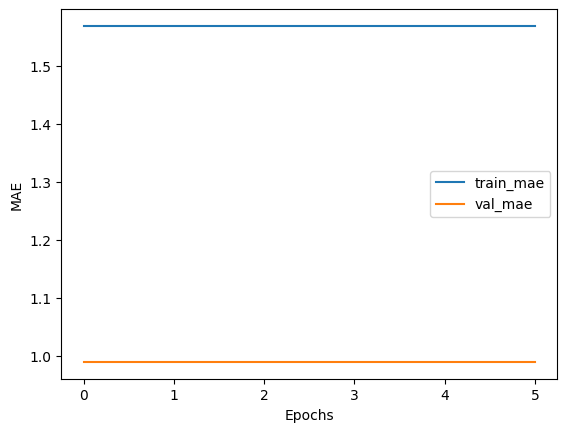

7/7 [==============================] - 0s 13ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/100
33/33 [==============================] - 6s 126ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/100
33/33 [==============================] - 4s 112ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/100
33/33 [==============================] - 4s 113ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/100
33/33 [==============================] - 4s 118ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/100
33/33 [==============================] - 4s 113ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absol

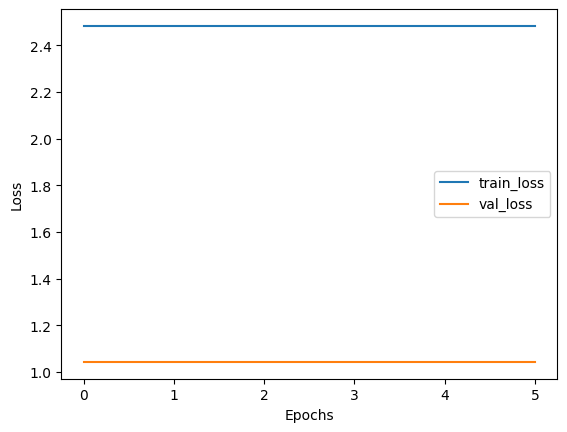

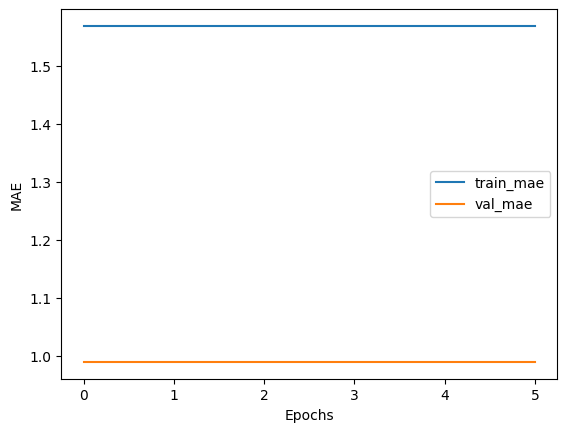

7/7 [==============================] - 1s 37ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/100
33/33 [==============================] - 11s 243ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/100
33/33 [==============================] - 7s 217ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/100
33/33 [==============================] - 7s 218ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/100
33/33 [==============================] - 7s 216ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/100
33/33 [==============================] - 7s 220ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0

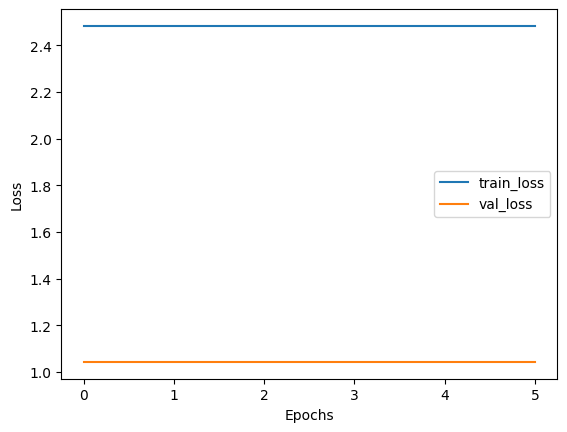

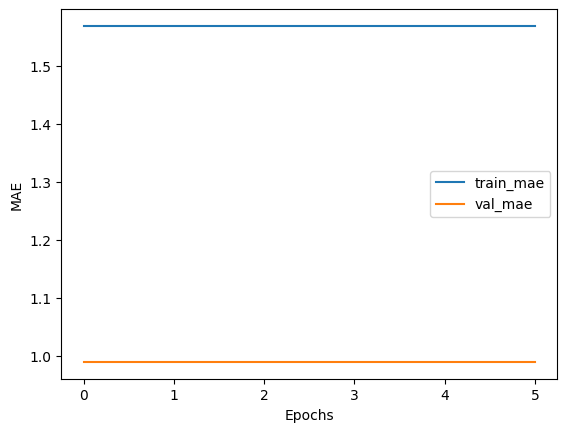

7/7 [==============================] - 1s 65ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/100
33/33 [==============================] - 5s 114ms/step - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0174 - val_mean_absolute_error: 0.1042
Epoch 2/100
33/33 [==============================] - 4s 108ms/step - loss: 0.0044 - mean_absolute_error: 0.0537 - val_loss: 0.0193 - val_mean_absolute_error: 0.1063
Epoch 3/100
33/33 [==============================] - 4s 107ms/step - loss: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0182 - val_mean_absolute_error: 0.1047
Epoch 4/100
33/33 [==============================] - 3s 106ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0191 - val_mean_absolute_error: 0.1119
Epoch 5/100
33/33 [==============================] - 4s 107ms/step - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0170 - val_mean_absolute_error: 0.1044
Epoch 6/100
33/33 

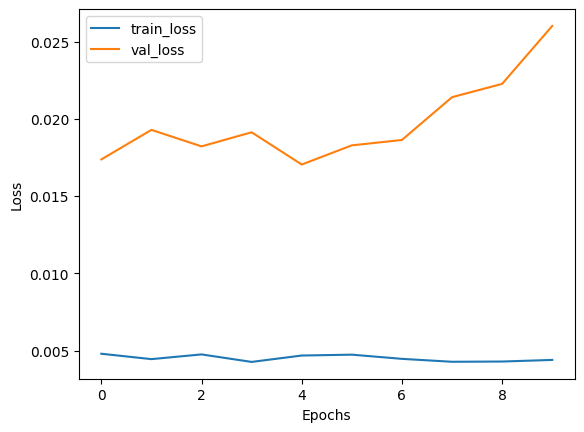

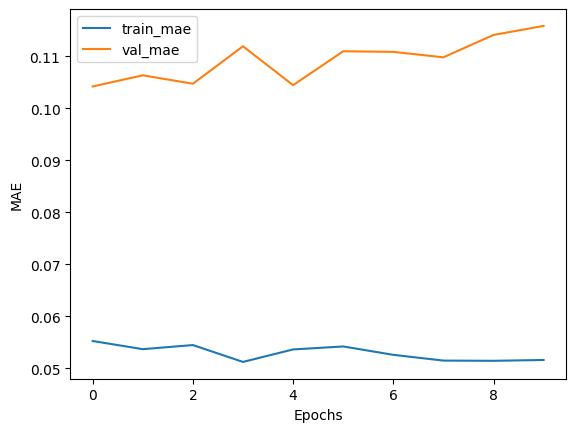

7/7 [==============================] - 0s 31ms/step
LSTM with Attention MAE: 5.2367431475911435
LSTM with Attention MSE: 54.30410409565946
Training Base model 12...
Epoch 1/100
33/33 [==============================] - 5s 111ms/step - loss: 5.3820e-05 - mean_absolute_error: 0.0056 - val_loss: 0.0142 - val_mean_absolute_error: 0.0682
Epoch 2/100
33/33 [==============================] - 4s 109ms/step - loss: 4.6462e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0125 - val_mean_absolute_error: 0.0672
Epoch 3/100
33/33 [==============================] - 4s 109ms/step - loss: 3.7451e-05 - mean_absolute_error: 0.0044 - val_loss: 0.0139 - val_mean_absolute_error: 0.0671
Epoch 4/100
33/33 [==============================] - 4s 107ms/step - loss: 9.6647e-05 - mean_absolute_error: 0.0075 - val_loss: 0.0120 - val_mean_absolute_error: 0.0655
Epoch 5/100
33/33 [==============================] - 4s 107ms/step - loss: 8.6153e-05 - mean_absolute_error: 0.0076 - val_loss: 0.0135 - val_mean_absolute_erro

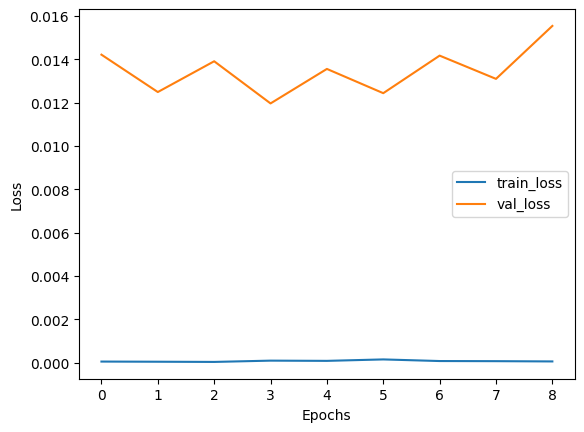

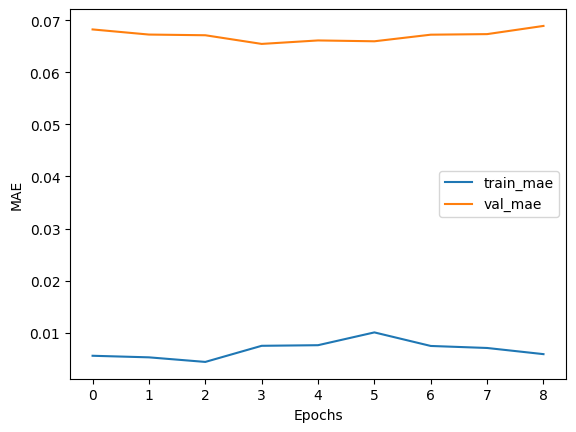

7/7 [==============================] - 0s 31ms/step
Base model 12 MAE: 16.688941046397215
Base model 12 MSE: 529.0412830942561
Training Vanilla LSTM layer...
Epoch 1/250
33/33 [==============================] - 3s 46ms/step - loss: 3.5389e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0119 - val_mean_absolute_error: 0.0721
Epoch 2/250
33/33 [==============================] - 1s 39ms/step - loss: 3.8738e-05 - mean_absolute_error: 0.0049 - val_loss: 0.0119 - val_mean_absolute_error: 0.0723
Epoch 3/250
33/33 [==============================] - 1s 40ms/step - loss: 3.5716e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0117 - val_mean_absolute_error: 0.0715
Epoch 4/250
33/33 [==============================] - 1s 40ms/step - loss: 2.8838e-05 - mean_absolute_error: 0.0041 - val_loss: 0.0119 - val_mean_absolute_error: 0.0719
Epoch 5/250
33/33 [==============================] - 1s 38ms/step - loss: 3.5498e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0116 - val_mean_absolute_error: 0.0709
Ep

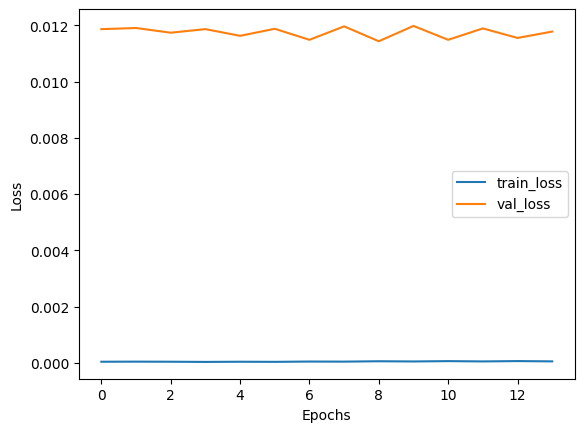

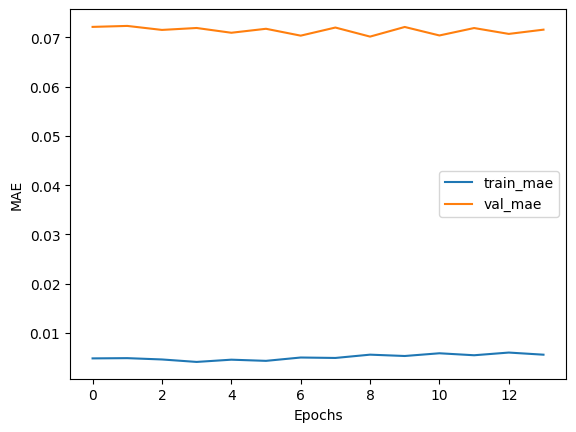

7/7 [==============================] - 0s 12ms/step
Vanilla LSTM layer MAE: 2.197667776777262
Vanilla LSTM layer MSE: 6.493613704869507
Training Base model 4...
Epoch 1/250
33/33 [==============================] - 4s 71ms/step - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0124 - val_mean_absolute_error: 0.0746
Epoch 2/250
33/33 [==============================] - 2s 65ms/step - loss: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0123 - val_mean_absolute_error: 0.0765
Epoch 3/250
33/33 [==============================] - 2s 64ms/step - loss: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0103 - val_mean_absolute_error: 0.0713
Epoch 4/250
33/33 [==============================] - 2s 65ms/step - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0150 - val_mean_absolute_error: 0.0872
Epoch 5/250
33/33 [==============================] - 2s 63ms/step - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0119 - val_mean_absolute_error: 0.0770
Epoch 6/250
33/33 [

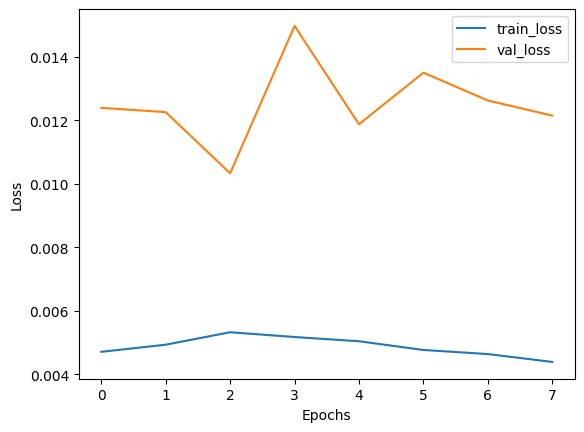

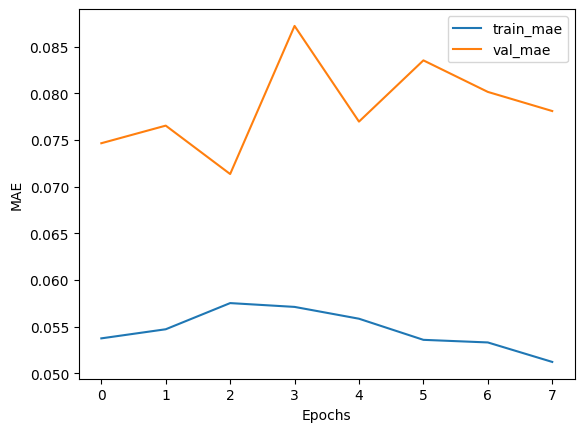

7/7 [==============================] - 0s 16ms/step
Base model 4 MAE: 1.9613691663342159
Base model 4 MSE: 5.170890991117751
Training Gated Recurrent Unit (GRU)...
Epoch 1/250
33/33 [==============================] - 3s 55ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/250
33/33 [==============================] - 2s 47ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/250
33/33 [==============================] - 1s 46ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/250
33/33 [==============================] - 2s 46ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/250
33/33 [==============================] - 2s 47ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/250
33/3

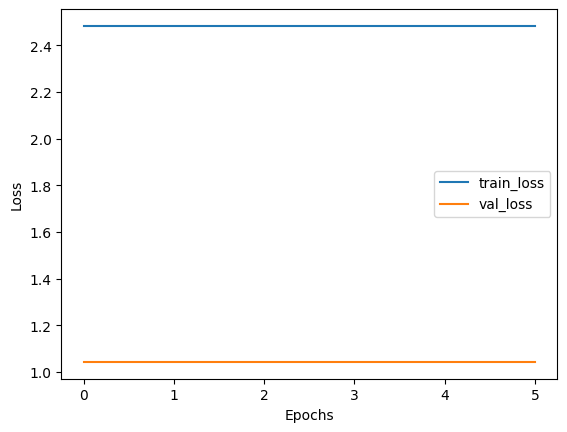

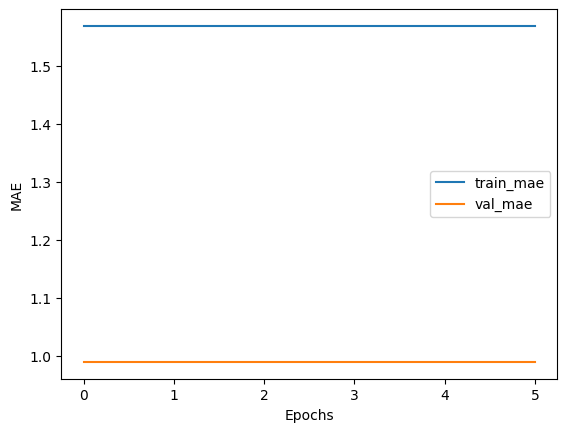

7/7 [==============================] - 0s 15ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/250
33/33 [==============================] - 6s 115ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/250
33/33 [==============================] - 3s 104ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/250
33/33 [==============================] - 3s 104ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/250
33/33 [==============================] - 3s 106ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/250
33/33 [==============================] - 4s 107ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absol

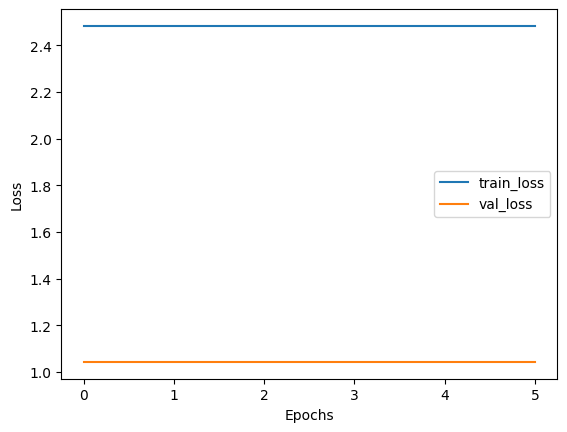

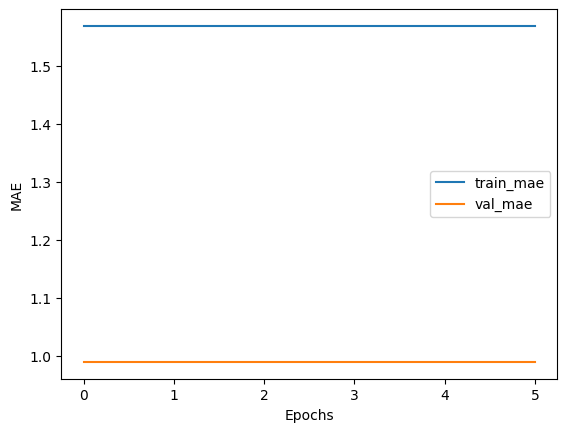

7/7 [==============================] - 1s 33ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/250
33/33 [==============================] - 10s 214ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/250
33/33 [==============================] - 6s 195ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/250
33/33 [==============================] - 6s 192ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/250
33/33 [==============================] - 6s 189ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/250
33/33 [==============================] - 6s 192ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0

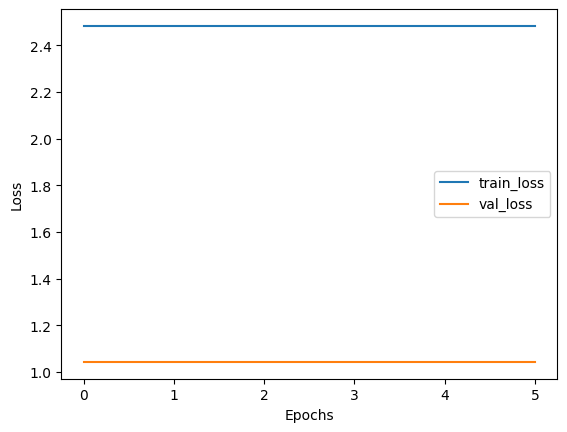

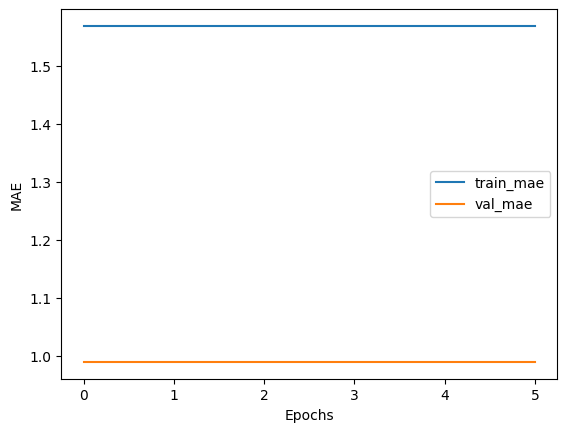

7/7 [==============================] - 1s 56ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/250
33/33 [==============================] - 6s 103ms/step - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0255 - val_mean_absolute_error: 0.1196
Epoch 2/250
33/33 [==============================] - 3s 96ms/step - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0210 - val_mean_absolute_error: 0.1132
Epoch 3/250
33/33 [==============================] - 3s 96ms/step - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0199 - val_mean_absolute_error: 0.1119
Epoch 4/250
33/33 [==============================] - 3s 101ms/step - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0226 - val_mean_absolute_error: 0.1154
Epoch 5/250
33/33 [==============================] - 3s 98ms/step - loss: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0227 - val_mean_absolute_error: 0.1161
Epoch 6/250
33/33 [==

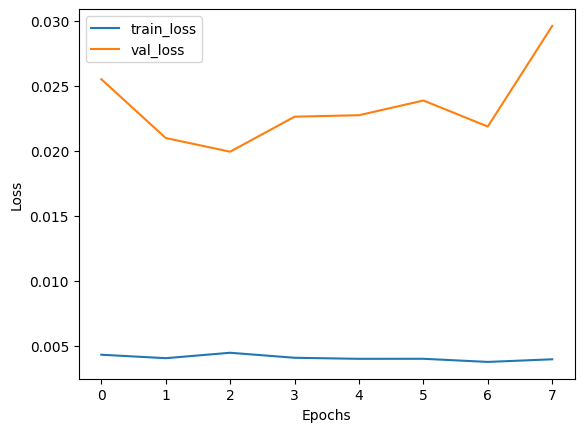

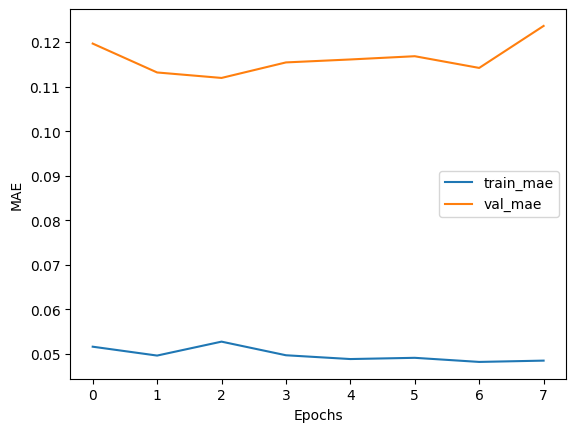

7/7 [==============================] - 0s 30ms/step
LSTM with Attention MAE: 5.228205172717267
LSTM with Attention MSE: 52.13147458978305
Training Base model 12...
Epoch 1/250
33/33 [==============================] - 5s 102ms/step - loss: 4.2789e-05 - mean_absolute_error: 0.0049 - val_loss: 0.0152 - val_mean_absolute_error: 0.0688
Epoch 2/250
33/33 [==============================] - 3s 99ms/step - loss: 4.3669e-05 - mean_absolute_error: 0.0052 - val_loss: 0.0128 - val_mean_absolute_error: 0.0677
Epoch 3/250
33/33 [==============================] - 3s 95ms/step - loss: 4.3803e-05 - mean_absolute_error: 0.0050 - val_loss: 0.0150 - val_mean_absolute_error: 0.0682
Epoch 4/250
33/33 [==============================] - 3s 95ms/step - loss: 6.1457e-05 - mean_absolute_error: 0.0058 - val_loss: 0.0126 - val_mean_absolute_error: 0.0660
Epoch 5/250
33/33 [==============================] - 3s 98ms/step - loss: 3.8959e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0139 - val_mean_absolute_error: 0.

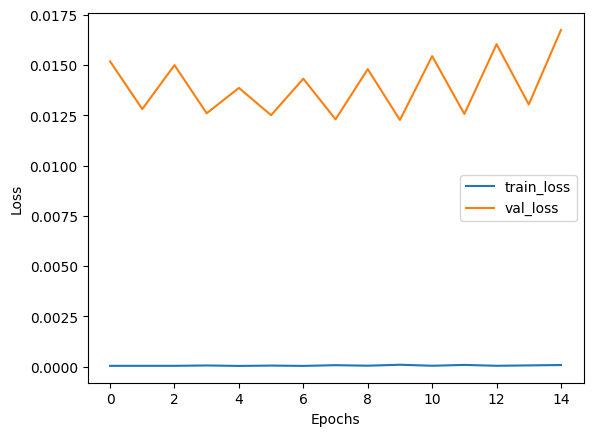

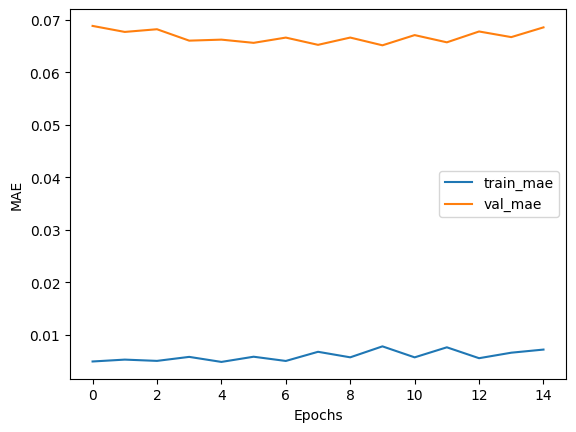

7/7 [==============================] - 0s 29ms/step
Base model 12 MAE: 18.549701790417465
Base model 12 MSE: 644.2860070542251
Training Vanilla LSTM layer...
Epoch 1/500
33/33 [==============================] - 2s 41ms/step - loss: 3.4598e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0118 - val_mean_absolute_error: 0.0716
Epoch 2/500
33/33 [==============================] - 1s 33ms/step - loss: 5.7763e-05 - mean_absolute_error: 0.0062 - val_loss: 0.0114 - val_mean_absolute_error: 0.0702
Epoch 3/500
33/33 [==============================] - 1s 33ms/step - loss: 4.2276e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0117 - val_mean_absolute_error: 0.0713
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 5.0506e-05 - mean_absolute_error: 0.0058 - val_loss: 0.0115 - val_mean_absolute_error: 0.0704
Epoch 5/500
33/33 [==============================] - 1s 34ms/step - loss: 3.4823e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0117 - val_mean_absolute_error: 0.0711
Ep

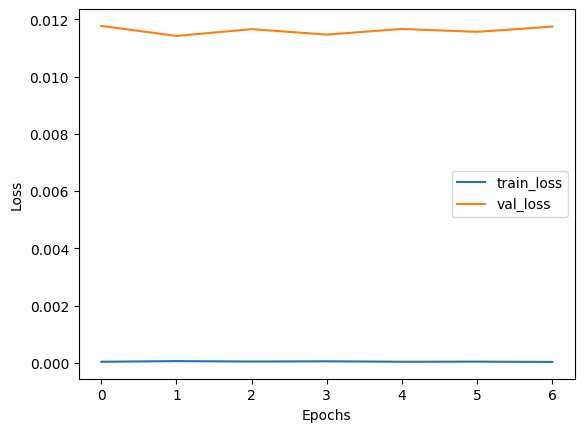

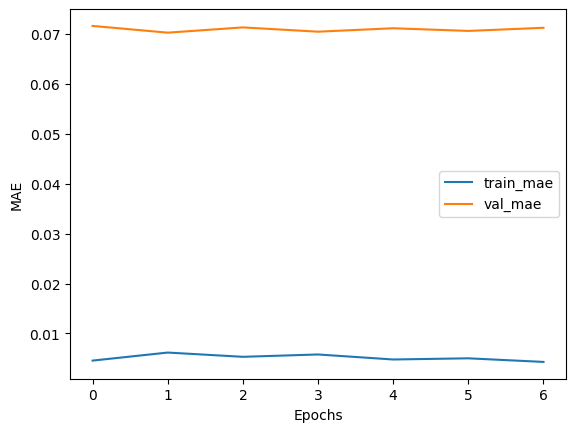

7/7 [==============================] - 0s 11ms/step
Vanilla LSTM layer MAE: 2.2047351225529965
Vanilla LSTM layer MSE: 6.530162686169448
Training Base model 4...
Epoch 1/500
33/33 [==============================] - 3s 64ms/step - loss: 0.0047 - mean_absolute_error: 0.0542 - val_loss: 0.0122 - val_mean_absolute_error: 0.0794
Epoch 2/500
33/33 [==============================] - 2s 55ms/step - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0122 - val_mean_absolute_error: 0.0793
Epoch 3/500
33/33 [==============================] - 2s 58ms/step - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0128 - val_mean_absolute_error: 0.0808
Epoch 4/500
33/33 [==============================] - 2s 56ms/step - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0113 - val_mean_absolute_error: 0.0758
Epoch 5/500
33/33 [==============================] - 2s 62ms/step - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0124 - val_mean_absolute_error: 0.0791
Epoch 6/500
33/33 

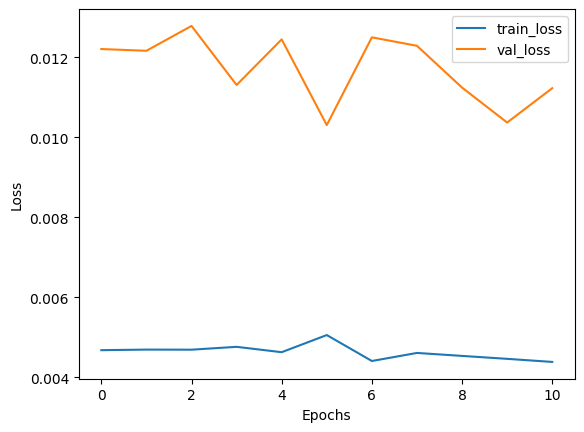

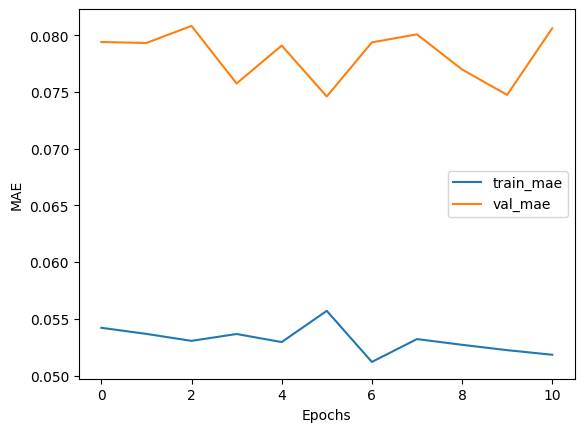

7/7 [==============================] - 0s 17ms/step
Base model 4 MAE: 1.9466653518819224
Base model 4 MSE: 5.132960326859768
Training Gated Recurrent Unit (GRU)...
Epoch 1/500
33/33 [==============================] - 3s 47ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/500
33/33 [==============================] - 1s 41ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/500
33/33 [==============================] - 1s 41ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/500
33/33 [==============================] - 1s 40ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/500
33/3

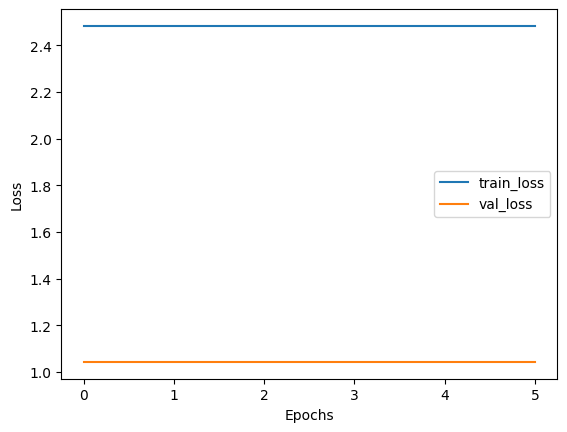

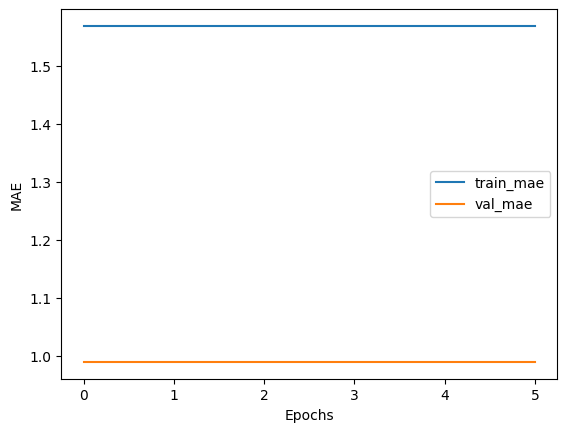

7/7 [==============================] - 0s 12ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/500
33/33 [==============================] - 5s 101ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/500
33/33 [==============================] - 3s 90ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/500
33/33 [==============================] - 3s 93ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/500
33/33 [==============================] - 3s 92ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/500
33/33 [==============================] - 3s 91ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_

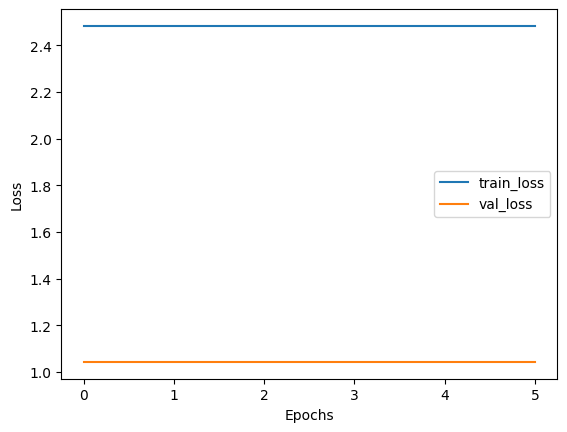

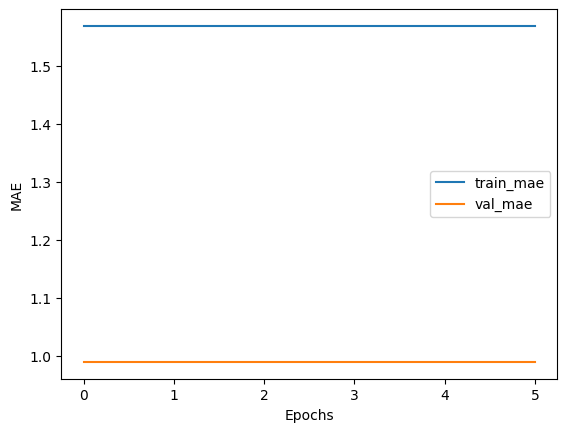

7/7 [==============================] - 1s 30ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/500
33/33 [==============================] - 9s 192ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/500
33/33 [==============================] - 6s 176ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/500
33/33 [==============================] - 6s 170ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/500
33/33 [==============================] - 6s 184ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/500
33/33 [==============================] - 6s 179ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.

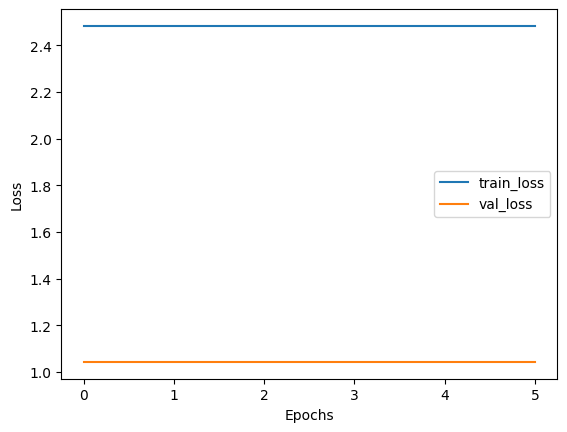

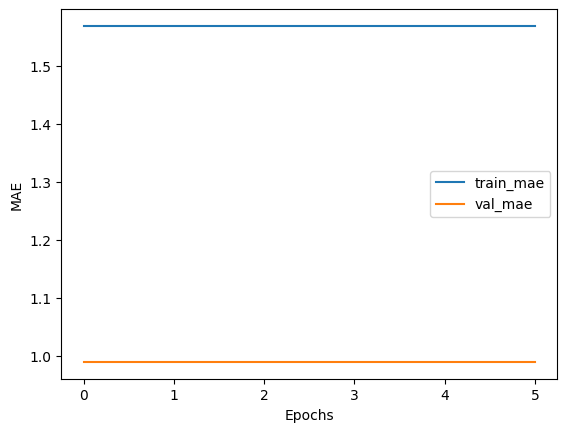

7/7 [==============================] - 1s 53ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/500
33/33 [==============================] - 4s 93ms/step - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0287 - val_mean_absolute_error: 0.1213
Epoch 2/500
33/33 [==============================] - 3s 87ms/step - loss: 0.0040 - mean_absolute_error: 0.0488 - val_loss: 0.0307 - val_mean_absolute_error: 0.1268
Epoch 3/500
33/33 [==============================] - 3s 88ms/step - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0273 - val_mean_absolute_error: 0.1247
Epoch 4/500
33/33 [==============================] - 3s 87ms/step - loss: 0.0038 - mean_absolute_error: 0.0472 - val_loss: 0.0257 - val_mean_absolute_error: 0.1184
Epoch 5/500
33/33 [==============================] - 3s 86ms/step - loss: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0279 - val_mean_absolute_error: 0.1162
Epoch 6/500
33/33 [====

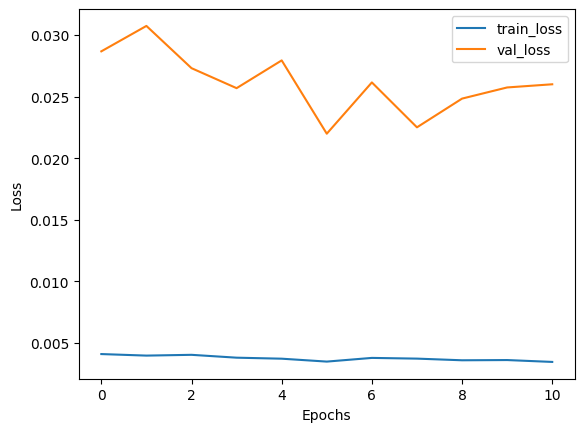

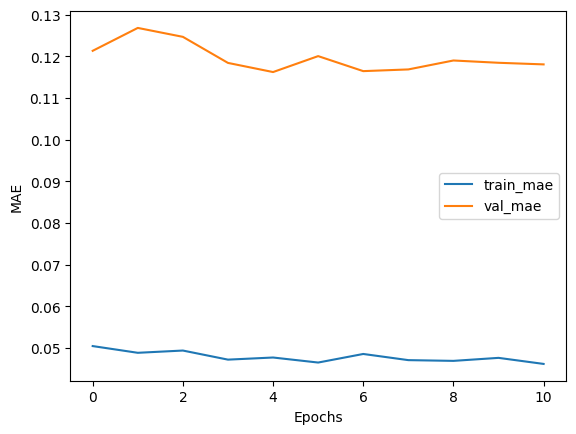

7/7 [==============================] - 0s 27ms/step
LSTM with Attention MAE: 5.09668560785699
LSTM with Attention MSE: 49.772305328781144
Training Base model 12...
Epoch 1/500
33/33 [==============================] - 4s 95ms/step - loss: 3.3839e-05 - mean_absolute_error: 0.0042 - val_loss: 0.0161 - val_mean_absolute_error: 0.0681
Epoch 2/500
33/33 [==============================] - 3s 86ms/step - loss: 4.3507e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0129 - val_mean_absolute_error: 0.0670
Epoch 3/500
33/33 [==============================] - 3s 87ms/step - loss: 7.2360e-05 - mean_absolute_error: 0.0068 - val_loss: 0.0157 - val_mean_absolute_error: 0.0684
Epoch 4/500
33/33 [==============================] - 3s 93ms/step - loss: 4.0837e-05 - mean_absolute_error: 0.0050 - val_loss: 0.0138 - val_mean_absolute_error: 0.0669
Epoch 5/500
33/33 [==============================] - 3s 93ms/step - loss: 3.6497e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0158 - val_mean_absolute_error: 0.0

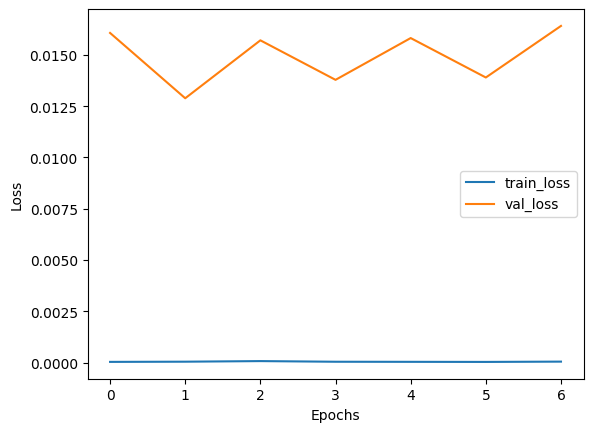

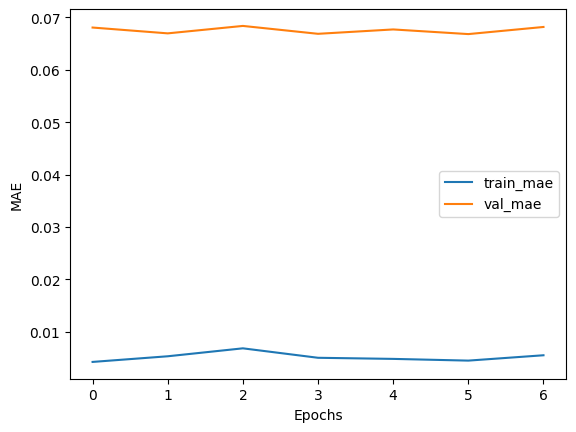

7/7 [==============================] - 0s 26ms/step
Base model 12 MAE: 19.041838284989137
Base model 12 MSE: 673.7150789921252
Training Vanilla LSTM layer...
Epoch 1/800
33/33 [==============================] - 2s 39ms/step - loss: 3.6542e-05 - mean_absolute_error: 0.0050 - val_loss: 0.0117 - val_mean_absolute_error: 0.0711
Epoch 2/800
33/33 [==============================] - 1s 31ms/step - loss: 3.2208e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0117 - val_mean_absolute_error: 0.0711
Epoch 3/800
33/33 [==============================] - 1s 31ms/step - loss: 2.4322e-05 - mean_absolute_error: 0.0038 - val_loss: 0.0117 - val_mean_absolute_error: 0.0709
Epoch 4/800
33/33 [==============================] - 1s 32ms/step - loss: 2.3764e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0116 - val_mean_absolute_error: 0.0703
Epoch 5/800
33/33 [==============================] - 1s 31ms/step - loss: 2.0793e-05 - mean_absolute_error: 0.0034 - val_loss: 0.0117 - val_mean_absolute_error: 0.0705
Ep

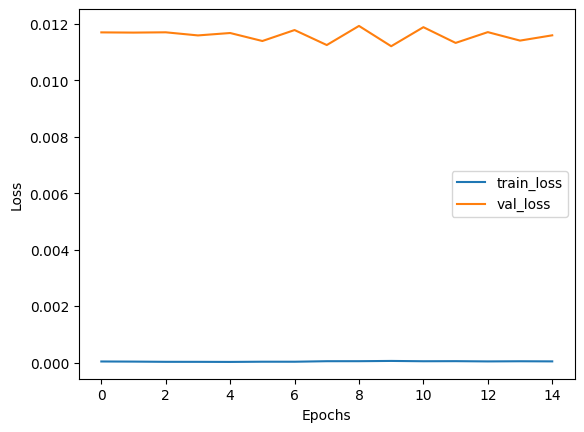

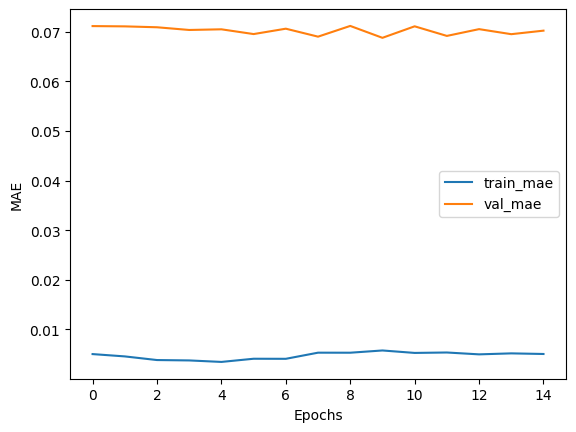

7/7 [==============================] - 0s 10ms/step
Vanilla LSTM layer MAE: 2.1947883237090604
Vanilla LSTM layer MSE: 6.483383296489606
Training Base model 4...
Epoch 1/800
33/33 [==============================] - 3s 57ms/step - loss: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0109 - val_mean_absolute_error: 0.0781
Epoch 2/800
33/33 [==============================] - 2s 49ms/step - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0104 - val_mean_absolute_error: 0.0774
Epoch 3/800
33/33 [==============================] - 2s 49ms/step - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0128 - val_mean_absolute_error: 0.0856
Epoch 4/800
33/33 [==============================] - 2s 50ms/step - loss: 0.0044 - mean_absolute_error: 0.0509 - val_loss: 0.0110 - val_mean_absolute_error: 0.0775
Epoch 5/800
33/33 [==============================] - 2s 49ms/step - loss: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0115 - val_mean_absolute_error: 0.0789
Epoch 6/800
33/33 

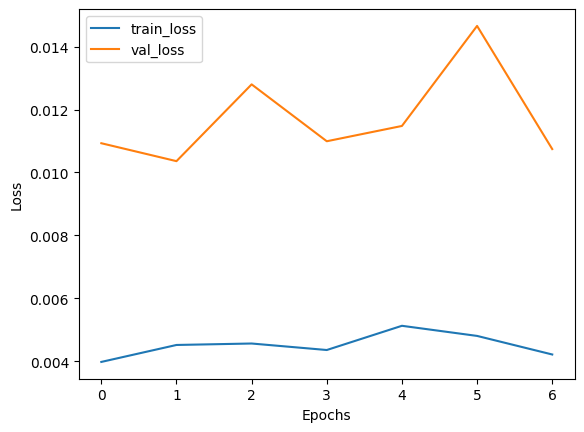

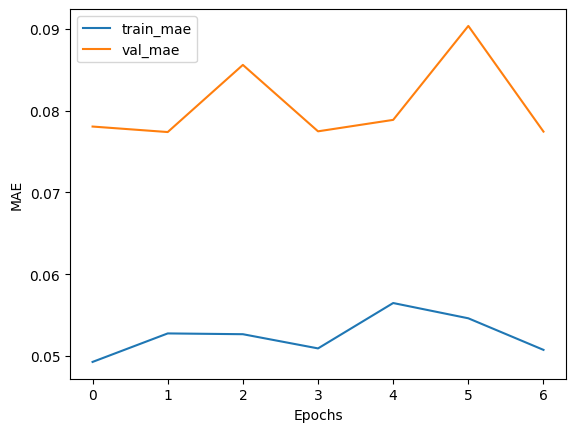

7/7 [==============================] - 0s 13ms/step
Base model 4 MAE: 1.9566213938066839
Base model 4 MSE: 5.176932607298839
Training Gated Recurrent Unit (GRU)...
Epoch 1/800
33/33 [==============================] - 3s 45ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/800
33/33 [==============================] - 1s 36ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/800
33/33 [==============================] - 1s 36ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/800
33/33 [==============================] - 1s 36ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/800
33/33 [==============================] - 1s 39ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/800
33/3

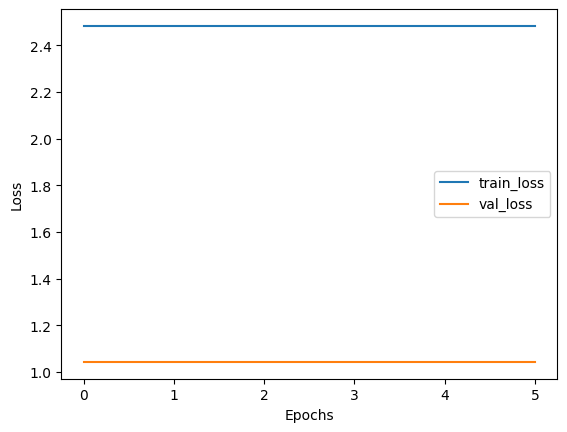

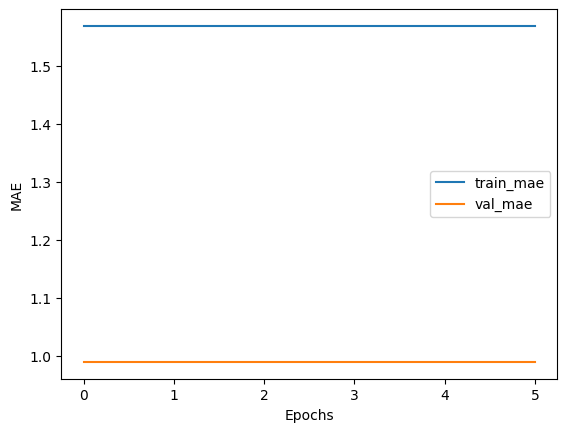

7/7 [==============================] - 0s 11ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/800
33/33 [==============================] - 5s 93ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/800
33/33 [==============================] - 3s 80ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/800
33/33 [==============================] - 3s 79ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/800
33/33 [==============================] - 3s 79ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/800
33/33 [==============================] - 3s 79ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_e

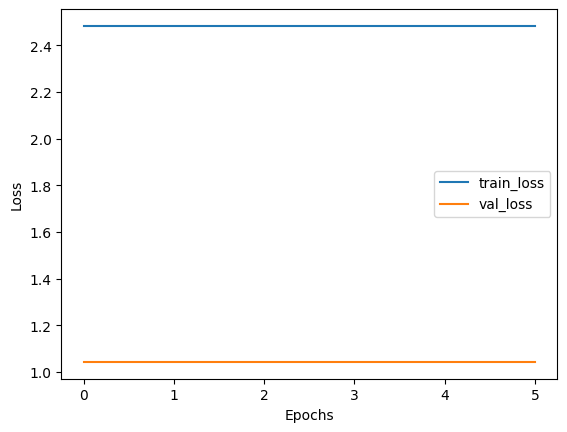

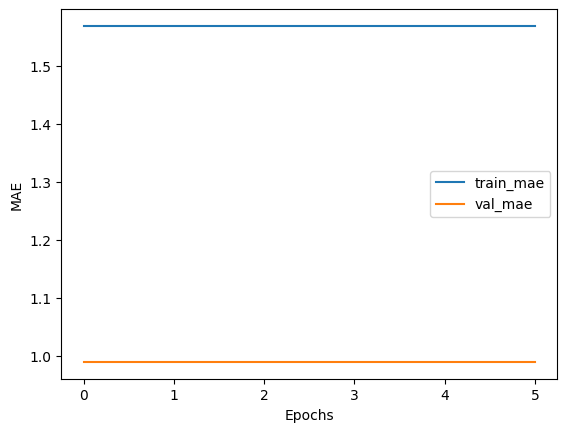

7/7 [==============================] - 1s 24ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/800
33/33 [==============================] - 10s 174ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/800
33/33 [==============================] - 5s 156ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/800
33/33 [==============================] - 5s 156ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/800
33/33 [==============================] - 5s 153ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/800
33/33 [==============================] - 5s 154ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0

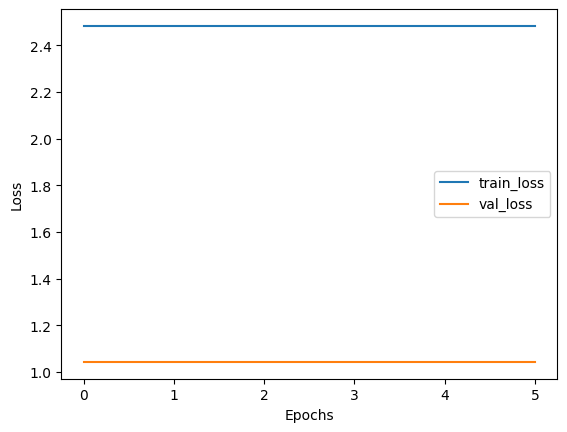

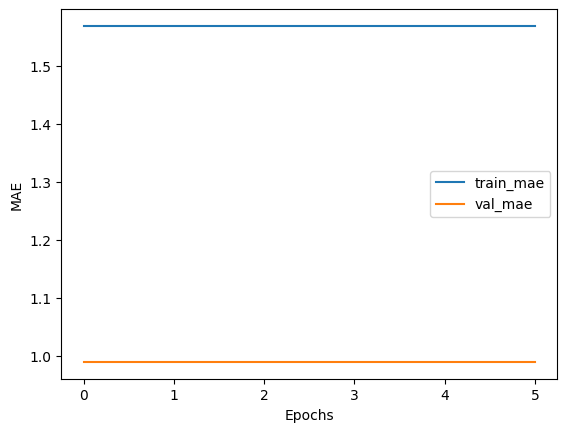

7/7 [==============================] - 1s 44ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/800
33/33 [==============================] - 4s 88ms/step - loss: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0284 - val_mean_absolute_error: 0.1205
Epoch 2/800
33/33 [==============================] - 2s 76ms/step - loss: 0.0037 - mean_absolute_error: 0.0474 - val_loss: 0.0354 - val_mean_absolute_error: 0.1253
Epoch 3/800
33/33 [==============================] - 2s 76ms/step - loss: 0.0038 - mean_absolute_error: 0.0488 - val_loss: 0.0259 - val_mean_absolute_error: 0.1210
Epoch 4/800
33/33 [==============================] - 3s 78ms/step - loss: 0.0035 - mean_absolute_error: 0.0456 - val_loss: 0.0307 - val_mean_absolute_error: 0.1230
Epoch 5/800
33/33 [==============================] - 3s 79ms/step - loss: 0.0032 - mean_absolute_error: 0.0443 - val_loss: 0.0293 - val_mean_absolute_error: 0.1197
Epoch 6/800
33/33 [====

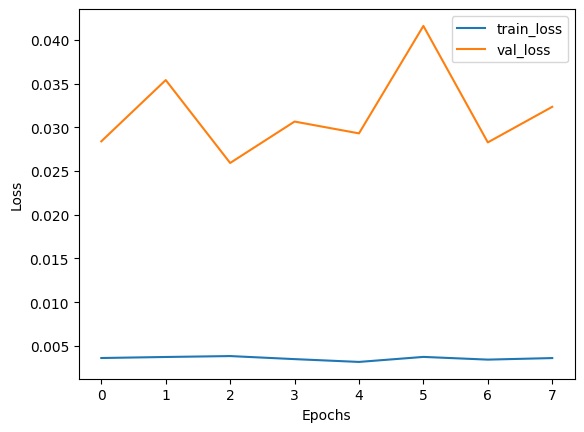

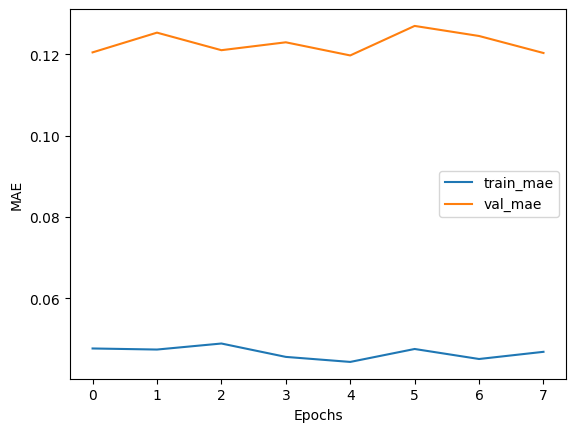

7/7 [==============================] - 0s 20ms/step
LSTM with Attention MAE: 5.892015875479005
LSTM with Attention MSE: 64.68824501490946
Training Base model 12...
Epoch 1/800
33/33 [==============================] - 4s 86ms/step - loss: 2.5944e-05 - mean_absolute_error: 0.0038 - val_loss: 0.0161 - val_mean_absolute_error: 0.0679
Epoch 2/800
33/33 [==============================] - 2s 74ms/step - loss: 2.9174e-05 - mean_absolute_error: 0.0041 - val_loss: 0.0128 - val_mean_absolute_error: 0.0664
Epoch 3/800
33/33 [==============================] - 2s 76ms/step - loss: 5.2830e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0161 - val_mean_absolute_error: 0.0685
Epoch 4/800
33/33 [==============================] - 2s 74ms/step - loss: 3.2211e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0140 - val_mean_absolute_error: 0.0662
Epoch 5/800
33/33 [==============================] - 3s 76ms/step - loss: 1.6217e-05 - mean_absolute_error: 0.0028 - val_loss: 0.0162 - val_mean_absolute_error: 0.0

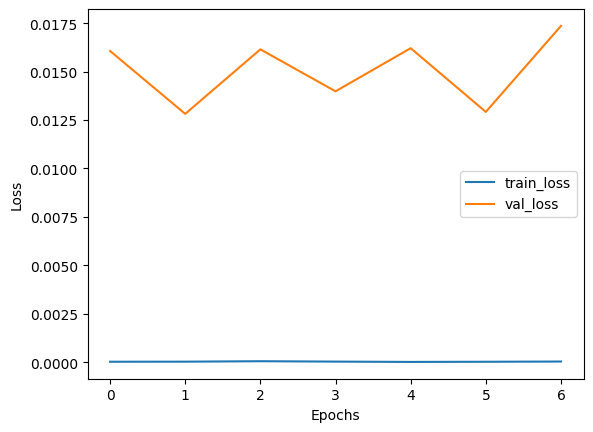

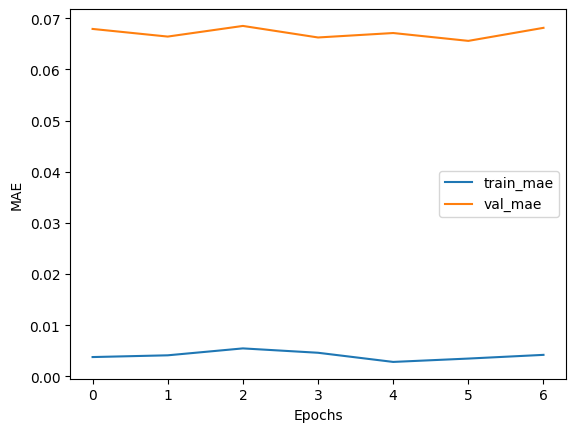

7/7 [==============================] - 0s 24ms/step
Base model 12 MAE: 19.665055544691928
Base model 12 MSE: 714.2793091514245
Training Vanilla LSTM layer...
Epoch 1/1000
33/33 [==============================] - 2s 37ms/step - loss: 2.9617e-05 - mean_absolute_error: 0.0042 - val_loss: 0.0116 - val_mean_absolute_error: 0.0703
Epoch 2/1000
33/33 [==============================] - 1s 28ms/step - loss: 4.9254e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0113 - val_mean_absolute_error: 0.0694
Epoch 3/1000
33/33 [==============================] - 1s 30ms/step - loss: 3.8970e-05 - mean_absolute_error: 0.0051 - val_loss: 0.0115 - val_mean_absolute_error: 0.0702
Epoch 4/1000
33/33 [==============================] - 1s 30ms/step - loss: 4.5864e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0113 - val_mean_absolute_error: 0.0694
Epoch 5/1000
33/33 [==============================] - 1s 29ms/step - loss: 3.3118e-05 - mean_absolute_error: 0.0047 - val_loss: 0.0115 - val_mean_absolute_error: 0.07

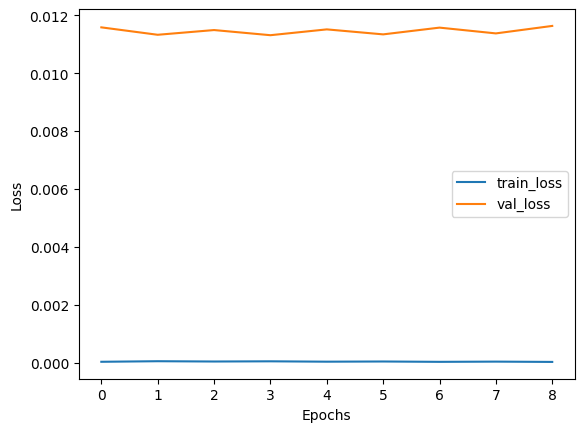

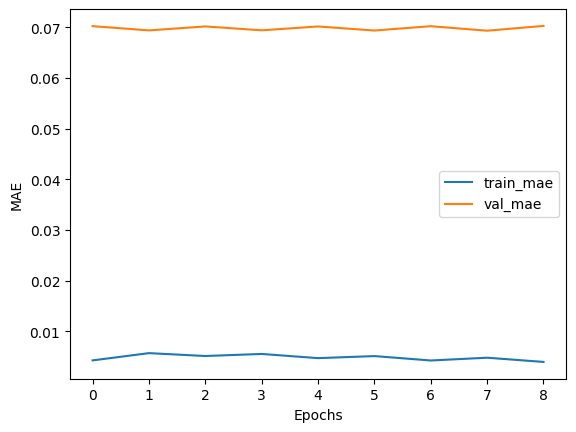

7/7 [==============================] - 0s 9ms/step
Vanilla LSTM layer MAE: 2.202525600149114
Vanilla LSTM layer MSE: 6.521166250645193
Training Base model 4...
Epoch 1/1000
33/33 [==============================] - 3s 52ms/step - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0110 - val_mean_absolute_error: 0.0769
Epoch 2/1000
33/33 [==============================] - 1s 42ms/step - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0128 - val_mean_absolute_error: 0.0841
Epoch 3/1000
33/33 [==============================] - 1s 43ms/step - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0126 - val_mean_absolute_error: 0.0828
Epoch 4/1000
33/33 [==============================] - 1s 43ms/step - loss: 0.0043 - mean_absolute_error: 0.0518 - val_loss: 0.0132 - val_mean_absolute_error: 0.0834
Epoch 5/1000
33/33 [==============================] - 1s 43ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0118 - val_mean_absolute_error: 0.0797
Epoch 6/1000
33

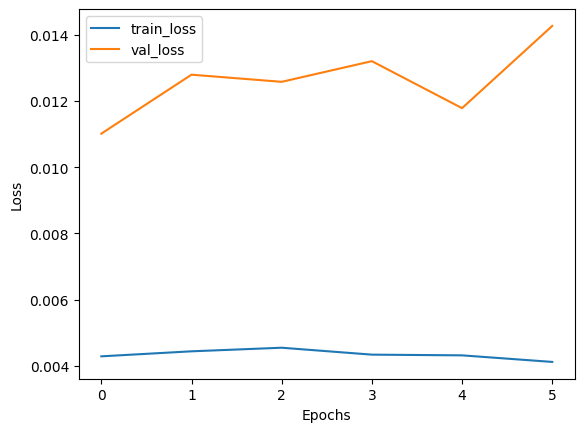

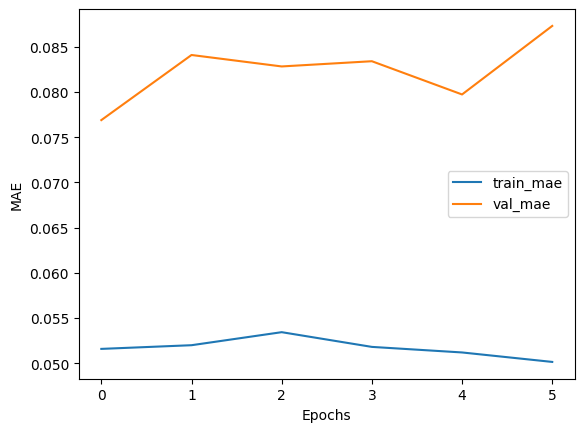

7/7 [==============================] - 0s 12ms/step
Base model 4 MAE: 2.0323255912722096
Base model 4 MSE: 5.516105278485434
Training Gated Recurrent Unit (GRU)...
Epoch 1/1000
33/33 [==============================] - 3s 43ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1000
33/33 [==============================] - 1s 32ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1000
33/33 [==============================] - 1s 32ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1000
33/33 [==============================] - 1s 32ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1000
33/33 [==============================] - 1s 32ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/100

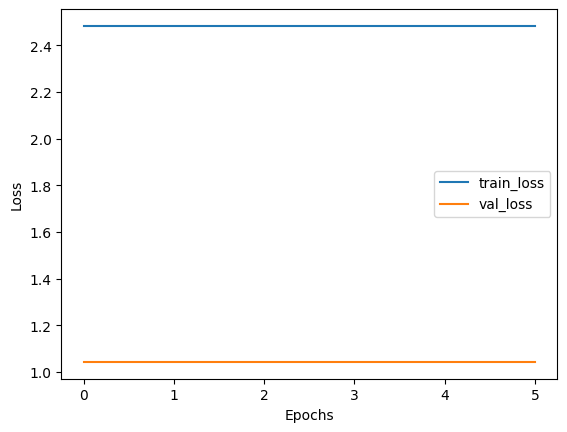

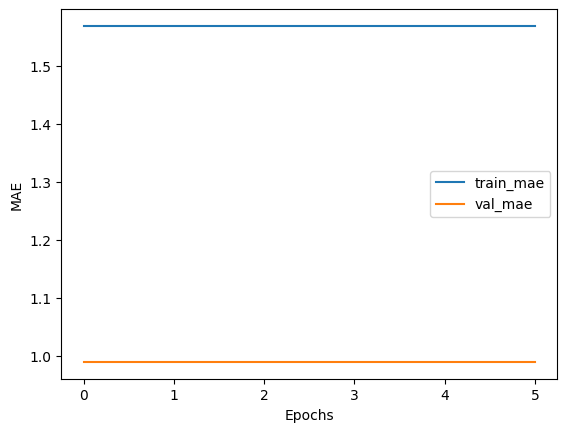

7/7 [==============================] - 0s 11ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/1000
33/33 [==============================] - 5s 75ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1000
33/33 [==============================] - 2s 60ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1000
33/33 [==============================] - 2s 61ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1000
33/33 [==============================] - 2s 59ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1000
33/33 [==============================] - 2s 64ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absol

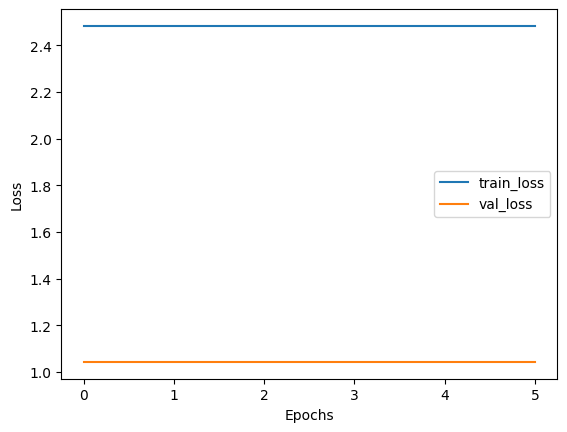

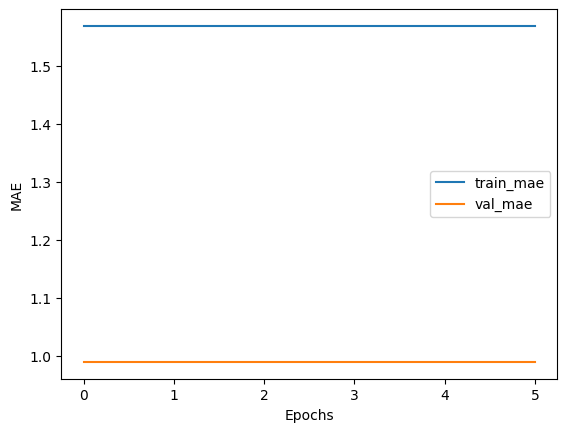

7/7 [==============================] - 1s 20ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/1000
33/33 [==============================] - 7s 116ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1000
33/33 [==============================] - 3s 94ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1000
33/33 [==============================] - 3s 93ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1000
33/33 [==============================] - 3s 94ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1000
33/33 [==============================] - 3s 96ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0

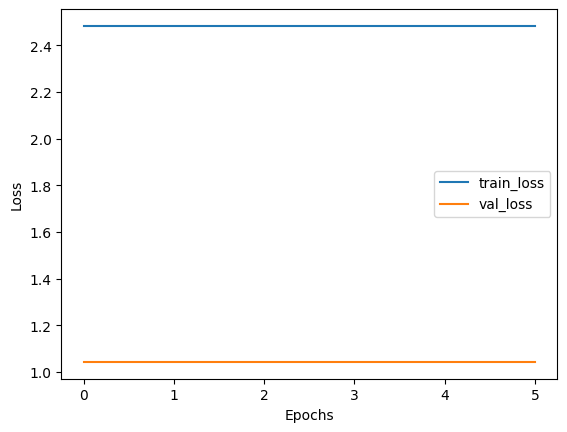

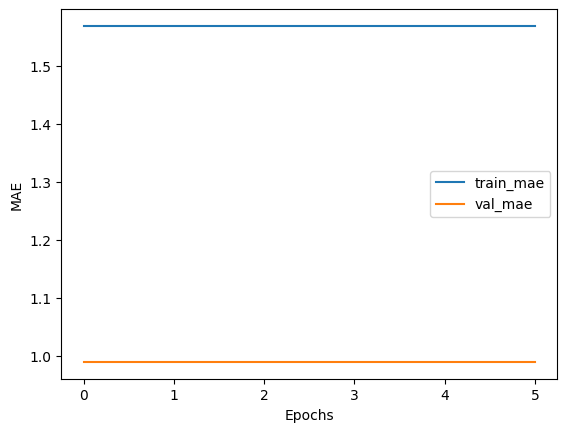

7/7 [==============================] - 1s 26ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/1000
33/33 [==============================] - 3s 55ms/step - loss: 0.0034 - mean_absolute_error: 0.0459 - val_loss: 0.0320 - val_mean_absolute_error: 0.1223
Epoch 2/1000
33/33 [==============================] - 2s 48ms/step - loss: 0.0033 - mean_absolute_error: 0.0451 - val_loss: 0.0272 - val_mean_absolute_error: 0.1223
Epoch 3/1000
33/33 [==============================] - 2s 47ms/step - loss: 0.0035 - mean_absolute_error: 0.0466 - val_loss: 0.0274 - val_mean_absolute_error: 0.1208
Epoch 4/1000
33/33 [==============================] - 2s 48ms/step - loss: 0.0032 - mean_absolute_error: 0.0448 - val_loss: 0.0312 - val_mean_absolute_error: 0.1230
Epoch 5/1000
33/33 [==============================] - 2s 47ms/step - loss: 0.0032 - mean_absolute_error: 0.0438 - val_loss: 0.0265 - val_mean_absolute_error: 0.1202
Epoch 6/1000
33/33

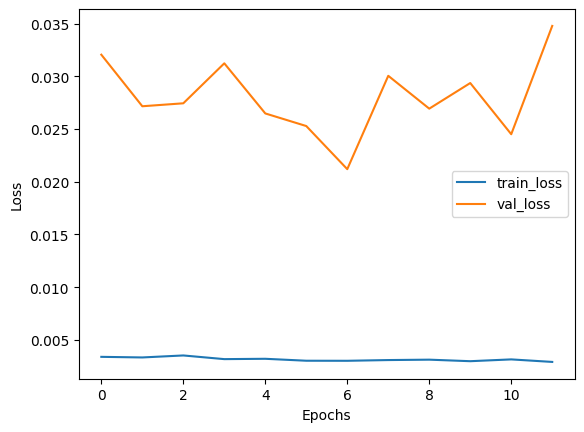

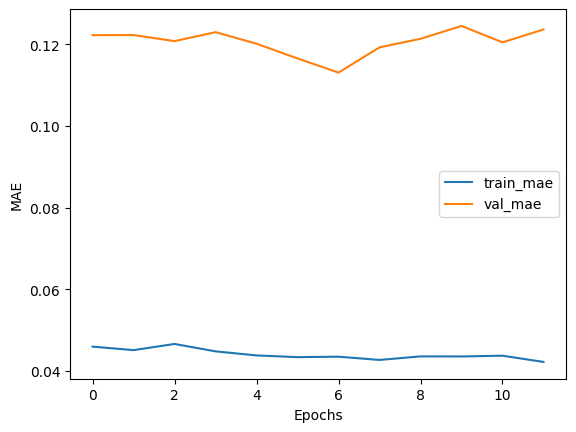

7/7 [==============================] - 0s 13ms/step
LSTM with Attention MAE: 6.156490791425176
LSTM with Attention MSE: 70.51519801051802
Training Base model 12...
Epoch 1/1000
33/33 [==============================] - 3s 54ms/step - loss: 4.3011e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0160 - val_mean_absolute_error: 0.0670
Epoch 2/1000
33/33 [==============================] - 2s 49ms/step - loss: 2.5531e-05 - mean_absolute_error: 0.0036 - val_loss: 0.0130 - val_mean_absolute_error: 0.0654
Epoch 3/1000
33/33 [==============================] - 2s 46ms/step - loss: 3.5955e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0179 - val_mean_absolute_error: 0.0682
Epoch 4/1000
33/33 [==============================] - 2s 46ms/step - loss: 3.0218e-05 - mean_absolute_error: 0.0041 - val_loss: 0.0132 - val_mean_absolute_error: 0.0659
Epoch 5/1000
33/33 [==============================] - 2s 46ms/step - loss: 4.2701e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0174 - val_mean_absolute_error

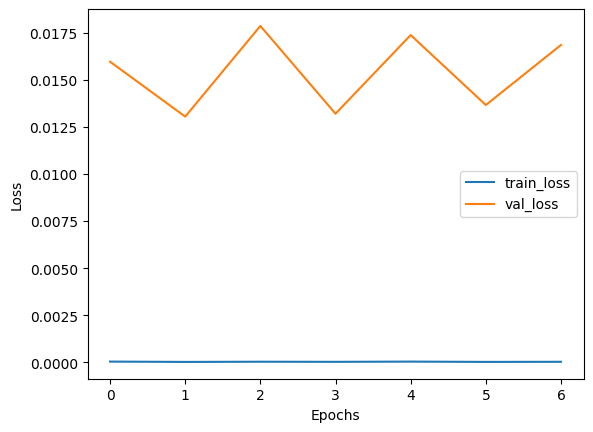

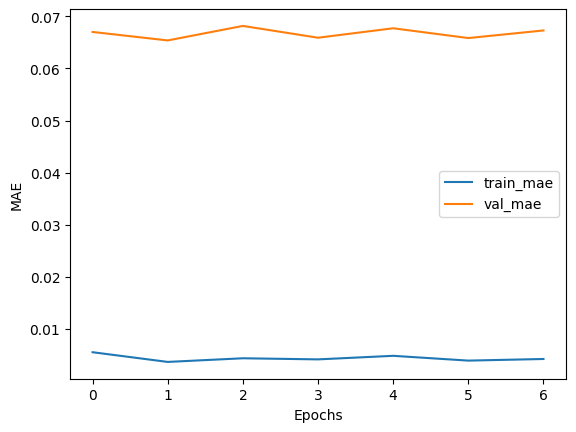

7/7 [==============================] - 0s 13ms/step
Base model 12 MAE: 20.338449825702988
Base model 12 MSE: 760.3253920626601
Training Vanilla LSTM layer...
Epoch 1/1200
33/33 [==============================] - 2s 27ms/step - loss: 3.1634e-05 - mean_absolute_error: 0.0047 - val_loss: 0.0116 - val_mean_absolute_error: 0.0704
Epoch 2/1200
33/33 [==============================] - 1s 18ms/step - loss: 3.2324e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0115 - val_mean_absolute_error: 0.0698
Epoch 3/1200
33/33 [==============================] - 1s 19ms/step - loss: 2.1748e-05 - mean_absolute_error: 0.0036 - val_loss: 0.0116 - val_mean_absolute_error: 0.0699
Epoch 4/1200
33/33 [==============================] - 1s 19ms/step - loss: 2.5652e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0113 - val_mean_absolute_error: 0.0689
Epoch 5/1200
33/33 [==============================] - 1s 18ms/step - loss: 2.1408e-05 - mean_absolute_error: 0.0035 - val_loss: 0.0116 - val_mean_absolute_error: 0.06

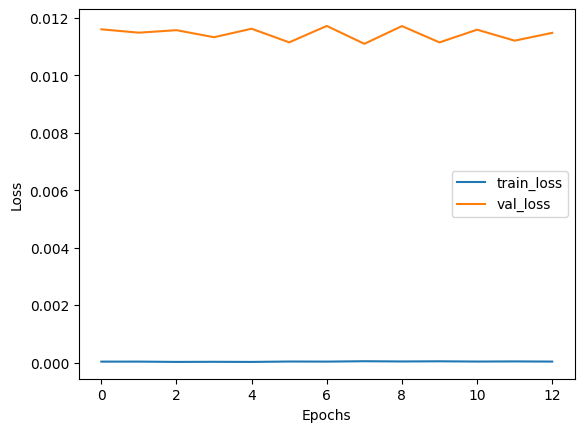

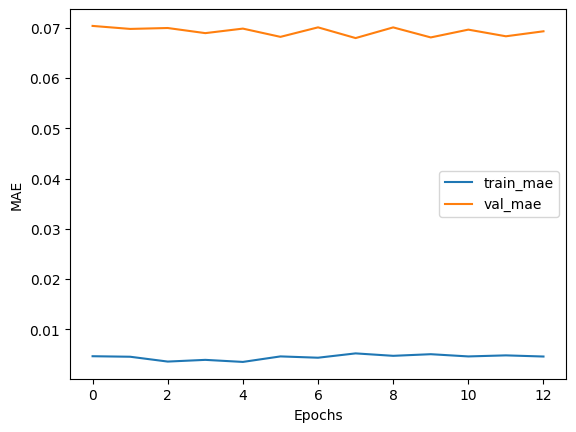

7/7 [==============================] - 0s 5ms/step
Vanilla LSTM layer MAE: 2.1938514181027857
Vanilla LSTM layer MSE: 6.481681726194192
Training Base model 4...
Epoch 1/1200
33/33 [==============================] - 2s 36ms/step - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0147 - val_mean_absolute_error: 0.0887
Epoch 2/1200
33/33 [==============================] - 1s 27ms/step - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0119 - val_mean_absolute_error: 0.0815
Epoch 3/1200
33/33 [==============================] - 1s 27ms/step - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0119 - val_mean_absolute_error: 0.0808
Epoch 4/1200
33/33 [==============================] - 1s 28ms/step - loss: 0.0040 - mean_absolute_error: 0.0503 - val_loss: 0.0126 - val_mean_absolute_error: 0.0829
Epoch 5/1200
33/33 [==============================] - 1s 27ms/step - loss: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0112 - val_mean_absolute_error: 0.0791
Epoch 6/1200
3

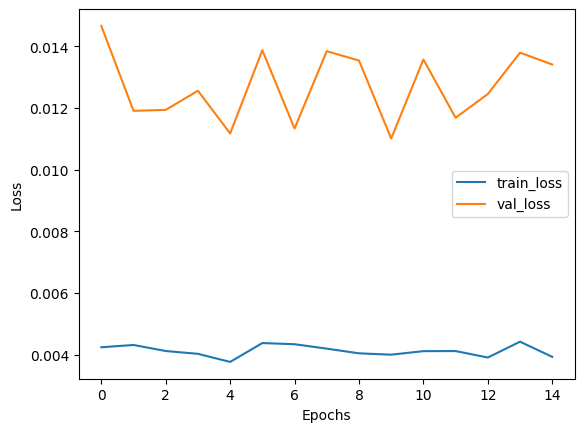

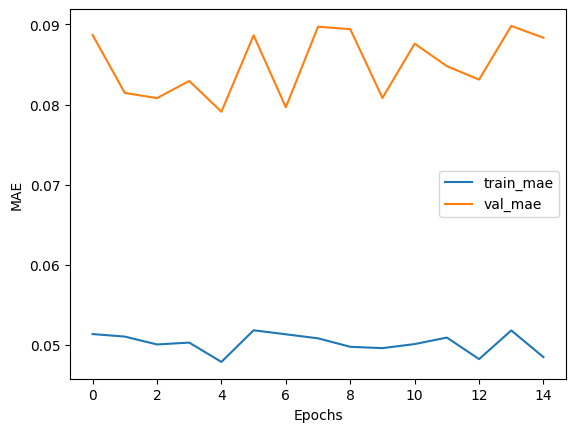

7/7 [==============================] - 0s 8ms/step
Base model 4 MAE: 2.019820808409072
Base model 4 MSE: 5.4826209791089235
Training Gated Recurrent Unit (GRU)...
Epoch 1/1200
33/33 [==============================] - 2s 35ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1200
33/33 [==============================] - 1s 27ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1200
33/33 [==============================] - 1s 27ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1200
33/33 [==============================] - 1s 27ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1200
33/33 [==============================] - 1s 26ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/1200

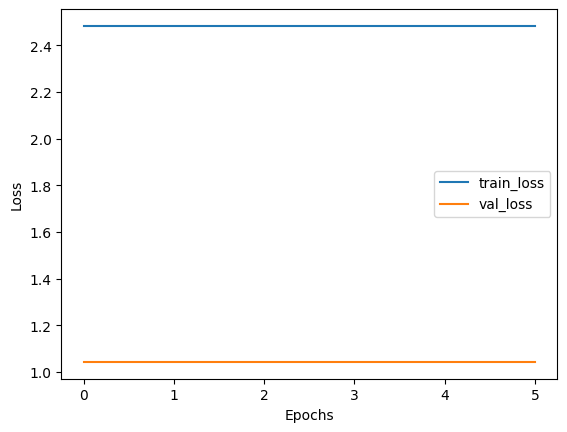

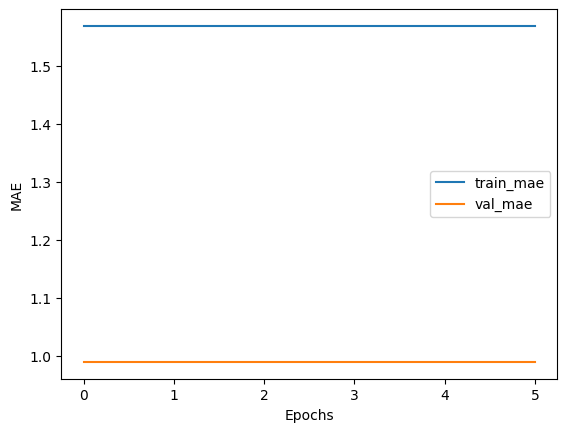

7/7 [==============================] - 0s 8ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/1200
33/33 [==============================] - 4s 74ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1200
33/33 [==============================] - 2s 64ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1200
33/33 [==============================] - 2s 64ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1200
33/33 [==============================] - 2s 63ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1200
33/33 [==============================] - 2s 64ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolu

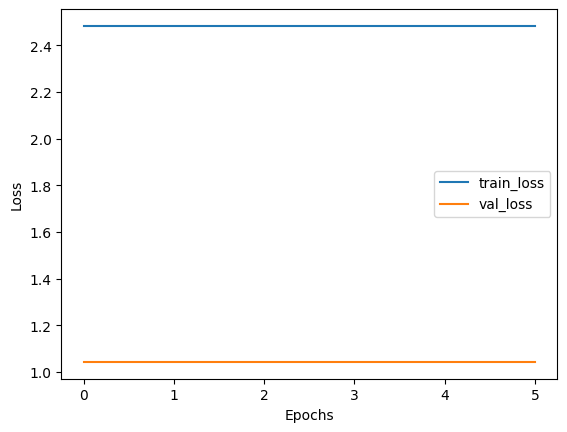

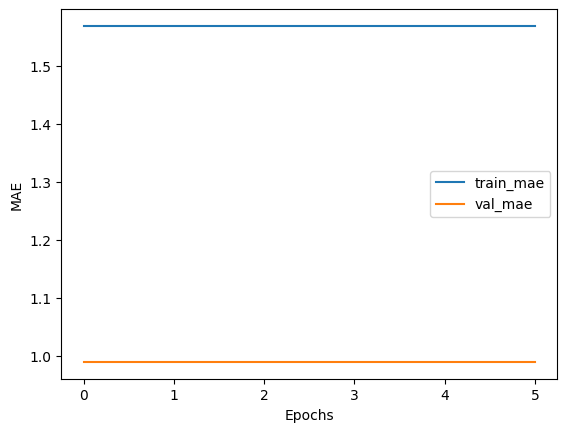

7/7 [==============================] - 1s 24ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/1200
33/33 [==============================] - 9s 195ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1200
33/33 [==============================] - 5s 138ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1200
33/33 [==============================] - 5s 140ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1200
33/33 [==============================] - 5s 141ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1200
33/33 [==============================] - 5s 145ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_erro

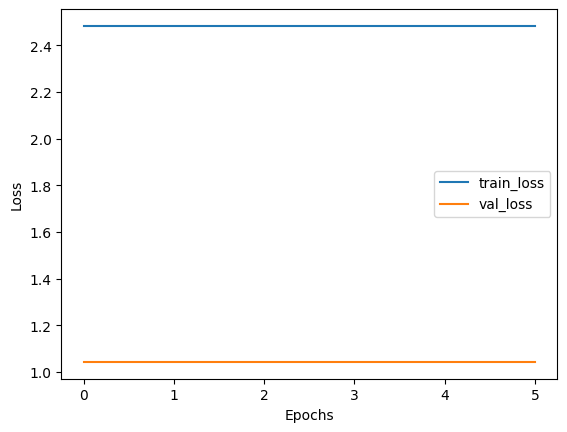

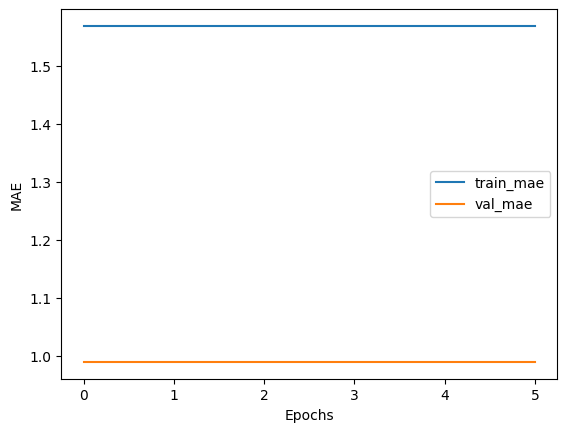

7/7 [==============================] - 1s 47ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/1200
33/33 [==============================] - 4s 81ms/step - loss: 0.0034 - mean_absolute_error: 0.0449 - val_loss: 0.0330 - val_mean_absolute_error: 0.1253
Epoch 2/1200
33/33 [==============================] - 2s 76ms/step - loss: 0.0028 - mean_absolute_error: 0.0419 - val_loss: 0.0274 - val_mean_absolute_error: 0.1245
Epoch 3/1200
33/33 [==============================] - 2s 76ms/step - loss: 0.0029 - mean_absolute_error: 0.0418 - val_loss: 0.0311 - val_mean_absolute_error: 0.1282
Epoch 4/1200
33/33 [==============================] - 2s 72ms/step - loss: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0309 - val_mean_absolute_error: 0.1294
Epoch 5/1200
33/33 [==============================] - 2s 71ms/step - loss: 0.0030 - mean_absolute_error: 0.0433 - val_loss: 0.0408 - val_mean_absolute_error: 0.1318
Epoch 6/1200
33/33

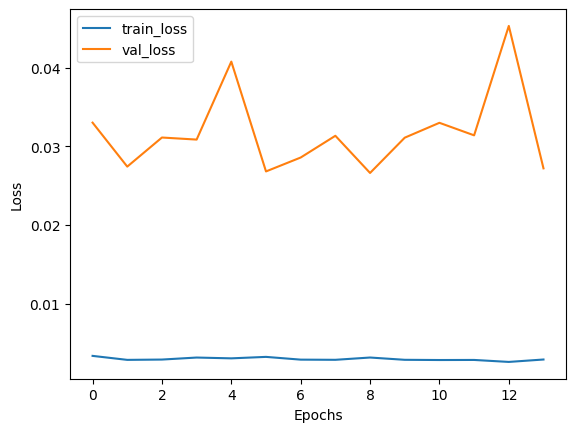

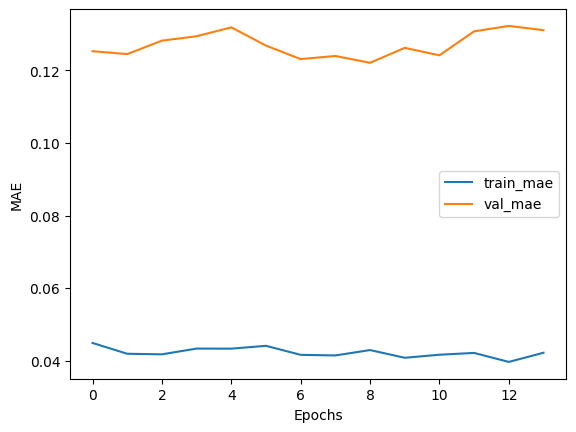

7/7 [==============================] - 0s 23ms/step
LSTM with Attention MAE: 5.342779679422466
LSTM with Attention MSE: 55.52853852899684
Training Base model 12...
Epoch 1/1200
33/33 [==============================] - 4s 80ms/step - loss: 3.1412e-05 - mean_absolute_error: 0.0044 - val_loss: 0.0160 - val_mean_absolute_error: 0.0660
Epoch 2/1200
33/33 [==============================] - 2s 76ms/step - loss: 1.8223e-05 - mean_absolute_error: 0.0029 - val_loss: 0.0126 - val_mean_absolute_error: 0.0648
Epoch 3/1200
33/33 [==============================] - 2s 72ms/step - loss: 2.9398e-05 - mean_absolute_error: 0.0038 - val_loss: 0.0168 - val_mean_absolute_error: 0.0670
Epoch 4/1200
33/33 [==============================] - 2s 73ms/step - loss: 3.2342e-05 - mean_absolute_error: 0.0042 - val_loss: 0.0130 - val_mean_absolute_error: 0.0650
Epoch 5/1200
33/33 [==============================] - 2s 74ms/step - loss: 2.7729e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0169 - val_mean_absolute_error

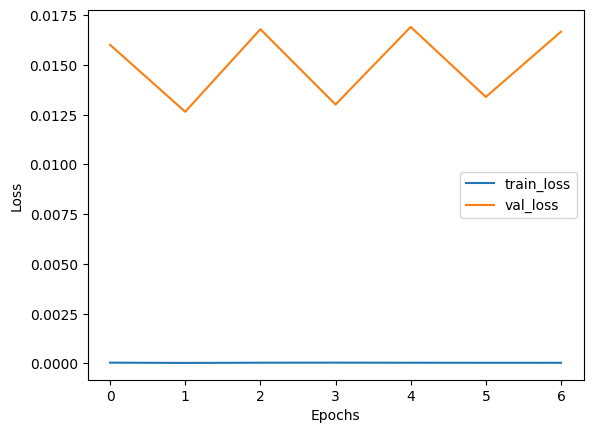

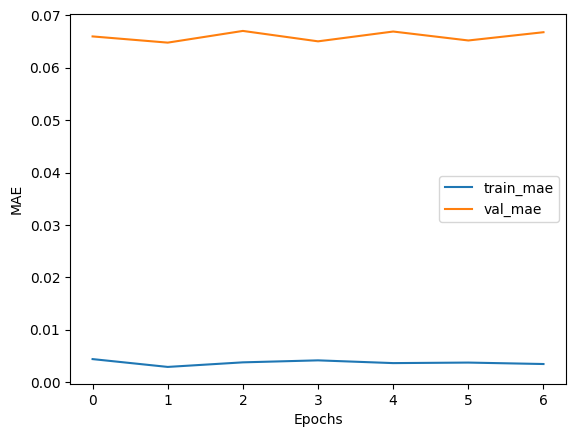

7/7 [==============================] - 0s 20ms/step
Base model 12 MAE: 20.220991153300886
Base model 12 MSE: 768.575250690815
Training Vanilla LSTM layer...
Epoch 1/1500
33/33 [==============================] - 2s 40ms/step - loss: 2.6879e-05 - mean_absolute_error: 0.0041 - val_loss: 0.0115 - val_mean_absolute_error: 0.0696
Epoch 2/1500
33/33 [==============================] - 1s 30ms/step - loss: 4.5368e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0112 - val_mean_absolute_error: 0.0686
Epoch 3/1500
33/33 [==============================] - 1s 30ms/step - loss: 3.3840e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0114 - val_mean_absolute_error: 0.0693
Epoch 4/1500
33/33 [==============================] - 1s 29ms/step - loss: 3.9443e-05 - mean_absolute_error: 0.0051 - val_loss: 0.0112 - val_mean_absolute_error: 0.0686
Epoch 5/1500
33/33 [==============================] - 1s 29ms/step - loss: 2.8708e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0114 - val_mean_absolute_error: 0.069

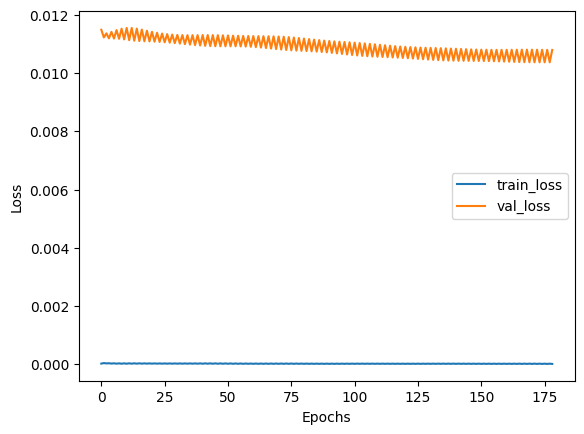

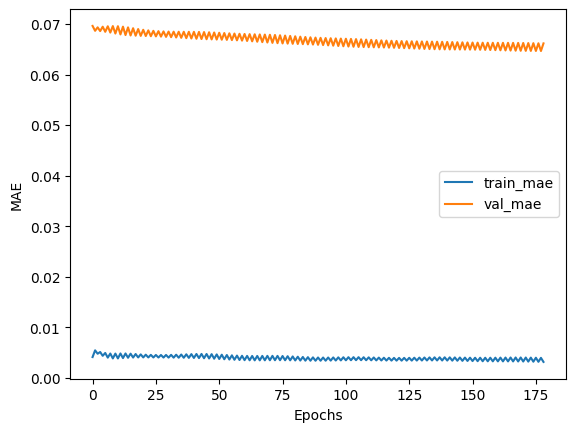

7/7 [==============================] - 0s 10ms/step
Vanilla LSTM layer MAE: 2.1761976005181976
Vanilla LSTM layer MSE: 6.409887306998078
Training Base model 4...
Epoch 1/1500
33/33 [==============================] - 3s 50ms/step - loss: 0.0037 - mean_absolute_error: 0.0475 - val_loss: 0.0132 - val_mean_absolute_error: 0.0862
Epoch 2/1500
33/33 [==============================] - 1s 44ms/step - loss: 0.0040 - mean_absolute_error: 0.0491 - val_loss: 0.0131 - val_mean_absolute_error: 0.0886
Epoch 3/1500
33/33 [==============================] - 1s 44ms/step - loss: 0.0039 - mean_absolute_error: 0.0480 - val_loss: 0.0111 - val_mean_absolute_error: 0.0810
Epoch 4/1500
33/33 [==============================] - 1s 43ms/step - loss: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0146 - val_mean_absolute_error: 0.0924
Epoch 5/1500
33/33 [==============================] - 1s 43ms/step - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0131 - val_mean_absolute_error: 0.0883
Epoch 6/1500


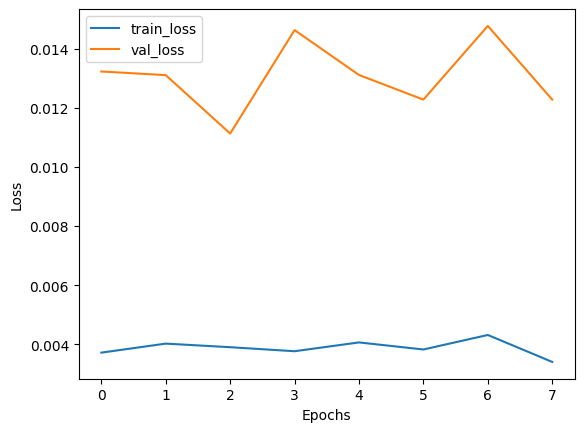

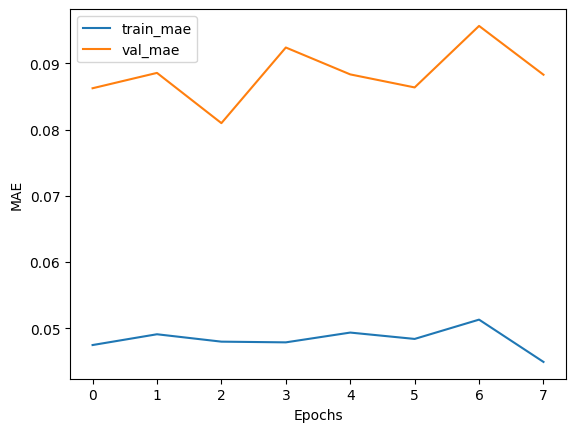

7/7 [==============================] - 0s 13ms/step
Base model 4 MAE: 1.963621829956751
Base model 4 MSE: 5.254536871182236
Training Gated Recurrent Unit (GRU)...
Epoch 1/1500
33/33 [==============================] - 3s 43ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1500
33/33 [==============================] - 1s 35ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1500
33/33 [==============================] - 1s 35ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1500
33/33 [==============================] - 1s 36ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1500
33/33 [==============================] - 1s 35ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/1500

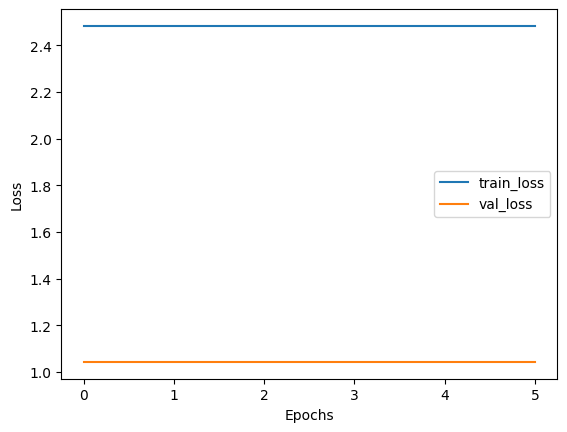

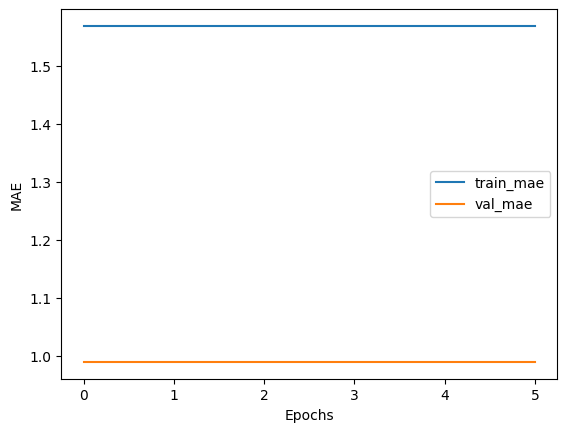

7/7 [==============================] - 0s 12ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/1500
33/33 [==============================] - 5s 96ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1500
33/33 [==============================] - 3s 85ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1500
33/33 [==============================] - 3s 85ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1500
33/33 [==============================] - 3s 83ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1500
33/33 [==============================] - 3s 83ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absol

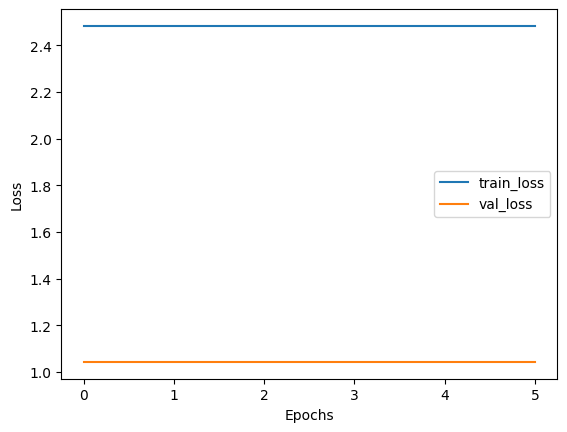

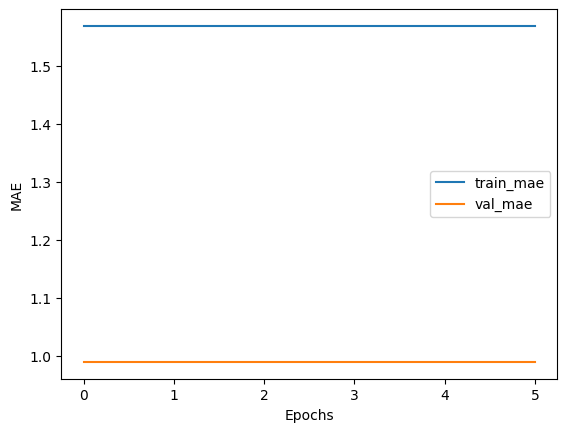

7/7 [==============================] - 1s 28ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/1500
33/33 [==============================] - 10s 208ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/1500
33/33 [==============================] - 6s 196ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/1500
33/33 [==============================] - 6s 196ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/1500
33/33 [==============================] - 6s 195ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/1500
33/33 [==============================] - 7s 201ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_err

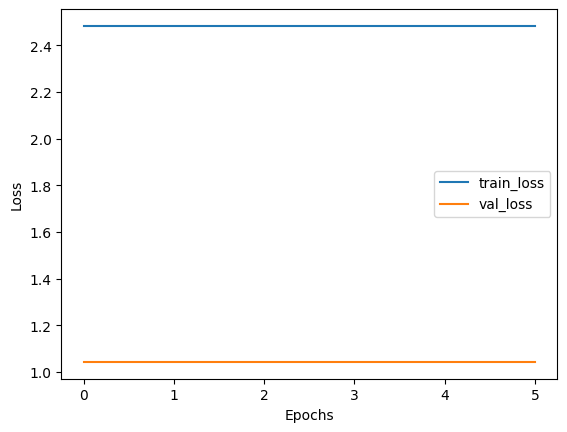

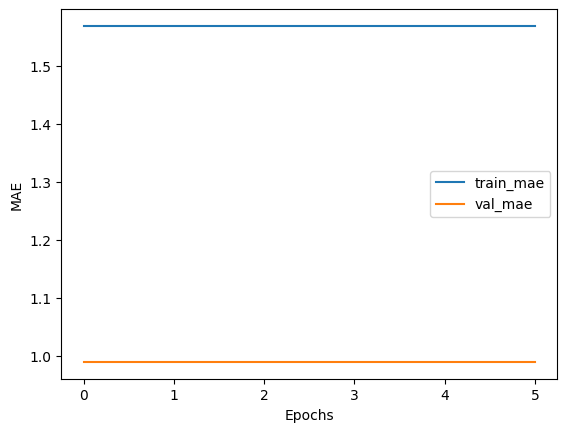

7/7 [==============================] - 1s 61ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/1500
33/33 [==============================] - 5s 115ms/step - loss: 0.0029 - mean_absolute_error: 0.0425 - val_loss: 0.0285 - val_mean_absolute_error: 0.1320
Epoch 2/1500
33/33 [==============================] - 4s 109ms/step - loss: 0.0027 - mean_absolute_error: 0.0402 - val_loss: 0.0364 - val_mean_absolute_error: 0.1304
Epoch 3/1500
33/33 [==============================] - 4s 112ms/step - loss: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0345 - val_mean_absolute_error: 0.1273
Epoch 4/1500
33/33 [==============================] - 4s 109ms/step - loss: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 0.0308 - val_mean_absolute_error: 0.1261
Epoch 5/1500
33/33 [==============================] - 4s 108ms/step - loss: 0.0028 - mean_absolute_error: 0.0415 - val_loss: 0.0401 - val_mean_absolute_error: 0.1311
Epoch 6/1500


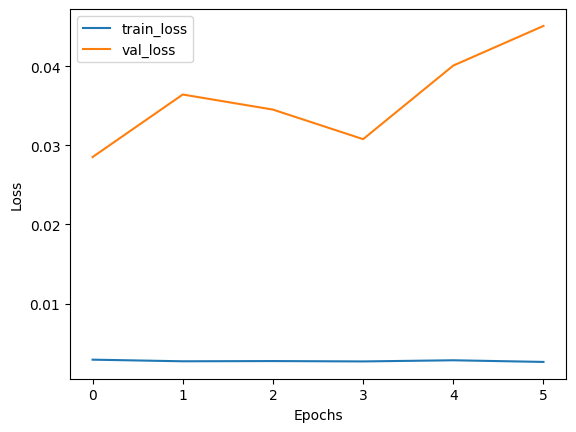

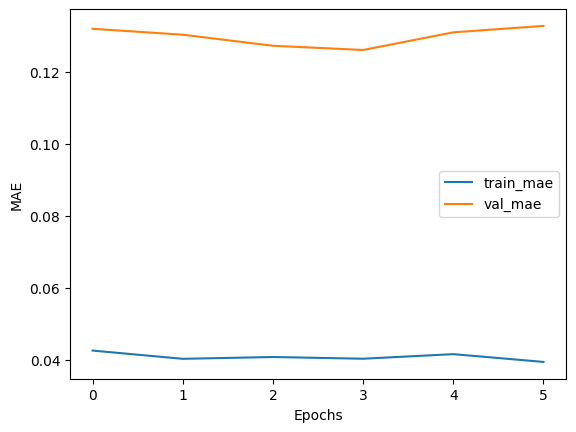

7/7 [==============================] - 0s 34ms/step
LSTM with Attention MAE: 8.308065859188316
LSTM with Attention MSE: 124.8721554985442
Training Base model 12...
Epoch 1/1500
33/33 [==============================] - 5s 117ms/step - loss: 2.7989e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0161 - val_mean_absolute_error: 0.0658
Epoch 2/1500
33/33 [==============================] - 4s 111ms/step - loss: 1.7005e-05 - mean_absolute_error: 0.0030 - val_loss: 0.0130 - val_mean_absolute_error: 0.0641
Epoch 3/1500
33/33 [==============================] - 4s 111ms/step - loss: 1.8250e-05 - mean_absolute_error: 0.0031 - val_loss: 0.0175 - val_mean_absolute_error: 0.0666
Epoch 4/1500
33/33 [==============================] - 4s 111ms/step - loss: 4.1777e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0126 - val_mean_absolute_error: 0.0644
Epoch 5/1500
33/33 [==============================] - 4s 110ms/step - loss: 4.5028e-05 - mean_absolute_error: 0.0045 - val_loss: 0.0172 - val_mean_absolute_

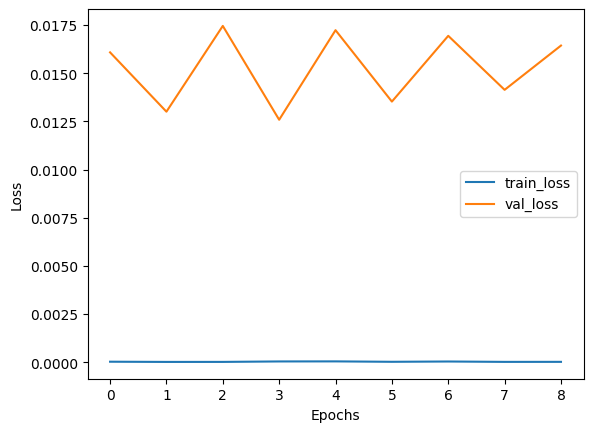

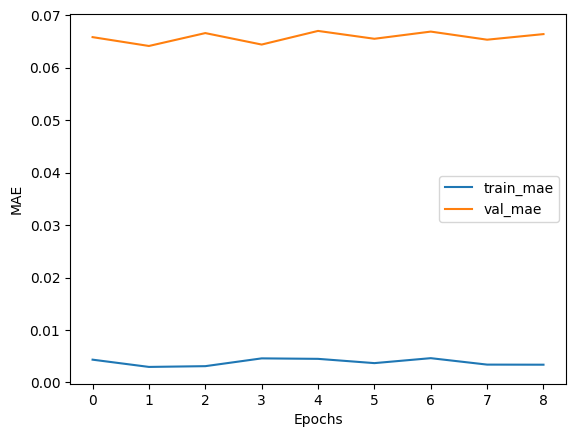

7/7 [==============================] - 0s 35ms/step
Base model 12 MAE: 20.466754900679312
Base model 12 MSE: 810.3740980024695
Training Vanilla LSTM layer...
Epoch 1/2000
33/33 [==============================] - 3s 46ms/step - loss: 2.4372e-05 - mean_absolute_error: 0.0042 - val_loss: 0.0107 - val_mean_absolute_error: 0.0663
Epoch 2/2000
33/33 [==============================] - 1s 39ms/step - loss: 2.9776e-05 - mean_absolute_error: 0.0045 - val_loss: 0.0104 - val_mean_absolute_error: 0.0650
Epoch 3/2000
33/33 [==============================] - 1s 39ms/step - loss: 1.6388e-05 - mean_absolute_error: 0.0033 - val_loss: 0.0107 - val_mean_absolute_error: 0.0661
Epoch 4/2000
33/33 [==============================] - 1s 39ms/step - loss: 2.2588e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0105 - val_mean_absolute_error: 0.0652
Epoch 5/2000
33/33 [==============================] - 1s 39ms/step - loss: 1.3395e-05 - mean_absolute_error: 0.0029 - val_loss: 0.0109 - val_mean_absolute_error: 0.06

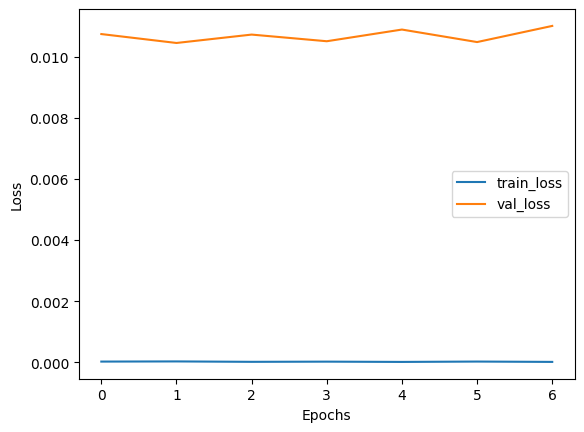

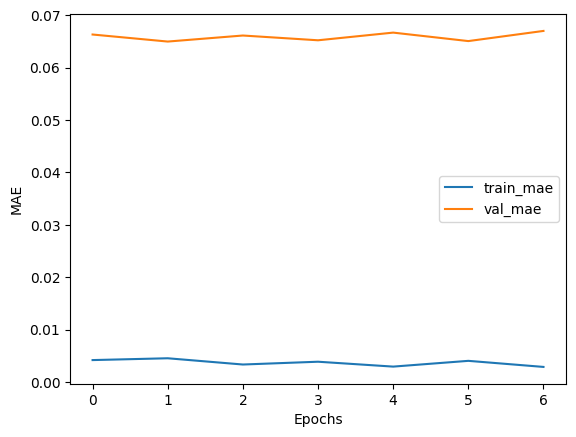

7/7 [==============================] - 0s 13ms/step
Vanilla LSTM layer MAE: 2.1829529930399585
Vanilla LSTM layer MSE: 6.438756008139055
Training Base model 4...
Epoch 1/2000
33/33 [==============================] - 4s 75ms/step - loss: 0.0035 - mean_absolute_error: 0.0466 - val_loss: 0.0127 - val_mean_absolute_error: 0.0898
Epoch 2/2000
33/33 [==============================] - 2s 68ms/step - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0155 - val_mean_absolute_error: 0.0992
Epoch 3/2000
33/33 [==============================] - 2s 69ms/step - loss: 0.0036 - mean_absolute_error: 0.0465 - val_loss: 0.0129 - val_mean_absolute_error: 0.0876
Epoch 4/2000
33/33 [==============================] - 2s 69ms/step - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0134 - val_mean_absolute_error: 0.0908
Epoch 5/2000
33/33 [==============================] - 2s 68ms/step - loss: 0.0036 - mean_absolute_error: 0.0462 - val_loss: 0.0138 - val_mean_absolute_error: 0.0918
Epoch 6/2000


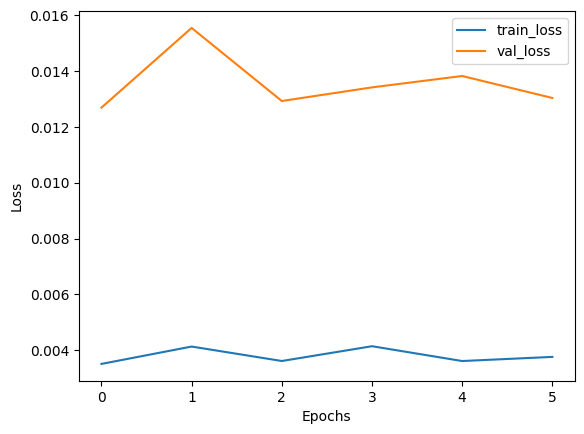

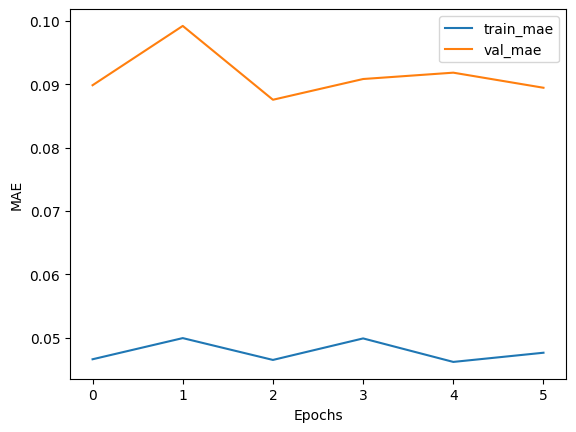

7/7 [==============================] - 0s 18ms/step
Base model 4 MAE: 1.9916027699936152
Base model 4 MSE: 5.372475034944242
Training Gated Recurrent Unit (GRU)...
Epoch 1/2000
33/33 [==============================] - 3s 58ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/2000
33/33 [==============================] - 2s 51ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/2000
33/33 [==============================] - 2s 51ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/2000
33/33 [==============================] - 2s 51ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/2000
33/33 [==============================] - 2s 51ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/200

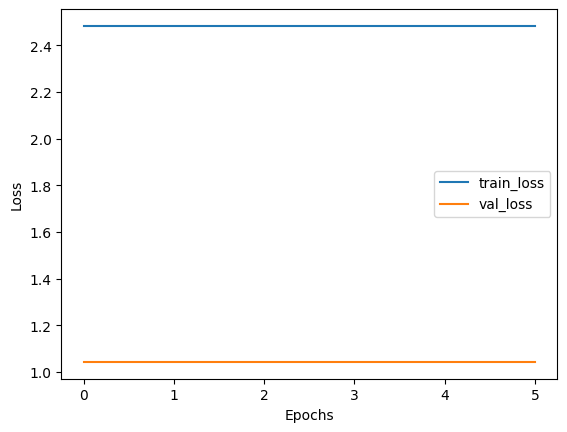

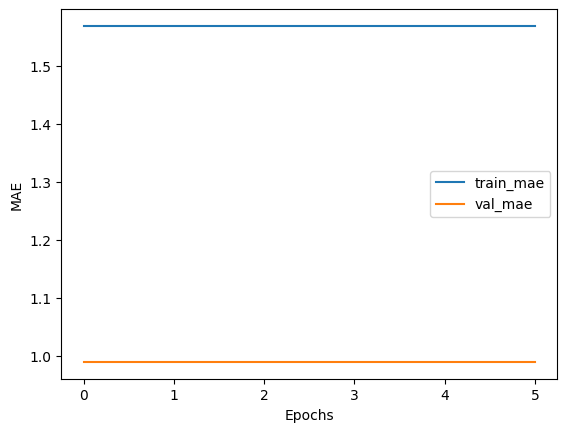

7/7 [==============================] - 0s 17ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/2000
33/33 [==============================] - 6s 134ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/2000
33/33 [==============================] - 4s 121ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/2000
33/33 [==============================] - 4s 120ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/2000
33/33 [==============================] - 4s 120ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/2000
33/33 [==============================] - 4s 120ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_

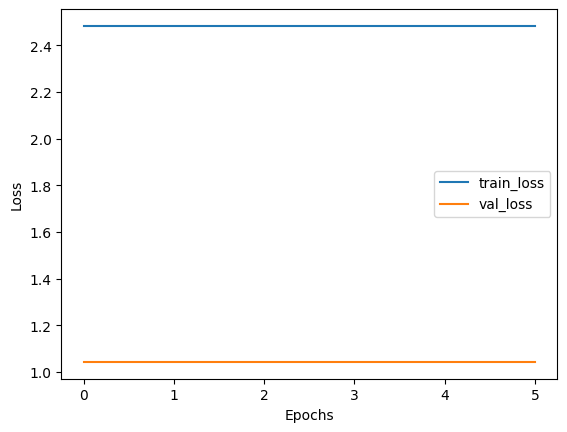

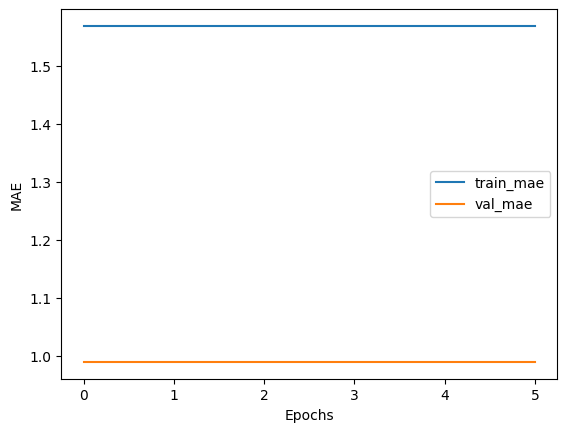

7/7 [==============================] - 1s 42ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/2000
33/33 [==============================] - 12s 279ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/2000
33/33 [==============================] - 8s 251ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/2000
33/33 [==============================] - 8s 252ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/2000
33/33 [==============================] - 8s 250ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/2000
33/33 [==============================] - 9s 269ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_err

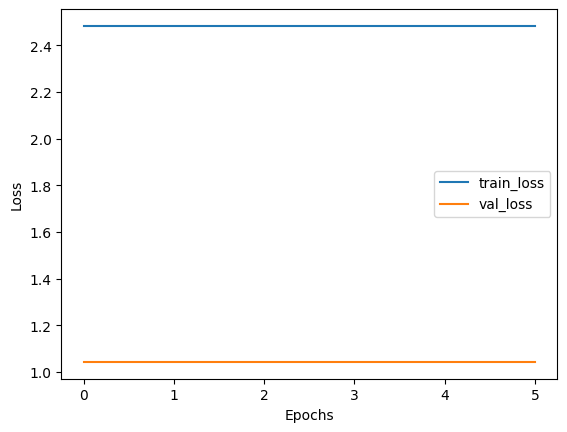

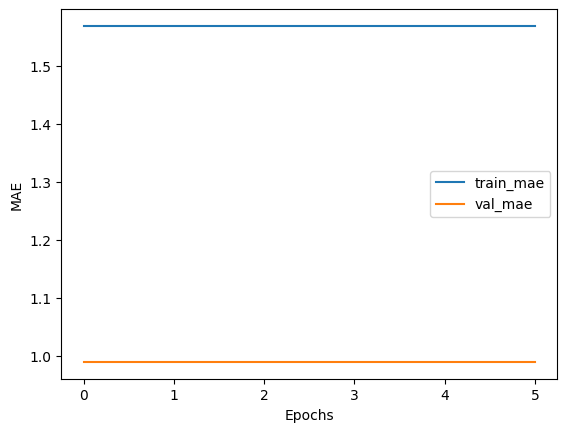

7/7 [==============================] - 1s 82ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/2000
33/33 [==============================] - 6s 144ms/step - loss: 0.0026 - mean_absolute_error: 0.0408 - val_loss: 0.0460 - val_mean_absolute_error: 0.1350
Epoch 2/2000
33/33 [==============================] - 5s 141ms/step - loss: 0.0026 - mean_absolute_error: 0.0401 - val_loss: 0.0341 - val_mean_absolute_error: 0.1329
Epoch 3/2000
33/33 [==============================] - 5s 162ms/step - loss: 0.0026 - mean_absolute_error: 0.0400 - val_loss: 0.0311 - val_mean_absolute_error: 0.1315
Epoch 4/2000
33/33 [==============================] - 5s 142ms/step - loss: 0.0025 - mean_absolute_error: 0.0395 - val_loss: 0.0273 - val_mean_absolute_error: 0.1262
Epoch 5/2000
33/33 [==============================] - 5s 138ms/step - loss: 0.0026 - mean_absolute_error: 0.0388 - val_loss: 0.0339 - val_mean_absolute_error: 0.1311
Epoch 6/2000


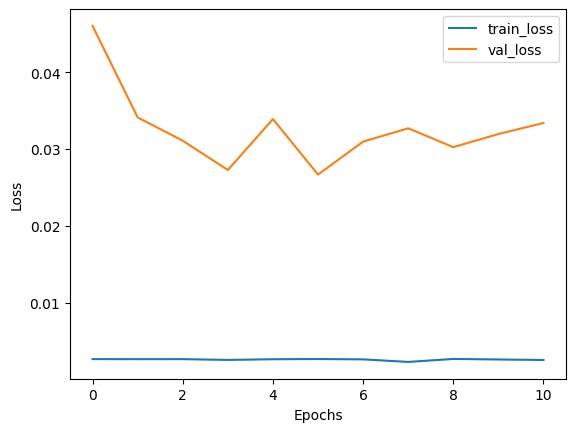

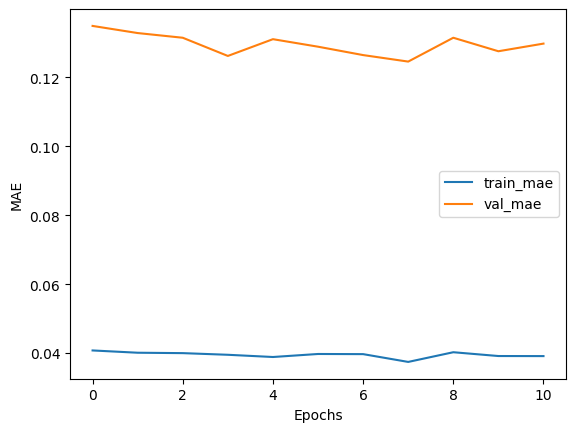

7/7 [==============================] - 0s 44ms/step
LSTM with Attention MAE: 6.9178186933042545
LSTM with Attention MSE: 90.59935564023398
Training Base model 12...
Epoch 1/2000
33/33 [==============================] - 7s 168ms/step - loss: 2.2835e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0159 - val_mean_absolute_error: 0.0657
Epoch 2/2000
33/33 [==============================] - 5s 157ms/step - loss: 1.7172e-05 - mean_absolute_error: 0.0029 - val_loss: 0.0125 - val_mean_absolute_error: 0.0645
Epoch 3/2000
33/33 [==============================] - 5s 155ms/step - loss: 3.0019e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0164 - val_mean_absolute_error: 0.0664
Epoch 4/2000
33/33 [==============================] - 5s 156ms/step - loss: 2.7305e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0130 - val_mean_absolute_error: 0.0646
Epoch 5/2000
33/33 [==============================] - 5s 157ms/step - loss: 2.8697e-05 - mean_absolute_error: 0.0038 - val_loss: 0.0172 - val_mean_absolute

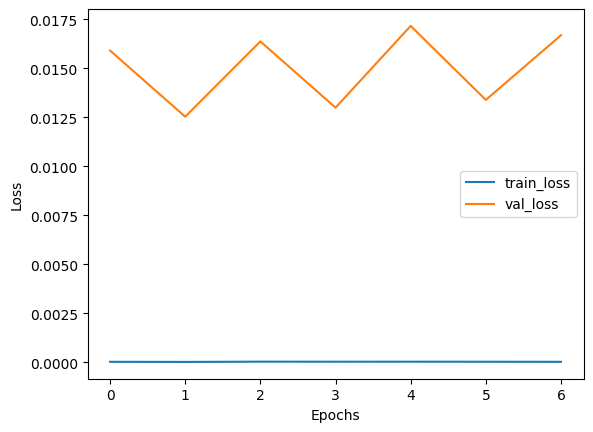

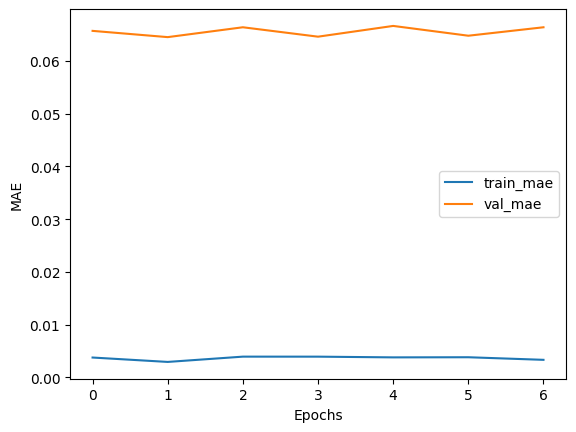

7/7 [==============================] - 0s 47ms/step
Base model 12 MAE: 20.903449768525434
Base model 12 MSE: 849.1563319249137
Training Vanilla LSTM layer...
Epoch 1/2500
33/33 [==============================] - 3s 70ms/step - loss: 3.3387e-05 - mean_absolute_error: 0.0049 - val_loss: 0.0108 - val_mean_absolute_error: 0.0661
Epoch 2/2500
33/33 [==============================] - 2s 63ms/step - loss: 2.9694e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0103 - val_mean_absolute_error: 0.0636
Epoch 3/2500
33/33 [==============================] - 2s 63ms/step - loss: 1.7872e-05 - mean_absolute_error: 0.0035 - val_loss: 0.0107 - val_mean_absolute_error: 0.0654
Epoch 4/2500
33/33 [==============================] - 2s 63ms/step - loss: 2.0592e-05 - mean_absolute_error: 0.0036 - val_loss: 0.0106 - val_mean_absolute_error: 0.0648
Epoch 5/2500
33/33 [==============================] - 2s 63ms/step - loss: 1.5275e-05 - mean_absolute_error: 0.0032 - val_loss: 0.0109 - val_mean_absolute_error: 0.06

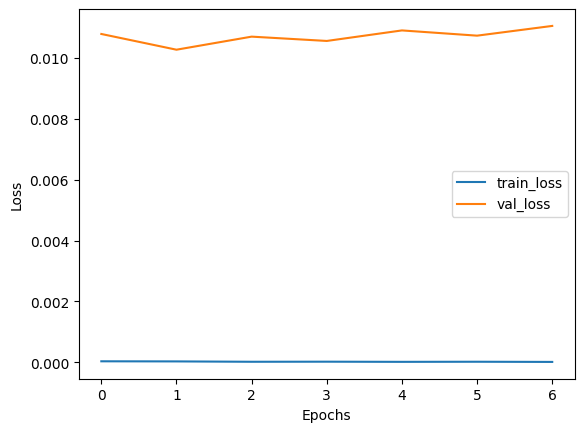

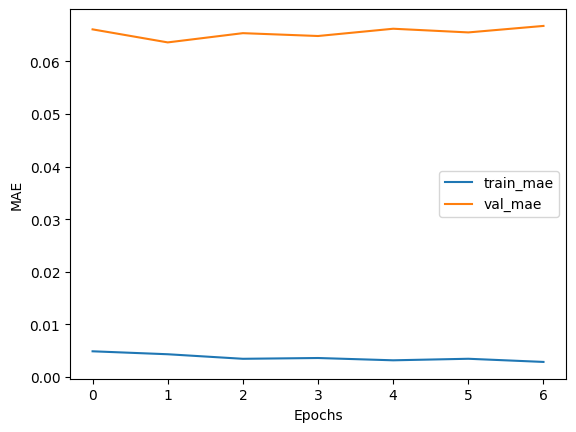

7/7 [==============================] - 0s 23ms/step
Vanilla LSTM layer MAE: 2.186580767447119
Vanilla LSTM layer MSE: 6.456121025514368
Training Base model 4...
Epoch 1/2500
33/33 [==============================] - 5s 107ms/step - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0135 - val_mean_absolute_error: 0.0897
Epoch 2/2500
33/33 [==============================] - 3s 97ms/step - loss: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.0163 - val_mean_absolute_error: 0.0988
Epoch 3/2500
33/33 [==============================] - 3s 98ms/step - loss: 0.0037 - mean_absolute_error: 0.0469 - val_loss: 0.0139 - val_mean_absolute_error: 0.0919
Epoch 4/2500
33/33 [==============================] - 3s 98ms/step - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0176 - val_mean_absolute_error: 0.1045
Epoch 5/2500
33/33 [==============================] - 3s 99ms/step - loss: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0141 - val_mean_absolute_error: 0.0932
Epoch 6/2500


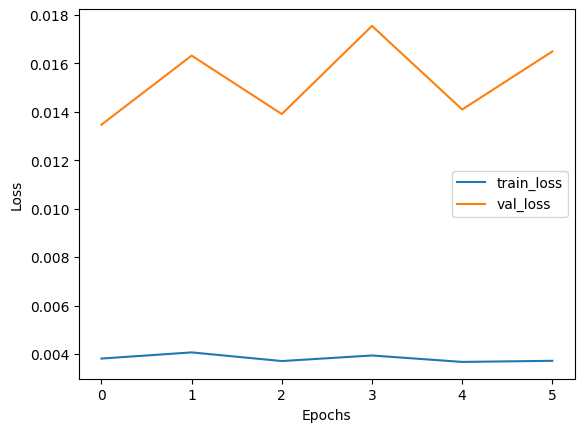

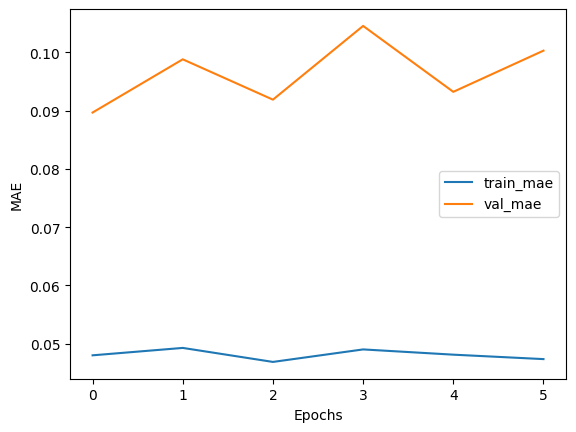

7/7 [==============================] - 0s 24ms/step
Base model 4 MAE: 2.045348443018439
Base model 4 MSE: 5.591342977320882
Training Gated Recurrent Unit (GRU)...
Epoch 1/2500
33/33 [==============================] - 6s 86ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/2500
33/33 [==============================] - 3s 79ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/2500
33/33 [==============================] - 3s 79ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/2500
33/33 [==============================] - 3s 78ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/2500
33/33 [==============================] - 3s 79ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 6/2500

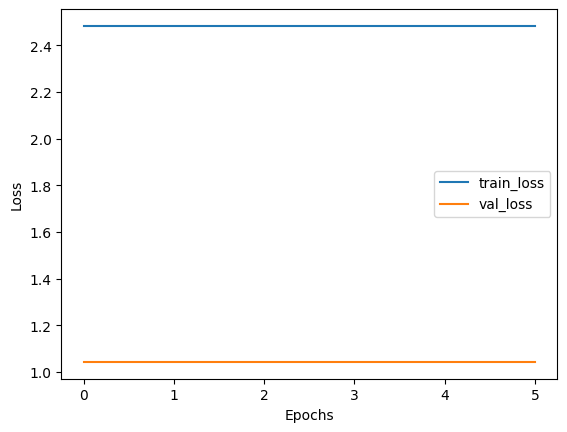

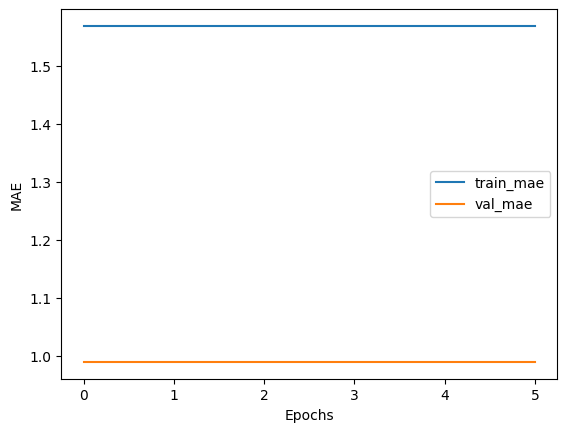

7/7 [==============================] - 0s 22ms/step
Gated Recurrent Unit (GRU) MAE: 1.7399096720163534
Gated Recurrent Unit (GRU) MSE: 4.384646517144733
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/2500
33/33 [==============================] - 9s 196ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/2500
33/33 [==============================] - 6s 182ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/2500
33/33 [==============================] - 6s 182ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/2500
33/33 [==============================] - 6s 182ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/2500
33/33 [==============================] - 6s 181ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_

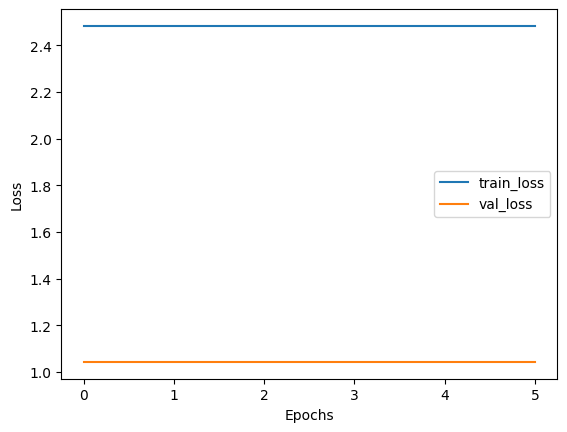

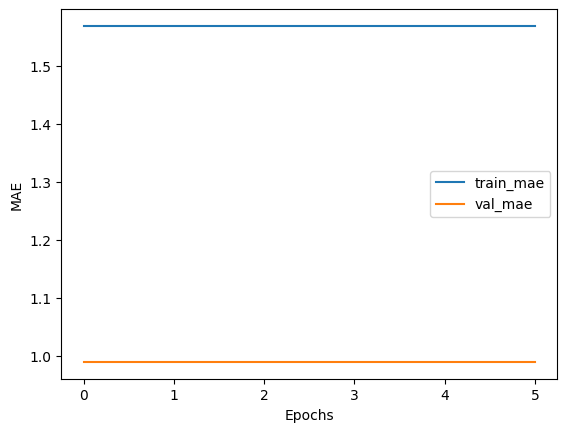

7/7 [==============================] - 1s 66ms/step
Bidirectional LSTM (BiLSTM) MAE: 1.7399096720163534
Bidirectional LSTM (BiLSTM) MSE: 4.384646517144733
Training Stacked LSTM...
Epoch 1/2500
33/33 [==============================] - 16s 397ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 2/2500
33/33 [==============================] - 12s 361ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 3/2500
33/33 [==============================] - 12s 353ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 4/2500
33/33 [==============================] - 12s 371ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute_error: 0.9893
Epoch 5/2500
33/33 [==============================] - 12s 369ms/step - loss: 2.4837 - mean_absolute_error: 1.5688 - val_loss: 1.0426 - val_mean_absolute

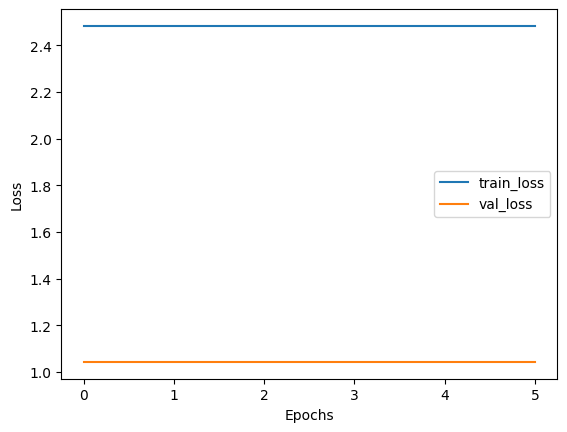

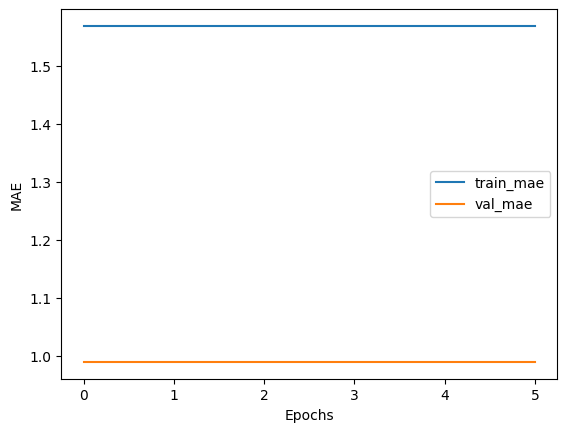

7/7 [==============================] - 1s 118ms/step
Stacked LSTM MAE: 1.7399096720163534
Stacked LSTM MSE: 4.384646517144733
Training LSTM with Attention...
Epoch 1/2500
33/33 [==============================] - 7s 165ms/step - loss: 0.0025 - mean_absolute_error: 0.0393 - val_loss: 0.0308 - val_mean_absolute_error: 0.1306
Epoch 2/2500
33/33 [==============================] - 5s 160ms/step - loss: 0.0026 - mean_absolute_error: 0.0401 - val_loss: 0.0290 - val_mean_absolute_error: 0.1287
Epoch 3/2500
33/33 [==============================] - 5s 156ms/step - loss: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0312 - val_mean_absolute_error: 0.1287
Epoch 4/2500
33/33 [==============================] - 5s 164ms/step - loss: 0.0024 - mean_absolute_error: 0.0379 - val_loss: 0.0291 - val_mean_absolute_error: 0.1284
Epoch 5/2500
33/33 [==============================] - 5s 158ms/step - loss: 0.0024 - mean_absolute_error: 0.0384 - val_loss: 0.0420 - val_mean_absolute_error: 0.1336
Epoch 6/2500

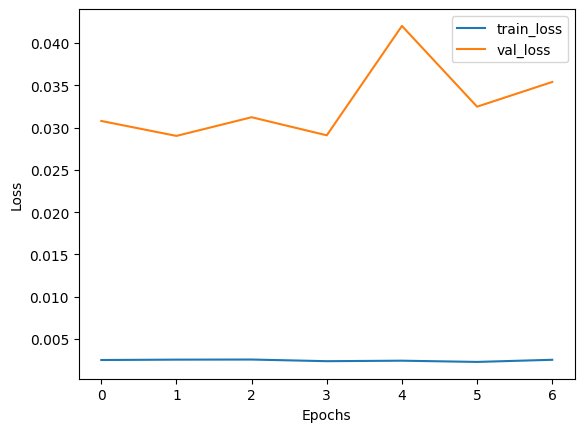

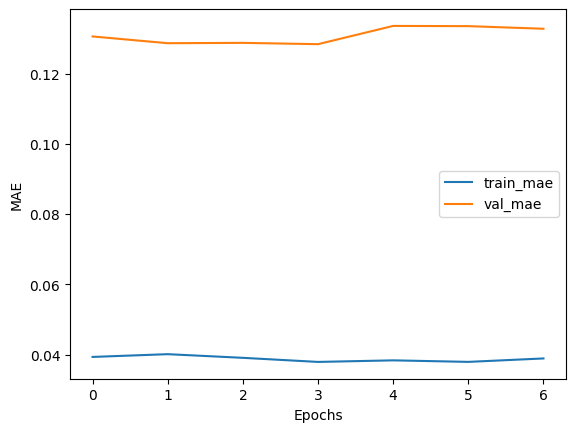

7/7 [==============================] - 0s 49ms/step
LSTM with Attention MAE: 7.391885940742057
LSTM with Attention MSE: 105.23786472364968
Training Base model 12...
Epoch 1/2500
33/33 [==============================] - 7s 165ms/step - loss: 2.2659e-05 - mean_absolute_error: 0.0038 - val_loss: 0.0159 - val_mean_absolute_error: 0.0652
Epoch 2/2500
33/33 [==============================] - 5s 160ms/step - loss: 1.6702e-05 - mean_absolute_error: 0.0029 - val_loss: 0.0127 - val_mean_absolute_error: 0.0640
Epoch 3/2500
33/33 [==============================] - 5s 166ms/step - loss: 2.1526e-05 - mean_absolute_error: 0.0034 - val_loss: 0.0175 - val_mean_absolute_error: 0.0664
Epoch 4/2500
33/33 [==============================] - 5s 162ms/step - loss: 4.4221e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0128 - val_mean_absolute_error: 0.0641
Epoch 5/2500
33/33 [==============================] - 5s 168ms/step - loss: 3.3458e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0168 - val_mean_absolute

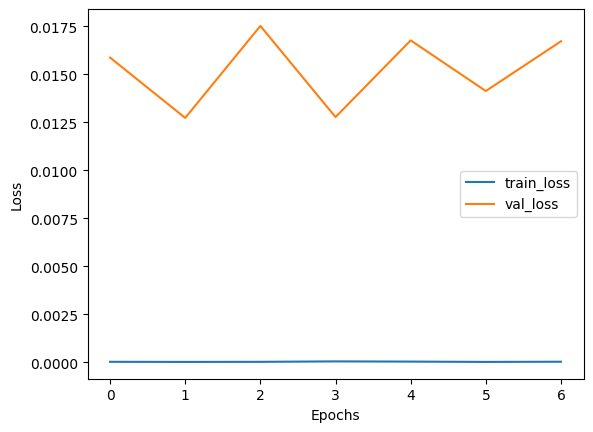

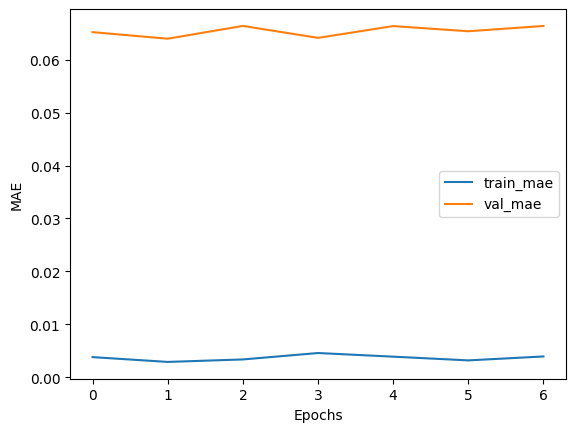

7/7 [==============================] - 1s 52ms/step
Base model 12 MAE: 21.483963805536654
Base model 12 MSE: 897.3540540031267


In [173]:
# Specify the file path
file_path = "experiment.txt"  # Replace with your desired file path
epoch = [5,10,30,50,80,100,250,500,800,1000,1200,1500,2000,2500]
for e in epoch: 
    # Iterate through models, train, and evaluate
    for model_name, build_model_fn in models:
        print(f"Training {model_name}...")
        history = compile_and_fit(build_model_fn,X_train,y_train, epochs=e)
        name = f"{model_name}_{e}"
        plot_training_history(history,name)
        # history.model = build_model_fn(X_train.shape[1:], 1)  # Output dimension is 1 for regression
        # history.model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        
        y_pred = history.model.predict(X_test)
        # Calculate MAE and MSE
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        report = f"At epoch {e} {model_name} has MAE: {mae} and MSE {mse}\n "
        with open(file_path, 'a') as file:
            file.write("\n" + report)

        print(f"{model_name} MAE: {mae}")
        print(f"{model_name} MSE: {mse}")
        print("=" * 50)

In [174]:
import re

# Specify the file path
file_path = 'experiment.txt'  # Replace with the path to your file

# Initialize an empty string to store the file content
file_content = ''

# Open the file for reading
try:
    with open(file_path, 'r') as file:
        # Read the entire content of the file and store it in the string
        file_content = file.read()
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Now, 'file_content' contains the content of the file as a string
print(file_content)



# Define a regular expression pattern to match the data
pattern = r"At epoch (\d+) (.+?) has MAE: ([\d.]+) and MSE ([\d.]+)"

# Use regex to find all matches in the text
matches = re.findall(pattern, file_content)

# Create a list of dictionaries to structure the data
structured_data = []

# Loop through the matches and structure the data
for match in matches:
    epoch = int(match[0])
    model_name = match[1]
    mae = float(match[2])
    mse = float(match[3])
    
    entry = {
        "Epoch": epoch,
        "Model": model_name,
        "MAE": mae,
        "MSE": mse
    }
    
    structured_data.append(entry)

# # Print the structured data
# for entry in structured_data:
#     print(entry)

df = pd.DataFrame(structured_data)
# Set Pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Display the DataFrame
print(df)


At epoch 5 Vanilla LSTM layer has MAE: 2.2648010869266813 and MSE 6.621162240943197
 
At epoch 5 Base model 4 has MAE: 2.4931719353408384 and MSE 7.694270063574645
 
At epoch 5 Gated Recurrent Unit (GRU) has MAE: 1.7399096720163534 and MSE 4.384646517144733
 
At epoch 5 Bidirectional LSTM (BiLSTM) has MAE: 1.7399096720163534 and MSE 4.384646517144733
 
At epoch 5 Stacked LSTM has MAE: 1.7399096720163534 and MSE 4.384646517144733
 
At epoch 5 LSTM with Attention has MAE: 2.2566846936781353 and MSE 6.433180517702948
 
At epoch 5 Base model 12 has MAE: 3.1728827362570247 and MSE 12.822598143185772
 
At epoch 10 Vanilla LSTM layer has MAE: 2.189103778697002 and MSE 6.379763064748777
 
At epoch 10 Base model 4 has MAE: 2.2297737763302115 and MSE 6.394500114114798
 
At epoch 10 Gated Recurrent Unit (GRU) has MAE: 1.7399096720163534 and MSE 4.384646517144733
 
At epoch 10 Bidirectional LSTM (BiLSTM) has MAE: 1.7399096720163534 and MSE 4.384646517144733
 
At epoch 10 Stacked LSTM has MAE: 1.7

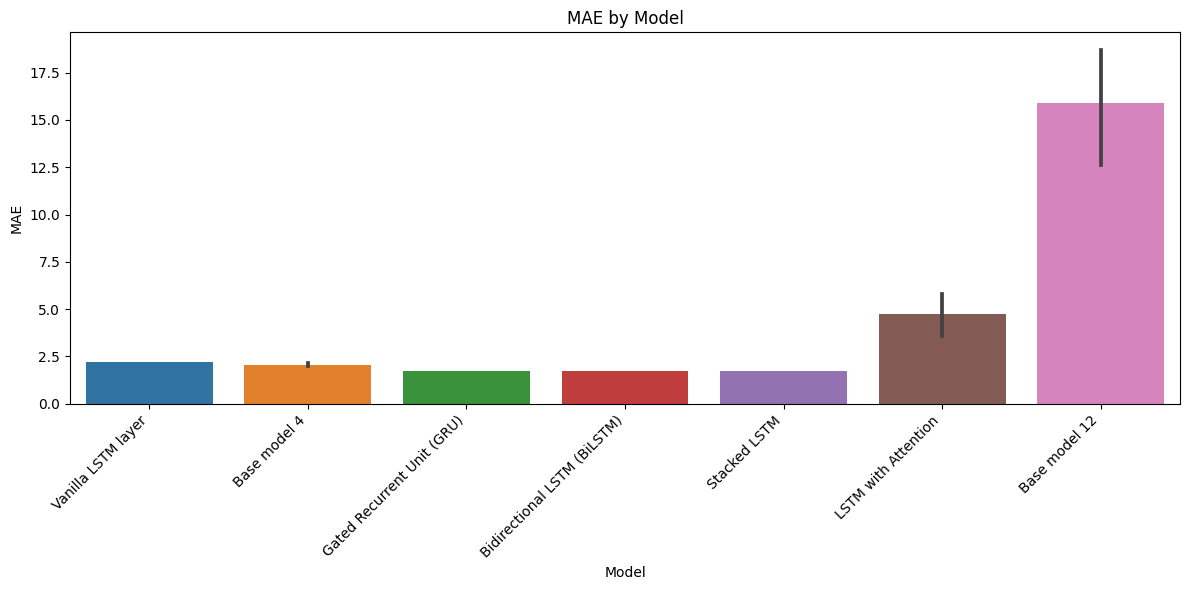

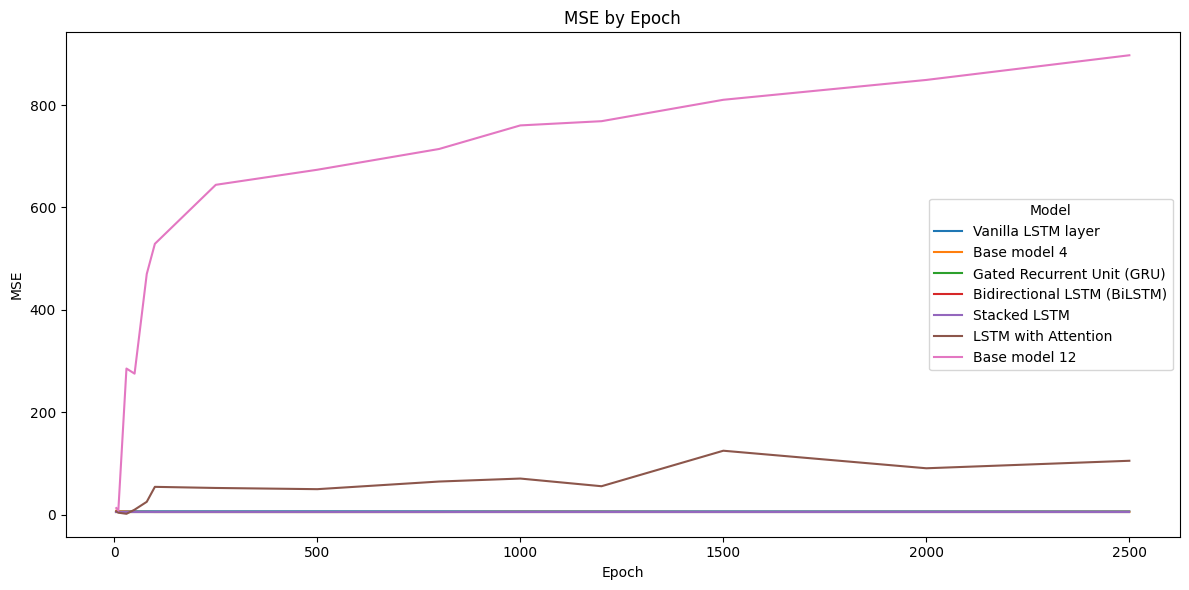

In [175]:
# Reset the display options to their defaults
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


# Create a bar chart for MAE values by model
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="MAE", data=df)
plt.title("MAE by Model")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

# Create a line plot for MSE values by epoch
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="MSE", hue="Model", data=df)
plt.title("MSE by Epoch")
plt.tight_layout()

# Show the plots
plt.show()

In [176]:
%pip install plotly
%pip install --upgrade nbformat

import pandas as pd
import plotly.express as px

# Create a bar chart for MAE values by model using Plotly Express
bar_chart = px.bar(df, x="Model", y="MAE", title="MAE by Model", labels={"MAE": "Mean Absolute Error"})
bar_chart.update_xaxes(categoryorder="total ascending")

# Create a line plot for MSE values by epoch using Plotly Express
line_plot = px.line(df, x="Epoch", y="MSE", color="Model", title="MSE by Epoch", labels={"MSE": "Mean Squared Error"})
line_plot.update_xaxes(type='category')

# Show the plots
bar_chart.show()
line_plot.show()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
